In [ ]:
# File Authorship Information
__author__ = """Matteo Lulli, Emily S. C. Ching"""
__copyright__ = """Matteo Lulli, Emily S. C. Ching, idea.deploy"""
__license__ = """Permission is hereby granted, free of charge, 
to any person obtaining a copy of this software and associated 
documentation files (the "Software"), to deal in the Software 
without restriction, including without limitation the rights to 
use, copy, modify, merge, publish, distribute, sublicense, 
and/or sell copies of the Software, 
and to permit persons to whom the Software is furnished to do so, 
subject to the following conditions:
The above copyright notice and this permission notice shall be 
included in all copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, 
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES 
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND 
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT 
HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, 
WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER 
DEALINGS IN THE SOFTWARE."""
__maintainer__ = "Matteo Lulli"
__email__ = "matteo.lulli@gmail.com"
__status__ = "Development"

In [2]:
# Development cell
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import numpy as np
import sympy as sp

sp.init_printing()

import matplotlib.pyplot as plt

# Higher-order Tuning of Interface Physics in Multiphase Lattice Boltzmann

Authors: Matteo Lulli, Emily S. C. Ching


**Abstract:**
Tuning the interface properties of multiphase models is of paramount importance to the final goal of achieving a one-to-one matching with nucleation and cavitation experiments. The surface tension, at the leading order, and the Tolman length, at higher order, play a crucial role in the estimation of the free-energy barrier determining the experimentally observed nucleation rates. The lattice Boltzmann method allows for a computationally efficient modelling approach of multiphase flows, however, tuning results are concerned with the surface tension and neglect the Tolman length. We present a novel perspective that leverages all the degrees of freedom hidden in the forcing stencil of the Shan-Chen multiphase model. By means of the lattice pressure tensor we determine and tune the coefficients of higher-order derivative terms related to surface tension and Tolman length at constant interface width and density ratio. We test the method by means of both hydrostatic and dynamic simulations and demonstrate the dependence of homogeneous nucleation rates on the value of the Tolman length. This work provides a new tool that can be integrated with previously existing strategies thus marking a step forwards to a high-fidelity modelling of phase-changing fluid dynamics.

# Reproducibility

This document is intended for those interested readers who want to reproduce the results reported in the paper [](). In the present case the computational resources needed should be available in general. 

Next development steps will include a class to measure the time required by each cell and output it in a .json file which can be sent to [matteo.lulli@gmail.com](mailto:matteo.lulli@gmail.com) so that average execution times will be available and organized according to the hardware.

Each subsection can be executed independently and reproduce the results which will be stored locally in the directory 'reproduced-data', so that the data will be generated only once.

Plots can also be generated using the same scripts employed for the figures of the paper. Since there are some issues in executing these scripts in the Jupyter environment we include them as separated files which are called from the cells themselves. **In order to reproduce the plots a working 'latex' installation is necessary to be present on the system.**

This file will be kept updated for new local features and developments in the parent project [**idea.deploy**](https://github.com/lullimat/idea.deploy)

This file is supposed to be pulled from the repository [](), from within the "papers" directory the idea.deploy project.

## Table I

In [3]:
## Computing the weights of the stencils according to
## M. Sbragaglia, R. Benzi, L. Biferale, S. Succi, K. Sugiyama, and F. Toschi, Physical Review E 75
## https://doi.org/10.1103/physreve.75.026702

from idpy.LBM.SCFStencils import SCFStencils, BasisVectors
from idpy.IdpyStencils.IdpyStencils import IDStencils

D2E4_orig, D3E4_orig = \
    SCFStencils(E = BasisVectors(x_max = 2), len_2s = [1,2]), IDStencils['LBM']['SC_D3E4']
print(D2E4_orig.FindWeights())

D2E6_orig, D3E6_orig = \
    SCFStencils(E = BasisVectors(x_max = 2), len_2s = [1,2,4]), IDStencils['LBM']['SC_D3E6']
print(D2E6_orig.FindWeights())

D2E8_orig, D3E8_orig = \
    SCFStencils(E = BasisVectors(x_max = 2), len_2s = [1,2,4,5,8]), IDStencils['LBM']['SC_D3E8']
print(D2E8_orig.FindWeights())

D2E10_orig, D3E10_orig = \
    SCFStencils(E = BasisVectors(x_max = 3), len_2s = [1,2,4,5,8,9,10]), IDStencils['LBM']['SC_D3E10']
print(D2E10_orig.FindWeights())

D2E12_orig = \
    SCFStencils(E = BasisVectors(x_max = 4), len_2s = [1,2,4,5,8,9,10,13,16,17])
print(D2E12_orig.FindWeights())

## Computing the isotropy coefficients - 2d and 3d coincide because the 3d stencils exactly projects onto the 2d ones

stencil_objs = [D2E4_orig, D2E6_orig, D2E8_orig, D2E10_orig, D2E12_orig]
stencil_vecs = [D2E4_orig.PushStencil(), D2E6_orig.PushStencil(), D2E8_orig.PushStencil(), D2E10_orig.PushStencil(), D2E12_orig.PushStencil()]

slabs = {D2E4_orig: r'E^{(4)}', D2E6_orig: r'E^{(6)}', D2E8_orig: r'E^{(8)}', D2E10_orig: r'E^{(10)}', D2E12_orig: r'E^{(12)}'}
es_vals_dict = {}
for label, twod_stencil in zip(stencil_objs, stencil_vecs):
    es_vals_dict[label] = {}
    
    Ws, XIs = np.array(twod_stencil['Ws']), np.array(twod_stencil['Es'])
    ## 4th
    n0, n1 = 2, 2
    es_vals_dict[label][4] = str(np.sum(Ws * (XIs[:, 0] ** n0) * (XIs[:, 1] ** n1)))
    ## 6th
    n0, n1 = 4, 2
    es_vals_dict[label][6] = str(np.sum(Ws * (XIs[:, 0] ** n0) * (XIs[:, 1] ** n1))  / sp.factorial2(3))
    ## 8th
    n0, n1 = 4, 4
    es_vals_dict[label][8] = str(np.sum(Ws * (XIs[:, 0] ** n0) * (XIs[:, 1] ** n1)) / (sp.factorial2(3) ** 2))
    ## 10th
    n0, n1 = 6, 4
    es_vals_dict[label][10] = str(np.sum(Ws * (XIs[:, 0] ** n0) * (XIs[:, 1] ** n1)) / (sp.factorial2(5) * sp.factorial2(3)))
    ## 12th
    n0, n1 = 6, 6
    es_vals_dict[label][12] = str(np.sum(Ws * (XIs[:, 0] ** n0) * (XIs[:, 1] ** n1)) / (sp.factorial2(5) ** 2))

## Computing the number of vectors in each stencil

vecs_n_2d = {s: str(len(s.PushStencil()['Es'])) for s in stencil_objs}

from idpy.Utils.Geometry import GetDihedralVectorsG

### Using the 2d labels also for the 3d case
vecs_n_3d = {}
vecs_4_3d = [(1, 0, 0), (1, 1, 0)]
vecs_n_3d[D2E4_orig] = str(np.sum([len(GetDihedralVectorsG(np.array(v))) for v in vecs_4_3d]))

vecs_6_3d = [(1, 0, 0), (1, 1, 0), (1, 1, 1), (2, 0, 0)]
vecs_n_3d[D2E6_orig] = str(np.sum([len(GetDihedralVectorsG(np.array(v))) for v in vecs_6_3d]))

vecs_8_3d = [(1, 0, 0), (1, 1, 0), (1, 1, 1), (2, 0, 0), (2, 1, 0), (2, 1, 1), (2, 2, 0)]
vecs_n_3d[D2E8_orig] = str(np.sum([len(GetDihedralVectorsG(np.array(v))) for v in vecs_8_3d]))

vecs_10_3d = [(1, 0, 0), (1, 1, 0), (1, 1, 1), (2, 0, 0), (2, 1, 0), (2, 1, 1), (2, 2, 0), (2, 2, 1), (3, 0, 0), (3, 1, 0), (3, 1, 1)]
vecs_n_3d[D2E10_orig] = str(np.sum([len(GetDihedralVectorsG(np.array(v))) for v in vecs_10_3d]))

vecs_12_3d = [(1, 0, 0), (1, 1, 0), (1, 1, 1), (2, 0, 0), (2, 1, 0), (2, 1, 1), (2, 2, 0), (2, 2, 1), (3, 0, 0), (3, 1, 0), (3, 1, 1), 
              (3, 2, 0), (3, 2, 1), (4, 0, 0), (3, 2, 2), (3, 3, 0)]
vecs_n_3d[D2E12_orig] = str(np.sum([len(GetDihedralVectorsG(np.array(v))) for v in vecs_12_3d]))

## Generating the table

from IPython.display import display, Latex

table_I = r"""
\begin{array}{lccccc}
& """ + slabs[D2E4_orig] + r"""& """ + slabs[D2E6_orig] + r"""& """ + slabs[D2E8_orig] + r"""& """ + slabs[D2E10_orig] + r"""& """ + slabs[D2E12_orig] + r"""\\
\hline
e_4 & """ + es_vals_dict[D2E4_orig][4] + r""" & """ + es_vals_dict[D2E6_orig][4] + r""" & """ + es_vals_dict[D2E8_orig][4] + r""" & """ + es_vals_dict[D2E10_orig][4] + r""" & """ + es_vals_dict[D2E12_orig][4] + r""" \\
e_6 & """ + es_vals_dict[D2E4_orig][6] + r""" & """ + es_vals_dict[D2E6_orig][6] + r""" & """ + es_vals_dict[D2E8_orig][6] + r""" & """ + es_vals_dict[D2E10_orig][6] + r""" & """ + es_vals_dict[D2E12_orig][6] + r""" \\
e_8 & """ + es_vals_dict[D2E4_orig][8] + r""" & """ + es_vals_dict[D2E6_orig][8] + r""" & """ + es_vals_dict[D2E8_orig][8] + r""" & """ + es_vals_dict[D2E10_orig][8] + r""" & """ + es_vals_dict[D2E12_orig][8] + r""" \\
e_{10} & """ + es_vals_dict[D2E4_orig][10] + r""" & """ + es_vals_dict[D2E6_orig][10] + r""" & """ + es_vals_dict[D2E8_orig][10] + r""" & """ + es_vals_dict[D2E10_orig][10] + r""" & """ + es_vals_dict[D2E12_orig][10] + r""" \\
e_{12} & """ + es_vals_dict[D2E4_orig][12] + r""" & """ + es_vals_dict[D2E6_orig][12] + r""" & """ + es_vals_dict[D2E8_orig][12] + r""" & """ + es_vals_dict[D2E10_orig][12] + r""" & """ + es_vals_dict[D2E12_orig][12] + r""" \\
% \hline
N_e,\;d=2 & """ + vecs_n_2d[D2E4_orig] + r""" & """ + vecs_n_2d[D2E6_orig] + r""" & """ + vecs_n_2d[D2E8_orig] + r""" & """ + vecs_n_2d[D2E10_orig] + r""" & """ + vecs_n_2d[D2E12_orig] + r""" \\
N_e,\;d=3 & """ + vecs_n_3d[D2E4_orig] + r""" & """ + vecs_n_3d[D2E6_orig] + r""" & """ + vecs_n_3d[D2E8_orig] + r""" & """ + vecs_n_3d[D2E10_orig] + r""" & """ + vecs_n_3d[D2E12_orig] + r""" \\
\end{array}
"""

display(Latex(table_I))
print(table_I)

[1/3, 1/12]
[4/15, 1/10, 1/120]
[4/21, 4/45, 1/60, 2/315, 1/5040]
[262/1785, 93/1190, 7/340, 6/595, 9/9520, 2/5355, 1/7140]
[68/585, 68/1001, 1/45, 62/5005, 1/520, 4/4095, 2/4095, 2/45045, 1/480480, 0]


<IPython.core.display.Latex object>


\begin{array}{lccccc}
& E^{(4)}& E^{(6)}& E^{(8)}& E^{(10)}& E^{(12)}\\
\hline
e_4 & 1/3 & 2/5 & 4/7 & 12/17 & 120/143 \\
e_6 & 1/9 & 2/15 & 32/105 & 8/17 & 96/143 \\
e_8 & 1/27 & 2/45 & 16/105 & 176/595 & 512/1001 \\
e_{10} & 1/135 & 2/225 & 16/225 & 104/595 & 1856/5005 \\
e_{12} & 1/675 & 2/1125 & 16/525 & 288/2975 & 256/1001 \\
% \hline
N_e,\;d=2 & 8 & 12 & 24 & 36 & 56 \\
N_e,\;d=3 & 18 & 32 & 92 & 170 & 284 \\
\end{array}



## Results V.A: Leading order surface tension tuning - $\hat{\sigma}_0$

### Simulations

In [4]:
from scipy.interpolate import UnivariateSpline

def SpinodalPsi(G, psi_sym, n_sym, n_min = 1e-4, n_max = 10):
    dpsi_sym = sp.diff(psi_sym, (n_sym, 1))
    psi_f = sp.lambdify([n_sym], psi_sym)
    dpsi_f = sp.lambdify([n_sym], dpsi_sym)
    n_range = np.linspace(n_min, n_max, 2 ** 13)
    dpsi_0_spl = UnivariateSpline(n_range, 1 / 3 + G * psi_f(n_range) * dpsi_f(n_range), s=0)
    n_spin = dpsi_0_spl.roots()
    # return n_spin, n_range, dpsi_0_spl
    return n_spin


def FindDensityFromPressure(G, psi_sym, n_sym, p_target, n_s_values, branch='n_g', exp_2 = 8, n_max = 10):
    n_s_vals = n_s_values
    psi_f = sp.lambdify([n_sym], psi_sym)

    if branch == 'n_g':
        n_s = n_s_vals[0]
        n_range = np.linspace(1e-4, n_s, 2 ** exp_2)
        p_target_spl = UnivariateSpline(n_range, n_range / 3 + 0.5 * G * (psi_f(n_range) ** 2) - p_target, s=0)
        return p_target_spl.roots()[0]

    if branch == 'n_l':
        n_s = n_s_vals[1]
        n_range = np.linspace(n_s, n_max, 2 ** exp_2)
        p_target_spl = UnivariateSpline(n_range, n_range / 3 + 0.5 * G * (psi_f(n_range) ** 2) - p_target, s=0)
        return p_target_spl.roots()[0]

def FindBulkDensitiesDropletLaplace(d, R, G, psi_sym, n_sym, eq_params, n_s_values, sigma_pref = 1):
    p_l = eq_params['p_0'] + (eq_params['n_l'] / (eq_params['n_l'] - eq_params['n_g'])) * (d - 1) * (sigma_pref * eq_params['sigma_f']) / R
    p_g = eq_params['p_0'] + (eq_params['n_g'] / (eq_params['n_l'] - eq_params['n_g'])) * (d - 1) * (sigma_pref * eq_params['sigma_f']) / R

    n_l = FindDensityFromPressure(G, psi_sym, n_sym, p_l, n_s_values, branch='n_l')
    n_g = FindDensityFromPressure(G, psi_sym, n_sym, p_g, n_s_values, branch='n_g')

    return {'n_l': n_l, 'n_g': n_g}

def FindBulkDensitiesBubbleLaplace(d, R, G, psi_sym, n_sym, eq_params, n_s_values, sigma_pref = 1):
    p_l = eq_params['p_0'] + (eq_params['n_g'] / (eq_params['n_l'] - eq_params['n_g'])) * (d - 1) * (sigma_pref * eq_params['sigma_f']) / R
    p_g = eq_params['p_0'] + (eq_params['n_l'] / (eq_params['n_l'] - eq_params['n_g'])) * (d - 1) * (sigma_pref * eq_params['sigma_f']) / R

    n_l = FindDensityFromPressure(G, psi_sym, n_sym, p_l, n_s_values, branch='n_l')
    n_g = FindDensityFromPressure(G, psi_sym, n_sym, p_g, n_s_values, branch='n_g')

    return {'n_l': n_l, 'n_g': n_g}

from scipy.optimize import newton

def MaxwellEqualAreaIntegral(p0_val, G_val, psi_sym, n_sym, ns_g, ns_l, pb_lam, exp_2 = 10):
    ng_p0 = FindDensityFromPressure(G_val, psi_sym, n_sym, p0_val, (ns_g, ns_l), branch='n_g', exp_2 = 10, n_max=4)
    nl_p0 = FindDensityFromPressure(G_val, psi_sym, n_sym, p0_val, (ns_g, ns_l), branch='n_l', exp_2 = 10, n_max=4)
    n_fine_adapted = np.linspace(ng_p0, nl_p0, 2 ** exp_2)
    dn_fine = n_fine_adapted[1] - n_fine_adapted[0]
    return np.sum((p0_val - pb_lam(n_fine_adapted)) / (n_fine_adapted ** 2)) * dn_fine

def MyNewton(p_min, p_max, MEAInteg_lam, accuracy = 1e-10):
    print(p_min, p_max, MEAInteg_lam(p_min), MEAInteg_lam(p_max))
    steps_count = 0
    MI_min, MI_max = MEAInteg_lam(p_min), MEAInteg_lam(p_max)
    while np.abs(MEAInteg_lam((p_min + p_max) * 0.5)) > accuracy:
        new_p = (p_min + p_max) * 0.5
        new_MI = MEAInteg_lam(new_p)
        steps_count += 1
        if new_MI * MI_min > 0:
            MI_min, p_min = new_MI, new_p
        else:
            MI_max, p_max = new_MI, new_p
    return (p_min + p_max) * 0.5, steps_count

"""
Psi profile: always assuming Eq. 
"""
def MaxwellProfileIntegral(n_val, ng_val, p0_val, pb_lam, exp_2 = 10):
    n_fine_adapted = np.linspace(ng_val, n_val, 2 ** exp_2)
    dn_fine = n_fine_adapted[1] - n_fine_adapted[0]
    return np.sum((p0_val - pb_lam(n_fine_adapted)) / (n_fine_adapted ** 2)) * dn_fine

def MaxwellProfilePsiD2(n_val, ng_val, p0_val, eps_val, G_val, pb_lam, exp_2 = 10):
    return ((8 * (1 - float(eps_val)) / G_val.evalf()) * (n_val / (float(eps_val) + n_val)) * \
            MaxwellProfileIntegral(n_val, ng_val, p0_val, pb_lam, exp_2))


def GetPsiProfile(delta_n, psi_sym, n_sym, eq_params, kickstart = 1e-1):
    psi_f = sp.lambdify([n_sym], psi_sym)
    psi_prime = sp.diff(psi_sym, (n_sym, 1))
    psi_prime_f = sp.lambdify([n_sym], psi_prime)
    n_range_width = eq_params['n_l'] * (1 - kickstart) - eq_params['n_g'] * (1 + kickstart)
    print(int(n_range_width / delta_n))
    n_range = np.linspace(eq_params['n_l'] * (1 - kickstart), eq_params['n_g'] * (1 + kickstart), int(n_range_width / delta_n))
    dn = np.abs(n_range[1] - n_range[0])
    dx_s = []
    for n_val in n_range:
        # print(np.sqrt(np.float64(dpsi2_lam(n_val))))
        dx_s += [dn * psi_prime_f(n_val) / np.sqrt(np.float64(dpsi2_lam(n_val)))]
    dx_s = np.array(dx_s)
    x_range = np.array([np.sum(dx_s[:i]) for i in range(len(dx_s))])
    return x_range, psi_f(n_range), n_range


In [5]:
n, eps = sp.Symbol('n'), sp.Symbol('\\varepsilon')
psis = [sp.exp(-1/n), sp.Pow((n / (eps + n)), 1 / eps)]

n_s_lambdas = {psis[0]: lambda G_val: SpinodalPsi(G_val, psis[0], n),
               psis[1]: lambda psi_sym: lambda G_val: SpinodalPsi(G_val, psi_sym, n)}

psi_codes = {psis[0]: 'exp((NType)(-1./ln_0))', 
             psis[1]: lambda eps_val: 'pow((ln_0 / (' + str(float(eps_val)) + ' + ln_0)), ' + str(float(1 / eps_val)) + ')'}


In [6]:
from idpy.IdpyCode import OCL_T, CUDA_T, CTYPES_T
set_lang, set_device, set_kind = CUDA_T, 0, 'gpu'

from InterfaceTuning import InterfaceTuningSims

In [7]:
from pathlib import Path

root_dir_res = Path('./reproduced-results/')
if not root_dir_res.is_dir():
    root_dir_res.mkdir()

from idpy.LBM.SCFInterfaceTuningStencil import InterfaceTuning3D, InterfaceTuning2D
from idpy.Utils.ManageData import ManageData

def GetFileNameSigma0(G_eps, e4_val, dim_sizes):
    name_str = "Sigma0Tuning_" + "{:.4f}".format(G_eps) + '_' + "{:.4f}".format(float(e4_val)) + '_' + str(dim_sizes)
    return name_str + '.hdf5'

def GetFileNameSigma0STD(G_eps, e4_val, dim_sizes):
    name_str = "Sigma0TuningSTD_" + "{:.4f}".format(G_eps) + '_' + "{:.4f}".format(float(e4_val)) + '_' + str(dim_sizes)
    return name_str + '.hdf5'

def ReadLaplaceData(file_name):
    file_name = str(file_name)
    md = ManageData(dump_file=file_name)
    mass = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/mass', class_check_override=True)
    n_in_n_out = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/n_in_n_out', class_check_override=True)
    dim_sizes = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/dim_sizes', class_check_override=True)
    delta_p = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/delta_p', class_check_override=True)
    max_u = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/max_u', class_check_override=True)

    return {'equimolar_analysis': {'mass': mass, 'n_in_n_out': n_in_n_out, 'dim_sizes': dim_sizes}, 
            'delta_p': delta_p, 'max_u': max_u}

""" 
Computing standard 2d stencils
"""

from idpy.LBM.SCFStencils import SCFStencils, BasisVectors

D2E4_std = SCFStencils(E = BasisVectors(x_max = 2), len_2s = [1,2])
D2E6_std = SCFStencils(E = BasisVectors(x_max = 2), len_2s = [1,2,4])
D2E8_std = SCFStencils(E = BasisVectors(x_max = 2), len_2s = [1,2,4,5,8])
D2E10_std = SCFStencils(E = BasisVectors(x_max = 3), len_2s = [1,2,4,5,8,9,10])
D2E12_std = SCFStencils(E = BasisVectors(x_max = 4), len_2s = [1,2,4,5,8,9,10,13,16,17])

D2E4_std.FindWeights()
D2E6_std.FindWeights()
D2E8_std.FindWeights()
D2E10_std.FindWeights()
D2E12_std.FindWeights()

std_stencils_2d = [D2E4_std, D2E6_std, D2E8_std, D2E10_std, D2E12_std]

"""
Computing custom stencils
"""

it3d_custom_reference = \
    InterfaceTuning3D(root_vectors_3d = [(1, 0, 0), (1, 1, 0), (1, 1, 1), (2, 0, 0), (2, 2, 0)],
                                        l2_list_2d = [1, 2, 4, 5, 8])

sol_ws_dict = \
    it3d_custom_reference.DefineWeights3D(eq_s=[it3d_custom_reference.e2_3d - it3d_custom_reference.e_sym[2], 
                                                it3d_custom_reference.e4_3d - it3d_custom_reference.e_sym[4], 
                                                it3d_custom_reference.I40_3d - it3d_custom_reference.I_sym[(4, 0)], 
                                                it3d_custom_reference.I60_3d - it3d_custom_reference.I_sym[(6, 0)], 
                                                it3d_custom_reference.I61_3d - it3d_custom_reference.I_sym[(6, 1)]])



sol_ws_list = [sol_ws_dict[w] for w in sol_ws_dict]
it3d_custom_reference.PushWeights3D(sol_ws_list)

"""
Defining the custom reference stencil: 2d
"""
it2d_custom_reference = InterfaceTuning2D(l2_list=[1, 2, 4, 8])
it2d_custom_reference.DefineWeights(
    [it2d_custom_reference.e_sym[n] - it2d_custom_reference.e_expr[n] for n in range(2, 4 + 1, 2)] + 
    [it2d_custom_reference.I_sym[(4,0)] - it2d_custom_reference.typ_eq_s[4][0], 
     it2d_custom_reference.I_sym[(6,0)] - it2d_custom_reference.typ_eq_s[6][0]])

# e4_val = sp.Rational(18, 10)

""" 
Computing thermodynamic properties
"""
psi_sym = psis[0]
G_sym = sp.Symbol('G')
pb_sym = n / 3 + G_sym * (psi_sym ** 2) / 2

n_c, G_c = sp.solve([sp.Eq(sp.diff(pb_sym, (n, 1)), 0), sp.Eq(sp.diff(pb_sym, (n, 2)), 0)], [n, G_sym])[0]
print("Pseudopotential:")
display(psi_sym)
print()
print("Critical coupling:", G_c, "Critical density:", n_c)

G_eps = 0.4
G_val = G_c * (G_eps + 1)

ns_g, ns_l = SpinodalPsi(G_val, psi_sym, n, n_min=1e-1)
pb_lam = sp.lambdify([n], pb_sym.subs(G_sym, G_val))

MEAInteg_lam = lambda p: MaxwellEqualAreaIntegral(p, G_val, psi_sym, n, ns_g, ns_l, pb_lam)

p0_eq, steps_count = MyNewton(pb_lam(ns_l) * (1 + 1e-2) if pb_lam(ns_l) > 0 else 0,  pb_lam(ns_g) * (1 - 1e-2), MEAInteg_lam)
ng_eq, nl_eq = \
    FindDensityFromPressure(G_val, psi_sym, n, p0_eq, (ns_g, ns_l), branch='n_g', exp_2 = 11, n_max=2.5), \
    FindDensityFromPressure(G_val, psi_sym, n, p0_eq, (ns_g, ns_l), branch='n_l', exp_2 = 11, n_max=3)

print("Check Pressure:", p0_eq, pb_lam(ng_eq), pb_lam(nl_eq))
print("Density ratio:", nl_eq/ng_eq, nl_eq, ng_eq)

eq_params = {'n_l': nl_eq, 'n_g': ng_eq, 'n_l': nl_eq, 'sigma_f': None, 'G_c': G_c, 'n_c': n_c, 'p_0': p0_eq}


"""
Using a common value for the flat surface tension for initializing the densities
"""
dpsi2_lam = lambda n_val: MaxwellProfilePsiD2(n_val, eq_params['n_g'], eq_params['p_0'], 0, G_val, pb_lam)

dpsi_sym = sp.diff(psi_sym, (n, 1))
dpsi_lam = sp.lambdify([n], dpsi_sym)
psi_lam = sp.lambdify([n], psi_sym)

d2psi_lam = \
    lambda n_val: (1 / (2 * psi_lam(n_val))) * (float(0) * dpsi2_lam(n_val) + 
                   (8 * ((1 - float(0)) / G_val.evalf()) * (eq_params['p_0'] - pb_lam(n_val))))

n_range = np.linspace(eq_params['n_l'] * (1 - 9e-4), eq_params['n_g'] * (1 + 5e-9), 2 ** 13)
print("Debug - the derivative values should both be positive - avoid negative square root:", dpsi2_lam(n_range[0]), dpsi2_lam(n_range[-1]))
dn_int = np.abs(n_range[1] - n_range[0])

Sigma_11 = np.sum(np.array([dpsi_lam(n_val) * np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])) * dn_int
Sigma1_th = np.sum(np.array([dpsi_lam(n_val) * (np.float64(d2psi_lam(n_val)) ** 2) / np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])) * dn_int

"""
This value of the surface tension is computed assuming e_4 = 2 / 5 as reported in Table I,
corresponding to the standard 6th order isotropic stencil
"""
sigma_flat_value = np.float64(G_val * ((-(2 / 5) / 2) * Sigma_11))
eq_params['sigma_f'] = sigma_flat_value

print()
print("sigma_f:", eq_params['sigma_f'])
print()

from idpy.Utils.ManageData import ManageData

if True:
    """
    Standard stencils simulations
    """
    maxu_2d_std = {}
    if True:
        for std_stencil in std_stencils_2d:
            G = float(G_val)

            Ws_swap, Es_swap = np.array(std_stencil.PushStencil()['Ws']), np.array(std_stencil.PushStencil()['Es'])
            e4_val = np.sum(Ws_swap * (Es_swap[:, 0] ** 2) * (Es_swap[:, 1] ** 2))

            dim_sizes = (127, 127)   
            dump_file_name = root_dir_res / Path(GetFileNameSigma0STD(np.float64(G_eps), e4_val, dim_sizes))
            print(dump_file_name, dump_file_name.is_file())

            # if dump_file_name.is_file():
            #     dump_file_name.unlink()

            droplet_densities = FindBulkDensitiesDropletLaplace(d=len(dim_sizes), 
                                                                R=dim_sizes[0] / 4, G=G, psi_sym=psi_sym, n_sym=n, 
                                                                eq_params=eq_params,
                                                                n_s_values=n_s_lambdas[psi_sym](float(G_val)), 
                                                                sigma_pref = 1)

            if not dump_file_name.is_file():
                IT_sim = InterfaceTuningSims(lang=set_lang, device=set_device, cl_kind=set_kind, dim_sizes=dim_sizes, fp32_flag = False)

                n_field = IT_sim.Run2D(
                    f_stencil=std_stencil.PushStencil(),
                    n_g=droplet_densities['n_g'], n_l=droplet_densities['n_l'], 
                    G=G, psi_sym=psi_sym, psi_code=psi_codes[psi_sym],
                    dump_name=dump_file_name, kind='droplet', delta_strip=4, get_n_field=True)
                
            print(ReadLaplaceData(dump_file_name))
            maxu_2d_std[std_stencil] = ReadLaplaceData(dump_file_name)['max_u']



    """
    Custom stencils simulations
    """
    e4_values = np.sort(np.array([sp.Rational(k, 10) for k in range(4, 18 + 1)] + [sp.Rational(1, 3), sp.Rational(4, 7)]))
    print(e4_values)

    maxu_2d, maxu_3d, n_fields_2d = [], [], []
    if True:
        for e4_val in e4_values:

            tuned_stencil = it3d_custom_reference.GetWeightsStencilSol3D({it3d_custom_reference.e_sym[4]: e4_val})
            tuned_stencil_2d = it2d_custom_reference.GetWeightsStencilSol({it2d_custom_reference.e_sym[4]: e4_val})

            display(np.sum(np.array(tuned_stencil['Ws']) * (np.array(tuned_stencil['XIs'])[:, 0] ** 2) * (np.array(tuned_stencil['XIs'])[:, 1] ** 2)))

            flag_flat, flag_3d, flag_2d = False, True, True

            ########################################
            if flag_2d:
                G = float(G_val)

                dim_sizes = (127, 127)   
                dump_file_name = root_dir_res / Path(GetFileNameSigma0(np.float64(G_eps), e4_val, dim_sizes))
                print(dump_file_name, dump_file_name.is_file())

                # if dump_file_name.is_file():
                #     dump_file_name.unlink()

                droplet_densities = FindBulkDensitiesDropletLaplace(d=len(dim_sizes), 
                                                                    R=dim_sizes[0] / 4, G=G, psi_sym=psi_sym, n_sym=n, 
                                                                    eq_params=eq_params,
                                                                    n_s_values=n_s_lambdas[psi_sym](float(G_val)), 
                                                                    sigma_pref = 1)

                if not dump_file_name.is_file():
                    IT_sim = InterfaceTuningSims(lang=set_lang, device=set_device, cl_kind=set_kind, dim_sizes=dim_sizes, fp32_flag = False)

                    n_field = IT_sim.Run2D(
                        f_stencil=tuned_stencil_2d.PushStencil(),
                        n_g=droplet_densities['n_g'], n_l=droplet_densities['n_l'], 
                        G=G, psi_sym=psi_sym, psi_code=psi_codes[psi_sym],
                        dump_name=dump_file_name, kind='droplet', delta_strip=4, get_n_field=True)
                    
                    print("Saving density field")
                    # n_field_dump_file_name = root_dir_res / Path(GetFileNameSigma0NField(np.float64(G_eps), e4_val, dim_sizes))
                    md = ManageData(dump_file=str(dump_file_name))
                    md.PushData(key = '/n_field', data=n_field)
                    md.DumpHDF5()

                    ## Need to save the full density field to the HDF5 as well

                print(ReadLaplaceData(dump_file_name))
                maxu_2d += [ReadLaplaceData(dump_file_name)['max_u']]

                md = ManageData(dump_file=str(dump_file_name))
                n_fields_2d += [md.ReadHDF5(full_key = '/n_field')]

            ########################################
            if flag_3d:
                G = float(G_val)

                dim_sizes = (127, 127, 127)   
                dump_file_name = root_dir_res / Path(GetFileNameSigma0(np.float64(G_eps), e4_val, dim_sizes))
                print(dump_file_name, dump_file_name.is_file())

                # if dump_file_name.is_file():
                #     dump_file_name.unlink()

                droplet_densities = FindBulkDensitiesDropletLaplace(d=len(dim_sizes), 
                                                                    R=dim_sizes[0] / 4, G=G, psi_sym=psi_sym, n_sym=n, 
                                                                    eq_params=eq_params,
                                                                    n_s_values=n_s_lambdas[psi_sym](float(G_val)), 
                                                                    sigma_pref = 1)

                if not dump_file_name.is_file():
                    IT_sim = InterfaceTuningSims(lang=set_lang, device=set_device, cl_kind=set_kind, dim_sizes=dim_sizes, fp32_flag = False)

                    IT_sim.Run3D(
                        f_stencil=tuned_stencil,
                        n_g=droplet_densities['n_g'], n_l=droplet_densities['n_l'], 
                        G=G, psi_sym=psi_sym, psi_code=psi_codes[psi_sym],
                        dump_name=dump_file_name, kind='droplet', delta_strip=4)
                    
                print(ReadLaplaceData(dump_file_name))
                maxu_3d += [ReadLaplaceData(dump_file_name)['max_u']]

plt_maxu_2d, plt_maxu_3d = \
    np.array([mu[-1] for mu in maxu_2d]), np.array([mu[-1] for mu in maxu_3d])

Pseudopotential:



Critical coupling: -exp(2)/3 Critical density: 1
0.03190256980621498 0.1371541064182238 -0.37867398023418 0.05821639397076805
Check Pressure: 0.10952376588432447 0.10952376588432453 0.10952376588432566
Density ratio: 8.606527818195973 2.9608068753865915 0.3440187422768606
Debug - the derivative values should both be positive - avoid negative square root: 1.02820637167327e-8 7.15032756904896e-18

sigma_f: 0.08794714774203646

reproduced-results/Sigma0TuningSTD_0.4000_0.3333_(127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(13935.82714126), 'n_in_n_out': array([2.98447811, 0.34765069]), 'dim_sizes': array([127, 127], dtype=int32)}, 'delta_p': array([0.00228873, 0.00228873]), 'max_u': array([0.01714292, 0.017143  ])}
reproduced-results/Sigma0TuningSTD_0.4000_0.4000_(127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(13935.82714126), 'n_in_n_out': array([2.99875121, 0.35469139]), 'dim_sizes': array([127, 127], dtype=int32)}, 'delta_p': array([0.0025433, 0.0025433]), 'max_u

reproduced-results/Sigma0Tuning_0.4000_0.3333_(127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(13935.82714126), 'n_in_n_out': array([2.98589162, 0.34840957]), 'dim_sizes': array([127, 127], dtype=int32)}, 'delta_p': array([0.00229605, 0.00229605]), 'max_u': array([0.01620727, 0.01620733])}
reproduced-results/Sigma0Tuning_0.4000_0.3333_(127, 127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(1068287.05709226), 'n_in_n_out': array([3.00734279, 0.35098041]), 'dim_sizes': array([127, 127, 127], dtype=int32)}, 'delta_p': array([0.00457944, 0.00459982, 0.00460137, 0.00460142]), 'max_u': array([0.01652734, 0.01655323, 0.01655369, 0.0165537 ])}


reproduced-results/Sigma0Tuning_0.4000_0.4000_(127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(13935.82714126), 'n_in_n_out': array([2.99875121, 0.35469139]), 'dim_sizes': array([127, 127], dtype=int32)}, 'delta_p': array([0.0025433, 0.0025433]), 'max_u': array([0.01343932, 0.01343932])}
reproduced-results/Sigma0Tuning_0.4000_0.4000_(127, 127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(1068287.05709275), 'n_in_n_out': array([3.02225028, 0.35744858]), 'dim_sizes': array([127, 127, 127], dtype=int32)}, 'delta_p': array([0.00574421, 0.00512979, 0.00512878, 0.00512892, 0.00512892]), 'max_u': array([0.0147358 , 0.01482811, 0.01482756, 0.01482754, 0.01482754])}


reproduced-results/Sigma0Tuning_0.4000_0.5000_(127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(13935.82714126), 'n_in_n_out': array([3.01435254, 0.36245029]), 'dim_sizes': array([127, 127], dtype=int32)}, 'delta_p': array([0.00288432, 0.00288432]), 'max_u': array([0.01135202, 0.01135201])}
reproduced-results/Sigma0Tuning_0.4000_0.5000_(127, 127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(1068287.05709272), 'n_in_n_out': array([3.04099672, 0.36558442]), 'dim_sizes': array([127, 127, 127], dtype=int32)}, 'delta_p': array([0.00549173, 0.00590992, 0.00587933, 0.00587896, 0.00587899]), 'max_u': array([0.01186194, 0.01187154, 0.01186886, 0.01186889, 0.01186889])}


reproduced-results/Sigma0Tuning_0.4000_0.5714_(127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(13935.82714126), 'n_in_n_out': array([3.02350534, 0.36705061]), 'dim_sizes': array([127, 127], dtype=int32)}, 'delta_p': array([0.00311198, 0.00311198]), 'max_u': array([0.01011549, 0.01011549])}
reproduced-results/Sigma0Tuning_0.4000_0.5714_(127, 127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(1068287.05709366), 'n_in_n_out': array([3.05209156, 0.3703445 ]), 'dim_sizes': array([127, 127, 127], dtype=int32)}, 'delta_p': array([0.00490339, 0.00640527, 0.00639167, 0.00638123, 0.0063811 ,
       0.00638117, 0.00638118]), 'max_u': array([0.01053747, 0.01059177, 0.01057889, 0.01057801, 0.0105781 ,
       0.0105781 , 0.0105781 ])}


reproduced-results/Sigma0Tuning_0.4000_0.6000_(127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(13935.82714126), 'n_in_n_out': array([3.02678034, 0.36869994]), 'dim_sizes': array([127, 127], dtype=int32)}, 'delta_p': array([0.00319977, 0.00319977]), 'max_u': array([0.00944549, 0.00944549])}
reproduced-results/Sigma0Tuning_0.4000_0.6000_(127, 127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(1068287.0570936), 'n_in_n_out': array([3.05610935, 0.37205137]), 'dim_sizes': array([127, 127, 127], dtype=int32)}, 'delta_p': array([0.00485394, 0.00656422, 0.00658801, 0.0065755 , 0.00657501,
       0.0065751 , 0.00657511]), 'max_u': array([0.01006618, 0.0100769 , 0.01006604, 0.01006522, 0.01006531,
       0.01006532, 0.01006532])}


reproduced-results/Sigma0Tuning_0.4000_0.7000_(127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(13935.82714126), 'n_in_n_out': array([3.03676277, 0.37371474]), 'dim_sizes': array([127, 127], dtype=int32)}, 'delta_p': array([0.00349323, 0.00349323]), 'max_u': array([0.00779282, 0.00779282])}
reproduced-results/Sigma0Tuning_0.4000_0.7000_(127, 127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(1068287.05709323), 'n_in_n_out': array([3.06859476, 0.37726373]), 'dim_sizes': array([127, 127, 127], dtype=int32)}, 'delta_p': array([0.00577341, 0.00717368, 0.00722954, 0.00722555, 0.00722543,
       0.00722545]), 'max_u': array([0.00864417, 0.00869332, 0.00868903, 0.00868875, 0.00868877,
       0.00868877])}


reproduced-results/Sigma0Tuning_0.4000_0.8000_(127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(13935.82714126), 'n_in_n_out': array([3.044859  , 0.37773539]), 'dim_sizes': array([127, 127], dtype=int32)}, 'delta_p': array([0.00376675, 0.00376674]), 'max_u': array([0.00702415, 0.00702415])}
reproduced-results/Sigma0Tuning_0.4000_0.8000_(127, 127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(1068287.05709276), 'n_in_n_out': array([3.07906019, 0.38148019]), 'dim_sizes': array([127, 127, 127], dtype=int32)}, 'delta_p': array([0.00749412, 0.00785262, 0.00783472, 0.00783449, 0.00783449]), 'max_u': array([0.00743347, 0.00745973, 0.00745597, 0.00745605, 0.00745605])}


reproduced-results/Sigma0Tuning_0.4000_0.9000_(127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(13935.82714126), 'n_in_n_out': array([3.05154068, 0.38098976]), 'dim_sizes': array([127, 127], dtype=int32)}, 'delta_p': array([0.00402285, 0.00402285]), 'max_u': array([0.00616126, 0.00616127])}
reproduced-results/Sigma0Tuning_0.4000_0.9000_(127, 127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(1068287.05709262), 'n_in_n_out': array([3.08799957, 0.38493378]), 'dim_sizes': array([127, 127, 127], dtype=int32)}, 'delta_p': array([0.0087256 , 0.00840007, 0.00840632, 0.00840718, 0.00840718]), 'max_u': array([0.00654187, 0.00648828, 0.00648342, 0.00648322, 0.00648322])}


reproduced-results/Sigma0Tuning_0.4000_1.0000_(127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(13935.82714126), 'n_in_n_out': array([3.05716253, 0.38365967]), 'dim_sizes': array([127, 127], dtype=int32)}, 'delta_p': array([0.00426404, 0.00426404]), 'max_u': array([0.00541304, 0.00541304])}
reproduced-results/Sigma0Tuning_0.4000_1.0000_(127, 127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(1068287.05709269), 'n_in_n_out': array([3.09577687, 0.38780344]), 'dim_sizes': array([127, 127, 127], dtype=int32)}, 'delta_p': array([0.00914115, 0.00891844, 0.0089486 , 0.00894833, 0.00894837]), 'max_u': array([0.00607433, 0.00597476, 0.00597415, 0.005974  , 0.00597399])}


reproduced-results/Sigma0Tuning_0.4000_1.1000_(127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(13935.82714126), 'n_in_n_out': array([3.06197922, 0.38588066]), 'dim_sizes': array([127, 127], dtype=int32)}, 'delta_p': array([0.00449239, 0.00449239]), 'max_u': array([0.00487744, 0.00487744])}
reproduced-results/Sigma0Tuning_0.4000_1.1000_(127, 127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(1068287.05709268), 'n_in_n_out': array([3.10265257, 0.39022104]), 'dim_sizes': array([127, 127, 127], dtype=int32)}, 'delta_p': array([0.00908962, 0.0094639 , 0.00946182, 0.00946212, 0.00946205]), 'max_u': array([0.00539598, 0.00529752, 0.00530085, 0.00530105, 0.00530105])}


reproduced-results/Sigma0Tuning_0.4000_1.2000_(127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(13935.82714126), 'n_in_n_out': array([3.06617396, 0.38775301]), 'dim_sizes': array([127, 127], dtype=int32)}, 'delta_p': array([0.00470961, 0.00470961]), 'max_u': array([0.00460454, 0.00460454])}
reproduced-results/Sigma0Tuning_0.4000_1.2000_(127, 127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(1068287.05709268), 'n_in_n_out': array([3.10881778, 0.39228555]), 'dim_sizes': array([127, 127, 127], dtype=int32)}, 'delta_p': array([0.00901485, 0.00997836, 0.00995258, 0.00995164, 0.0099516 ]), 'max_u': array([0.00490627, 0.00482615, 0.00482948, 0.00482969, 0.00482969])}


reproduced-results/Sigma0Tuning_0.4000_1.3000_(127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(13935.82714126), 'n_in_n_out': array([3.06988022, 0.38935134]), 'dim_sizes': array([127, 127], dtype=int32)}, 'delta_p': array([0.00491707, 0.00491707]), 'max_u': array([0.00428926, 0.00428926])}
reproduced-results/Sigma0Tuning_0.4000_1.3000_(127, 127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(1068287.05709274), 'n_in_n_out': array([3.11441445, 0.39407144]), 'dim_sizes': array([127, 127, 127], dtype=int32)}, 'delta_p': array([0.00919909, 0.01043618, 0.01042205, 0.01041986, 0.01041985]), 'max_u': array([0.00464127, 0.00453719, 0.00453884, 0.00453917, 0.00453918])}


reproduced-results/Sigma0Tuning_0.4000_1.4000_(127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(13935.82714126), 'n_in_n_out': array([3.07319664, 0.39073164]), 'dim_sizes': array([127, 127], dtype=int32)}, 'delta_p': array([0.0051159 , 0.00511591]), 'max_u': array([0.00397094, 0.00397094])}
reproduced-results/Sigma0Tuning_0.4000_1.4000_(127, 127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(1068287.05709275), 'n_in_n_out': array([3.11954907, 0.39563478]), 'dim_sizes': array([127, 127, 127], dtype=int32)}, 'delta_p': array([0.00973591, 0.01086465, 0.01086989, 0.01086914, 0.01086921]), 'max_u': array([0.00430427, 0.00410555, 0.00410889, 0.00410909, 0.00410907])}


reproduced-results/Sigma0Tuning_0.4000_1.5000_(127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(13935.82714126), 'n_in_n_out': array([3.0761972 , 0.39193634]), 'dim_sizes': array([127, 127], dtype=int32)}, 'delta_p': array([0.00530704, 0.00530706]), 'max_u': array([0.00366759, 0.00366759])}
reproduced-results/Sigma0Tuning_0.4000_1.5000_(127, 127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(1068287.05709317), 'n_in_n_out': array([3.12430237, 0.39701818]), 'dim_sizes': array([127, 127, 127], dtype=int32)}, 'delta_p': array([0.01058237, 0.01129345, 0.01129987, 0.01130149, 0.01130169,
       0.01130169]), 'max_u': array([0.00401621, 0.00368903, 0.00368928, 0.00368882, 0.00368883,
       0.00368884])}


reproduced-results/Sigma0Tuning_0.4000_1.6000_(127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(13935.82714126), 'n_in_n_out': array([3.07893812, 0.39299791]), 'dim_sizes': array([127, 127], dtype=int32)}, 'delta_p': array([0.00549128, 0.00549131]), 'max_u': array([0.00338646, 0.00338646])}
reproduced-results/Sigma0Tuning_0.4000_1.6000_(127, 127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(1068287.05709317), 'n_in_n_out': array([3.12873662, 0.39825447]), 'dim_sizes': array([127, 127, 127], dtype=int32)}, 'delta_p': array([0.01162297, 0.01172771, 0.01171595, 0.0117188 , 0.01171899,
       0.01171897]), 'max_u': array([0.00385543, 0.00340623, 0.00341269, 0.00341235, 0.00341232,
       0.00341232])}


reproduced-results/Sigma0Tuning_0.4000_1.7000_(127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(13935.82714126), 'n_in_n_out': array([3.08146281, 0.39394151]), 'dim_sizes': array([127, 127], dtype=int32)}, 'delta_p': array([0.00566928, 0.00566932]), 'max_u': array([0.00312953, 0.00312953])}
reproduced-results/Sigma0Tuning_0.4000_1.7000_(127, 127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(1068287.05709274), 'n_in_n_out': array([3.13290038, 0.39936887]), 'dim_sizes': array([127, 127, 127], dtype=int32)}, 'delta_p': array([0.0127227 , 0.01215406, 0.01211948, 0.01212251, 0.01212253]), 'max_u': array([0.00407263, 0.00317256, 0.00318028, 0.00317962, 0.00317963])}


reproduced-results/Sigma0Tuning_0.4000_1.8000_(127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(13935.82714126), 'n_in_n_out': array([3.08380519, 0.39478682]), 'dim_sizes': array([127, 127], dtype=int32)}, 'delta_p': array([0.00584162, 0.00584166]), 'max_u': array([0.00289631, 0.00289631])}
reproduced-results/Sigma0Tuning_0.4000_1.8000_(127, 127, 127).hdf5 True
{'equimolar_analysis': {'mass': array(1068287.05709316), 'n_in_n_out': array([3.13683221, 0.40038168]), 'dim_sizes': array([127, 127, 127], dtype=int32)}, 'delta_p': array([0.01376246, 0.01255681, 0.01251059, 0.01251374, 0.01251357,
       0.01251356]), 'max_u': array([0.00452207, 0.00292358, 0.00293134, 0.00293045, 0.0029305 ,
       0.00293052])}


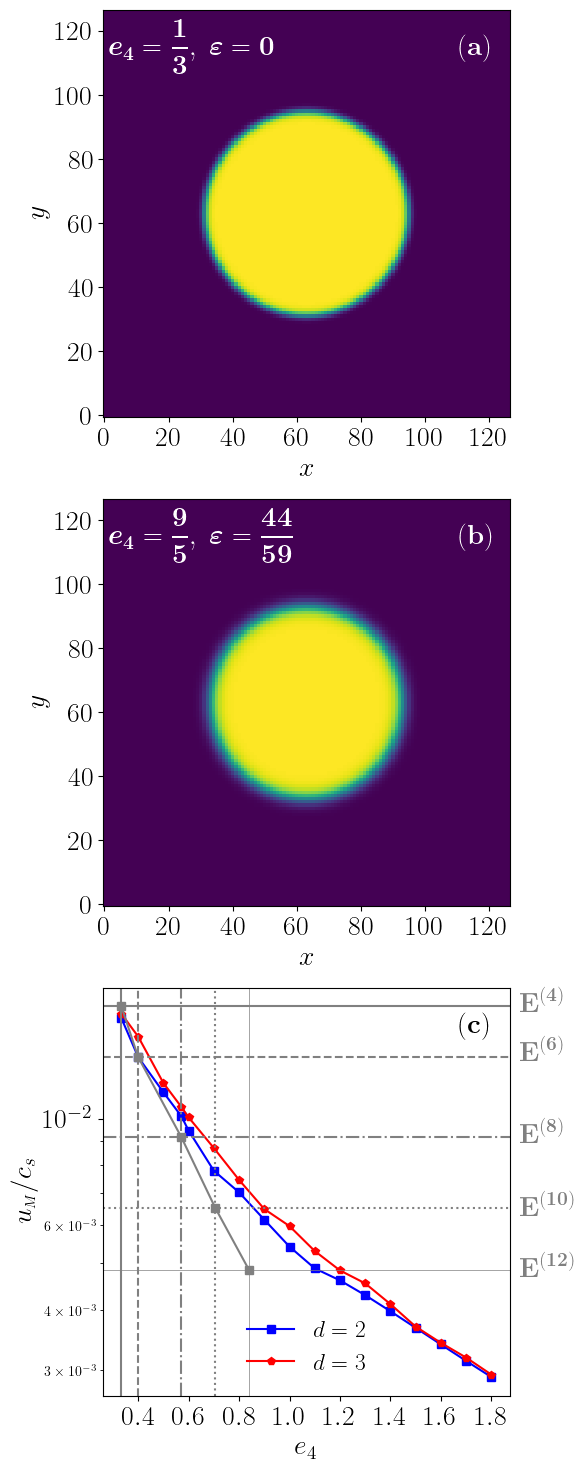

In [8]:
root_dir_fig = Path('./reproduced-figures/')
if not root_dir_fig.is_dir():
    root_dir_fig.mkdir()

import matplotlib

from idpy.Utils.Plots import SetAxPanelLabelCoords, SetMatplotlibLatexParamas, SetDefaultFonts
from idpy.Utils.Plots import CreateFiguresPanels, SetAxPanelLabel, SetAxTicksFont
from matplotlib import rc, rcParams

print(rcParams['text.latex.preamble'])

SetMatplotlibLatexParamas([rc], [rcParams])
# rcParams['text.latex.preamble']='\\usepackage{amsmath}'
fonts = SetDefaultFonts([rc])
fonts['fs'] = 25

fs, ms_small, ms_large, ms_large_c = 20, 7, 8, 20

nx_fig, ny_fig = 1, 3

mult = 1.5
fig = CreateFiguresPanels(_nx=nx_fig,_ny=ny_fig, _x_size=3.5 * mult, _y_size=4 * mult)

if True:
    ax_n0 = plt.subplot2grid((ny_fig, nx_fig), (0, 0), colspan = 1, rowspan = 1)
    ax_n0.imshow(n_fields_2d[0], origin='lower')
    ax_n0.set_xlabel('$x$', fontsize = fs)
    ax_n0.set_ylabel('$y$', fontsize = fs)

    SetAxPanelLabel(ax=ax_n0, label='$$ \\boldsymbol{e_4}=\\mathbf{\\frac{1}{3}},\;\\boldsymbol{\\varepsilon} = \mathbf{0}$$', 
                    fs=fs, color='white', x_pos = 0.015, y_pos = 0.89)
    SetAxPanelLabel(ax=ax_n0, label='$\mathbf{(a)}$', 
                    fs=fs, color='white', x_pos = 0.875, y_pos = 0.89)    
    # SetAxPanelLabel(ax=ax_n0, label='$$ \\boldsymbol{\\xi} $$', fs=fs, color='white')

    for tick in ax_n0.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_n0.get_yticklabels():
        tick.set_fontsize(fs)

if True:
    ax_n1 = plt.subplot2grid((ny_fig, nx_fig), (1, 0), colspan = 1, rowspan = 1)
    ax_n1.imshow(n_fields_2d[-1], origin='lower')
    ax_n1.set_xlabel('$x$', fontsize = fs)
    ax_n1.set_ylabel('$y$', fontsize = fs)

    SetAxPanelLabel(ax=ax_n1, label='$$ \\boldsymbol{e_4}=\mathbf{\\frac{9}{5}},\;\\boldsymbol{\\varepsilon} = \mathbf{\\frac{44}{59}}$$', 
                    fs=fs, color='white', x_pos = 0.015, y_pos = 0.89)
    SetAxPanelLabel(ax=ax_n1, label='$\mathbf{(b)}$', 
                    fs=fs, color='white', x_pos = 0.875, y_pos = 0.89)    

    for tick in ax_n1.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_n1.get_yticklabels():
        tick.set_fontsize(fs)

if True:
    ## Need to simulate this values as well!
    u_max_D2E4 = np.mean(maxu_2d_std[D2E4_std])
    u_max_D2E6 = np.mean(maxu_2d_std[D2E6_std])
    u_max_D2E8 = np.mean(maxu_2d_std[D2E8_std])
    u_max_D2E10 = np.mean(maxu_2d_std[D2E10_std])
    u_max_D2E12 = np.mean(maxu_2d_std[D2E12_std])

    # u_max_D2E4 = 0.017143
    # u_max_D2E6 = 0.01343932
    # u_max_D2E8 = 0.0091465
    # u_max_D2E10 = 0.00651546
    # u_max_D2E12 = 0.00484344

    all_iso_data_u_max = [u_max_D2E4, u_max_D2E6, u_max_D2E8, u_max_D2E10, u_max_D2E12]
    all_iso_data_e4 = [1/3, 2/5, 4/7, 12/17, 120/143]

    ax_umax = plt.subplot2grid((ny_fig, nx_fig), (2, 0), colspan = 1, rowspan = 1)
    ax_umax.plot(e4_values, plt_maxu_2d, marker='s', color='blue', label='$d=2$')
    ax_umax.plot(e4_values, plt_maxu_3d, marker='p', color='red', label='$d=3$')

    ax_umax.set_xlabel('$e_4$', fontsize = fs)
    ax_umax.set_ylabel('$u_{\\scriptscriptstyle{M}} / c_s$', fontsize = fs)

    ax_umax.set_yscale('log')
    ax_umax.legend(frameon = False, loc = 'lower center')

    ax_umax.axvline(x=1/3, color='grey', linestyle='-')
    ax_umax.axhline(y=u_max_D2E4, color='grey', linestyle='-')
    ax_umax.plot([1/3], [u_max_D2E4], marker='s', color='gray')

    ax_umax.axvline(x=2/5, color='grey', linestyle='--')
    ax_umax.axhline(y=u_max_D2E6, color='grey', linestyle='--')
    ax_umax.plot([2/5], [u_max_D2E6], marker='s', color='gray')

    ax_umax.axvline(x=4/7, color='grey', linestyle='-.')
    ax_umax.axhline(y=u_max_D2E8, color='grey', linestyle='-.')
    ax_umax.plot([4/7], [u_max_D2E8], marker='s', color='gray')

    ax_umax.axvline(x=12/17, color='grey', linestyle=':')
    ax_umax.axhline(y=u_max_D2E10, color='grey', linestyle=':')
    ax_umax.plot([12/17], [u_max_D2E10], marker='s', color='gray')

    ax_umax.axvline(x=120/143, color='grey', linestyle='-', linewidth=0.5)
    ax_umax.axhline(y=u_max_D2E12, color='grey', linestyle='-', linewidth=0.5)
    ax_umax.plot([120/143], [u_max_D2E12], marker='s', color='gray')

    ax_umax.plot(all_iso_data_e4, all_iso_data_u_max, color='gray')

    SetAxPanelLabel(ax=ax_umax, label='$$ \\mathbf{E^{(4)}}$$', 
                    fs=fs, color='gray', x_pos = 1.025, y_pos = 0.94)
    SetAxPanelLabel(ax=ax_umax, label='$$ \\mathbf{E^{(6)}}$$', 
                    fs=fs, color='gray', x_pos = 1.025, y_pos = 0.82)
    SetAxPanelLabel(ax=ax_umax, label='$$ \\mathbf{E^{(8)}}$$', 
                    fs=fs, color='gray', x_pos = 1.025, y_pos = 0.62)
    SetAxPanelLabel(ax=ax_umax, label='$$ \\mathbf{E^{(10)}}$$', 
                    fs=fs, color='gray', x_pos = 1.025, y_pos = 0.44)
    SetAxPanelLabel(ax=ax_umax, label='$$ \\mathbf{E^{(12)}}$$', 
                    fs=fs, color='gray', x_pos = 1.025, y_pos = 0.29)
    SetAxPanelLabel(ax=ax_umax, label='$\mathbf{(c)}$', 
                    fs=fs, x_pos = 0.875, y_pos = 0.89)    

    for tick in ax_umax.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_umax.get_yticklabels():
        tick.set_fontsize(fs)

plt.savefig(root_dir_fig / 'u_max_e4.pdf', bbox_inches = 'tight', dpi = 300)

## Table II

In [9]:
"""
Computing custom stencils: 3d
"""

it3d_custom_reference = \
    InterfaceTuning3D(root_vectors_3d = [(1, 0, 0), (1, 1, 0), (1, 1, 1), (2, 0, 0), (2, 2, 0)],
                                        l2_list_2d = [1, 2, 4, 5, 8])

sol_ws_dict = \
    it3d_custom_reference.DefineWeights3D(eq_s=[it3d_custom_reference.e2_3d - it3d_custom_reference.e_sym[2], 
                                                it3d_custom_reference.e4_3d - it3d_custom_reference.e_sym[4], 
                                                it3d_custom_reference.I40_3d - it3d_custom_reference.I_sym[(4, 0)], 
                                                it3d_custom_reference.I60_3d - it3d_custom_reference.I_sym[(6, 0)], 
                                                it3d_custom_reference.I61_3d - it3d_custom_reference.I_sym[(6, 1)]])



sol_ws_list = [sol_ws_dict[w] for w in sol_ws_dict]
it3d_custom_reference.PushWeights3D(sol_ws_list)

"""
Computing custom stencils: 2d
"""
it2d_custom_reference = InterfaceTuning2D(l2_list=[1, 2, 4, 8])
it2d_custom_reference.DefineWeights(
    [it2d_custom_reference.e_sym[n] - it2d_custom_reference.e_expr[n] for n in range(2, 4 + 1, 2)] + 
    [it2d_custom_reference.I_sym[(4,0)] - it2d_custom_reference.typ_eq_s[4][0], 
     it2d_custom_reference.I_sym[(6,0)] - it2d_custom_reference.typ_eq_s[6][0]])

"""
Two-dimensional case
"""
w_sol_2d = it2d_custom_reference.w_sol[0]
w_sol_2d_iso_dict = it2d_custom_reference.GetStdIsoDict()
e4_2d_sol = sp.solve(sp.Eq(it2d_custom_reference.hat_sigma_0_sym, it2d_custom_reference.hat_sigma_0_eIs[0]), [it2d_custom_reference.e_sym[4]])[0]
W_2d = {l2: sp.Symbol('W(' + str(l2) + ')') for l2 in it2d_custom_reference.l2_list}

W_2d_sigma = {}
for k, w in enumerate(w_sol_2d):
    w_subs = w.subs({it2d_custom_reference.e_sym[4]: e4_2d_sol})
    w_subs = w_subs.subs(w_sol_2d_iso_dict)
    W_2d_sigma[it2d_custom_reference.l2_list[k]] = sp.latex(w_subs)


"""
Three-dimensional case
"""
w_sol_3d = it3d_custom_reference.tuning_w_sol_list_3d
w_sol_3d_iso_dict = it3d_custom_reference.GetStdIsoDict()

l2_list_3d = np.sum(np.array(it3d_custom_reference.root_vectors_3d) ** 2, axis=1).tolist()
W_3d = {l2: sp.Symbol('W(' + str(l2) + ')') for l2 in l2_list_3d}

"""
We can use the same solution as in the two-dimensional case because the 3d stencil exactly projects on the 2d one
"""
W_3d_sigma = {}
for k, w in enumerate(w_sol_3d):
    w_subs = w.subs({it3d_custom_reference.e_sym[4]: e4_2d_sol})
    w_subs = w_subs.subs(w_sol_3d_iso_dict)
    W_3d_sigma[l2_list_3d[k]] = sp.latex(w_subs)

# W_2d, W_2d_sigma, W_3d, W_3d_sigma

## Generating the table

from IPython.display import display, Latex

N_2d = len(it2d_custom_reference.GetWeightsStencilSol({}).PushStencil()['Es'])
N_3d = len(it3d_custom_reference.GetWeightsStencilSol3D({})['XIs'])

table_II = r"""
\begin{array}{lcc}
& d = 2 & d = 3 \\""" + r""" &  & \\ 
\hline \\
""" + str(W_3d[1]) + r""" & """ + W_2d_sigma[1] + r""" & """ + W_3d_sigma[1] + r""" \\
""" + str(W_3d[2]) + r""" & """ + W_2d_sigma[2] + r""" & """ + W_3d_sigma[2] + r""" \\
""" + str(W_3d[3]) + r""" & - & """ + W_3d_sigma[3] + r""" \\
""" + str(W_3d[4]) + r""" & """ + W_2d_sigma[4] + r""" & """ + W_3d_sigma[4] + r""" \\
""" + str(W_3d[8]) + r""" & """ + W_2d_sigma[8] + r""" & """ + W_3d_sigma[8] + r""" \\
N_e & """ + str(N_2d) + r""" & """ + str(N_3d) + r""" \\
\end{array}
"""

display(Latex(table_II))
print(table_II)

<IPython.core.display.Latex object>


\begin{array}{lcc}
& d = 2 & d = 3 \\ &  & \\ 
\hline \\
W(1) & \frac{4 \hat{\sigma}_0}{3} + \frac{8}{15} & \frac{2 \hat{\sigma}_0}{3} + \frac{4}{15} \\
W(2) & \frac{1}{15} - \frac{\hat{\sigma}_0}{6} & \frac{\hat{\sigma}_0}{3} + \frac{2}{15} \\
W(3) & - & - \frac{\hat{\sigma}_0}{4} - \frac{1}{30} \\
W(4) & - \frac{5 \hat{\sigma}_0}{24} - \frac{1}{30} & - \frac{\hat{\sigma}_0}{6} - \frac{1}{40} \\
W(8) & - \frac{\hat{\sigma}_0}{48} - \frac{1}{240} & - \frac{\hat{\sigma}_0}{48} - \frac{1}{240} \\
N_e & 16 & 44 \\
\end{array}



## Results V.B: Higher-order surface tension tuning - $\hat{\sigma}_1$

### Table III

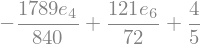

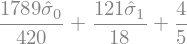

- \frac{1789 e_{4}}{840} + \frac{121 e_{6}}{72} + \frac{4}{5}
\frac{1789 \hat{\sigma}_0}{420} + \frac{121 \hat{\sigma}_1}{18} + \frac{4}{5}



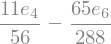

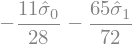

\frac{11 e_{4}}{56} - \frac{65 e_{6}}{288}
- \frac{11 \hat{\sigma}_0}{28} - \frac{65 \hat{\sigma}_1}{72}



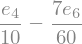

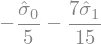

\frac{e_{4}}{10} - \frac{7 e_{6}}{60}
- \frac{\hat{\sigma}_0}{5} - \frac{7 \hat{\sigma}_1}{15}



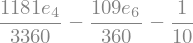

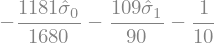

\frac{1181 e_{4}}{3360} - \frac{109 e_{6}}{360} - \frac{1}{10}
- \frac{1181 \hat{\sigma}_0}{1680} - \frac{109 \hat{\sigma}_1}{90} - \frac{1}{10}



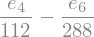

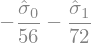

\frac{e_{4}}{112} - \frac{e_{6}}{288}
- \frac{\hat{\sigma}_0}{56} - \frac{\hat{\sigma}_1}{72}



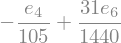

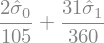

- \frac{e_{4}}{105} + \frac{31 e_{6}}{1440}
\frac{2 \hat{\sigma}_0}{105} + \frac{31 \hat{\sigma}_1}{360}



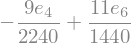

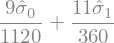

- \frac{9 e_{4}}{2240} + \frac{11 e_{6}}{1440}
\frac{9 \hat{\sigma}_0}{1120} + \frac{11 \hat{\sigma}_1}{360}



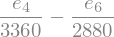

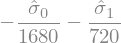

\frac{e_{4}}{3360} - \frac{e_{6}}{2880}
- \frac{\hat{\sigma}_0}{1680} - \frac{\hat{\sigma}_1}{720}



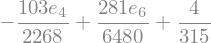

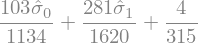

- \frac{103 e_{4}}{2268} + \frac{281 e_{6}}{6480} + \frac{4}{315}
\frac{103 \hat{\sigma}_0}{1134} + \frac{281 \hat{\sigma}_1}{1620} + \frac{4}{315}



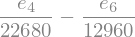

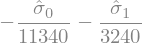

\frac{e_{4}}{22680} - \frac{e_{6}}{12960}
- \frac{\hat{\sigma}_0}{11340} - \frac{\hat{\sigma}_1}{3240}



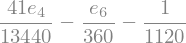

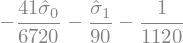

\frac{41 e_{4}}{13440} - \frac{e_{6}}{360} - \frac{1}{1120}
- \frac{41 \hat{\sigma}_0}{6720} - \frac{\hat{\sigma}_1}{90} - \frac{1}{1120}



In [10]:
it3d_custom_reference = \
    InterfaceTuning3D(root_vectors_3d = [(1, 0, 0), (1, 1, 0), (1, 1, 1), (2, 0, 0), 
                                         (2, 1, 0), (2, 1, 1), (2, 2, 0), (2, 2, 1), 
                                         (3, 0, 0), (3, 3, 0), (4, 0, 0)], 
                                         l2_list_2d = [1, 2, 4, 5, 8, 9, 16, 18])

def From2DTO3D_Final(itclass, expr=None):
    dict_transf = {itclass.w_sym[1]: itclass.w_syms_list[0] + 2 * itclass.w_syms_list[1] + 2 * itclass.w_syms_list[4], 
                   itclass.w_sym[2]: itclass.w_syms_list[1] + 2 * itclass.w_syms_list[2] + 2 * itclass.w_syms_list[5], 
                   itclass.w_sym[4]: itclass.w_syms_list[3] + 2 * itclass.w_syms_list[4] + 2 * itclass.w_syms_list[6], 
                   itclass.w_sym[5]: itclass.w_syms_list[4] + 2 * itclass.w_syms_list[5] + 2 * itclass.w_syms_list[7], 
                   itclass.w_sym[8]: itclass.w_syms_list[6] + 2 * itclass.w_syms_list[7],
                   itclass.w_sym[9]: itclass.w_syms_list[8] + 2 * itclass.w_syms_list[9],
                   itclass.w_sym[16]: itclass.w_syms_list[10],
                   itclass.w_sym[18]: itclass.w_syms_list[9]}

    if expr is None:
        return dict_transf
    else:
        for WS in dict_transf:
            expr = expr.subs(WS, dict_transf[WS])
        return expr
    
it3d_custom_reference.DefineWeights3DTYP0(From2DTO3D_Final)

sol_ws_dict = \
    it3d_custom_reference.DefineWeights3D(eq_s=[it3d_custom_reference.e2_3d - it3d_custom_reference.e_sym[2], 
                                                it3d_custom_reference.e4_3d - it3d_custom_reference.e_sym[4], 
                                                it3d_custom_reference.e6_3d - it3d_custom_reference.e_sym[6], 
                                                it3d_custom_reference.I40_3d - it3d_custom_reference.I_sym[(4, 0)], 
                                                it3d_custom_reference.I60_3d - it3d_custom_reference.I_sym[(6, 0)], 
                                                it3d_custom_reference.I61_3d - it3d_custom_reference.I_sym[(6, 1)], 
                                                it3d_custom_reference.I80_3d - it3d_custom_reference.I_sym[(8, 0)], 
                                                it3d_custom_reference.I81_3d - it3d_custom_reference.I_sym[(8, 1)], 
                                                it3d_custom_reference.I82_3d - it3d_custom_reference.I_sym[(8, 2)], 
                                                it3d_custom_reference.I101_3d - it3d_custom_reference.I_sym[(10, 1)], 
                                                it3d_custom_reference.I102_3d - it3d_custom_reference.I_sym[(10, 2)]])

sol_ws_list = [sol_ws_dict[w] for w in sol_ws_dict]
it3d_custom_reference.PushWeights3D(sol_ws_list)

eqs = [sp.Eq(it3d_custom_reference.hat_sigma_0_sym, it3d_custom_reference.hat_sigma_0_eIs_3d[0]),
       sp.Eq(it3d_custom_reference.hat_sigma_1_sym, it3d_custom_reference.hat_sigma_0_eIs_3d[1])]

sol_hats_dict = sp.solve(eqs, [it3d_custom_reference.e_sym[4], it3d_custom_reference.e_sym[6]])
iso_dict = it3d_custom_reference.GetStdIsoDict()

_ = it3d_custom_reference.GetWeightsStencilSol3D({})

for w in it3d_custom_reference.w_sol_iso_list:
    w_hats = w.subs(sol_hats_dict)
    w_hats = w_hats.subs(iso_dict)
    display(w, w_hats)
    print(sp.latex(w))
    print(sp.latex(w_hats))
    print()

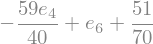

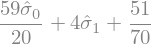

- \frac{59 e_{4}}{40} + e_{6} + \frac{51}{70}
\frac{59 \hat{\sigma}_0}{20} + 4 \hat{\sigma}_1 + \frac{51}{70}



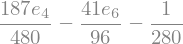

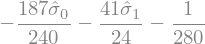

\frac{187 e_{4}}{480} - \frac{41 e_{6}}{96} - \frac{1}{280}
- \frac{187 \hat{\sigma}_0}{240} - \frac{41 \hat{\sigma}_1}{24} - \frac{1}{280}



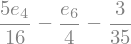

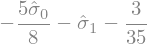

\frac{5 e_{4}}{16} - \frac{e_{6}}{4} - \frac{3}{35}
- \frac{5 \hat{\sigma}_0}{8} - \hat{\sigma}_1 - \frac{3}{35}



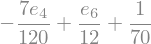

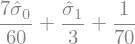

- \frac{7 e_{4}}{120} + \frac{e_{6}}{12} + \frac{1}{70}
\frac{7 \hat{\sigma}_0}{60} + \frac{\hat{\sigma}_1}{3} + \frac{1}{70}



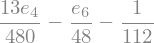

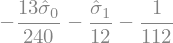

\frac{13 e_{4}}{480} - \frac{e_{6}}{48} - \frac{1}{112}
- \frac{13 \hat{\sigma}_0}{240} - \frac{\hat{\sigma}_1}{12} - \frac{1}{112}



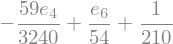

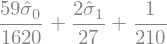

- \frac{59 e_{4}}{3240} + \frac{e_{6}}{54} + \frac{1}{210}
\frac{59 \hat{\sigma}_0}{1620} + \frac{2 \hat{\sigma}_1}{27} + \frac{1}{210}



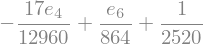

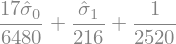

- \frac{17 e_{4}}{12960} + \frac{e_{6}}{864} + \frac{1}{2520}
\frac{17 \hat{\sigma}_0}{6480} + \frac{\hat{\sigma}_1}{216} + \frac{1}{2520}



In [11]:
"""
Defining the custom reference stencil: 2d
"""
it2d_custom_reference = InterfaceTuning2D(l2_list=[1, 2, 4, 5, 8, 9, 18])
it2d_custom_reference.DefineWeights(
    [it2d_custom_reference.e_sym[n] - it2d_custom_reference.e_expr[n] for n in range(2, 6 + 1, 2)] + 
    [it2d_custom_reference.I_sym[(4,0)] - it2d_custom_reference.typ_eq_s[4][0], 
     it2d_custom_reference.I_sym[(6,0)] - it2d_custom_reference.typ_eq_s[6][0], 
     it2d_custom_reference.I_sym[(8,0)] - it2d_custom_reference.typ_eq_s[8][0], 
     it2d_custom_reference.I_sym[(8,1)] - it2d_custom_reference.typ_eq_s[8][1]])

eqs = [sp.Eq(it2d_custom_reference.hat_sigma_0_sym, it2d_custom_reference.hat_sigma_0_eIs[0]),
       sp.Eq(it2d_custom_reference.hat_sigma_1_sym, it2d_custom_reference.hat_sigma_0_eIs[1])]

sol_hats_dict = sp.solve(eqs, [it2d_custom_reference.e_sym[4], it2d_custom_reference.e_sym[6]])
iso_dict = it2d_custom_reference.GetStdIsoDict()

for w in it2d_custom_reference.GetWeightsStencilSol({}).w_sol[0]:
#     display(w.subs({}))
#     print(sp.latex(w))
#     print()
    w_hats = w.subs(sol_hats_dict)
    w_hats = w_hats.subs(iso_dict)
    display(w, w_hats)
    print(sp.latex(w))
    print(sp.latex(w_hats))
    print()

### Simulations

#### Preparing simulations variables

In [12]:
from idpy.IdpyCode import OCL_T, CUDA_T, CTYPES_T
set_lang, set_device, set_kind = CUDA_T, 0, 'gpu'

In [13]:
e4_val = sp.Rational(1, 3)
e6_val = sp.Pow(e4_val, sp.Rational(3, 2))

In [14]:
n, eps = sp.Symbol('n'), sp.Symbol('\\varepsilon')
psis = [sp.exp(-1/n), sp.Pow((n / (eps + n)), 1 / eps)]

n_s_lambdas = {psis[0]: lambda G_val: SpinodalPsi(G_val, psis[0], n),
               psis[1]: lambda psi_sym: lambda G_val: SpinodalPsi(G_val, psi_sym, n)}

psi_codes = {psis[0]: 'exp((NType)(-1./ln_0))', 
             psis[1]: lambda eps_val: 'pow((ln_0 / (' + str(float(eps_val)) + ' + ln_0)), ' + str(float(1 / eps_val)) + ')'}

In [15]:
"""
Defining the custom reference stencil: 2d
"""
it2d_custom_reference = InterfaceTuning2D(l2_list=[1, 2, 4, 5, 8, 9, 18])
it2d_custom_reference.DefineWeights(
    [it2d_custom_reference.e_sym[n] - it2d_custom_reference.e_expr[n] for n in range(2, 6 + 1, 2)] + 
    [it2d_custom_reference.I_sym[(4,0)] - it2d_custom_reference.typ_eq_s[4][0], 
     it2d_custom_reference.I_sym[(6,0)] - it2d_custom_reference.typ_eq_s[6][0], 
     it2d_custom_reference.I_sym[(8,0)] - it2d_custom_reference.typ_eq_s[8][0], 
     it2d_custom_reference.I_sym[(8,1)] - it2d_custom_reference.typ_eq_s[8][1]])

eqs = [sp.Eq(it2d_custom_reference.hat_sigma_0_sym, it2d_custom_reference.hat_sigma_0_eIs[0]),
       sp.Eq(it2d_custom_reference.hat_sigma_1_sym, it2d_custom_reference.hat_sigma_0_eIs[1])]

sol_hats_dict = sp.solve(eqs, [it2d_custom_reference.e_sym[4], it2d_custom_reference.e_sym[6]])
iso_dict = it2d_custom_reference.GetStdIsoDict()

hat_sigma_0_ref = it2d_custom_reference.hat_sigma_0_eIs[0].subs({**iso_dict, 
                                                                 it2d_custom_reference.e_sym[4]: e4_val, 
                                                                 it2d_custom_reference.e_sym[6]: e6_val})

hat_sigma_1_ref = it2d_custom_reference.hat_sigma_0_eIs[1].subs({**iso_dict, 
                                                                 it2d_custom_reference.e_sym[4]: e4_val, 
                                                                 it2d_custom_reference.e_sym[6]: e6_val})

#### $\Delta \hat{T} = 0.1$

In [16]:
G_eps = 0.1

psi_sym = psis[0]
G_sym = sp.Symbol('G')
pb_sym = n / 3 + G_sym * (psi_sym ** 2) / 2

n_c, G_c = sp.solve([sp.Eq(sp.diff(pb_sym, (n, 1)), 0), sp.Eq(sp.diff(pb_sym, (n, 2)), 0)], [n, G_sym])[0]
print("Pseudopotential:")
display(psi_sym)
print()
print("Critical coupling:", G_c, "Critical density:", n_c)

G_val = G_c * (G_eps + 1)

ns_g, ns_l = SpinodalPsi(G_val, psi_sym, n, n_min=1e-1)
pb_lam = sp.lambdify([n], pb_sym.subs(G_sym, G_val))

MEAInteg_lam = lambda p: MaxwellEqualAreaIntegral(p, G_val, psi_sym, n, ns_g, ns_l, pb_lam)

p0_eq, steps_count = MyNewton(pb_lam(ns_l) * (1 + 1e-2) if pb_lam(ns_l) > 0 else 0,  pb_lam(ns_g) * (1 - 1e-2), MEAInteg_lam)
ng_eq, nl_eq = \
    FindDensityFromPressure(G_val, psi_sym, n, p0_eq, (ns_g, ns_l), branch='n_g', exp_2 = 11, n_max=2.5), \
    FindDensityFromPressure(G_val, psi_sym, n, p0_eq, (ns_g, ns_l), branch='n_l', exp_2 = 11, n_max=3)

print("Check Pressure:", p0_eq, pb_lam(ng_eq), pb_lam(nl_eq))
print("Density ratio:", nl_eq/ng_eq, nl_eq, ng_eq)

eq_params = {'n_l': nl_eq, 'n_g': ng_eq, 'n_l': nl_eq, 'sigma_f': None, 'G_c': G_c, 'n_c': n_c, 'p_0': p0_eq}


"""
Using a common value for the flat surface tension for initializing the densities
"""
dpsi2_lam = lambda n_val: MaxwellProfilePsiD2(n_val, eq_params['n_g'], eq_params['p_0'], 0, G_val, pb_lam)

dpsi_sym = sp.diff(psi_sym, (n, 1))
dpsi_lam = sp.lambdify([n], dpsi_sym)
psi_lam = sp.lambdify([n], psi_sym)

d2psi_lam = \
    lambda n_val: (1 / (2 * psi_lam(n_val))) * (float(0) * dpsi2_lam(n_val) + 
                   (8 * ((1 - float(0)) / G_val.evalf()) * (eq_params['p_0'] - pb_lam(n_val))))

n_range = np.linspace(eq_params['n_l'] * (1 - 9e-4), eq_params['n_g'] * (1 + 5e-9), 2 ** 13)
print("Debug - the derivative values should both be positive - avoid negative square root:", dpsi2_lam(n_range[0]), dpsi2_lam(n_range[-1]))
dn_int = np.abs(n_range[1] - n_range[0])

Sigma_11 = np.sum(np.array([dpsi_lam(n_val) * np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])) * dn_int
Sigma_22 = np.sum(np.array([dpsi_lam(n_val) * (np.float64(d2psi_lam(n_val)) ** 2) / np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])) * dn_int

sigma_flat_value = np.float64(G_val * ((-e4_val / 2) * Sigma_11))
eq_params['sigma_f'] = sigma_flat_value

print()
print("sigma_f:", eq_params['sigma_f'])
print()

x_range, psi_range, n_range = GetPsiProfile(eq_params['n_c'] * 5e-5, psi_sym, n, eq_params, kickstart=8e-4) ## 0.1
dpsi_analytical = np.array([np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])
d2psi_analytical = np.array([d2psi_lam(n_val) for n_val in n_range])

Pseudopotential:



Critical coupling: -exp(2)/3 Critical density: 1
0.14342519638968998 0.15431774886567304 -0.008867459194005963 0.0039033164418575675
Check Pressure: 0.15064519616599917 0.15064519616599933 0.1506451961659998
Density ratio: 2.967539205440223 1.736511351752766 0.5851687986360272
Debug - the derivative values should both be positive - avoid negative square root: 1.65088602368528e-8 2.73175090410782e-18

sigma_f: 0.009715674182863211

22989


In [17]:
from pathlib import Path

root_dir_res = Path('./reproduced-results/')
if not root_dir_res.is_dir():
    root_dir_res.mkdir()

def GetFileNameSigma1(G_eps, DSigma, dim_sizes, kind):
    name_str = "Sigma1Tuning_" + "{:.4f}".format(G_eps) + '_' + "{:.4f}".format(DSigma) + '_' + str(dim_sizes) + '_' + str(kind)
    return name_str + '.hdf5'

from idpy.Utils.ManageData import ManageData

def ReadDensity(file_name, dim_sizes):
    file_name = str(file_name)
    md = ManageData(dump_file=file_name)
    n_strip = md.ReadHDF5(full_key='/ShanChenMultiPhase/idpy_memory/n', class_check_override=True)
    return n_strip.reshape(np.flip(dim_sizes))

from InterfaceTuning import GetSigma0, GetSigma1
from LatticePressureTensor import LPT_16_2D

def Analyze2DFlatSigma1(n_field, dim_sizes, stencil, psi_sym, n_sym):
    """
    Getting the realized densities
    """
    n_strip = n_field[0,:]

    """
    Getting Sigmas and Deltas to show the change in the higher order properties of the interface
    """
    xr_fine_sigma, dx_psi_2, Sigma0 = GetSigma0(n_strip, psi_sym, n_sym)
    xr_fine_sigma, d2x_psi_2, Sigma1 = GetSigma1(n_strip, psi_sym, n_sym)

    """
    Getting components of the lattice pressure tensor
    """
    
    p_n = LPT_16_2D(G, n_field, stencil.PushStencil(), psi_sym, n_sym)['LPT'][dim_sizes[1]//2,:,0]
    p_t = LPT_16_2D(G, n_field, stencil.PushStencil(), psi_sym, n_sym)['LPT'][dim_sizes[1]//2,:,2]
    p_nmt_spl = UnivariateSpline(np.arange(len(p_n)), p_n - p_t, s=0)

    """
    Estimating surface tension and position of the surface of tension
    """
    sigma_p_nmt = p_nmt_spl.integral(0, dim_sizes[0]//2)

    return {'x_range': np.arange(len(p_n)), 'p_n': p_nmt_spl, 'sigma_p_nmt': sigma_p_nmt, 
            'Sigma0': Sigma0, 'Sigma1': Sigma1}


prefactor = (hat_sigma_0_ref * Sigma_11 + hat_sigma_1_ref * Sigma_22) / (Sigma_22)

for DSigma in [0,
               0.05, 0.1, 0.15, 0.2, 0.25,
               -0.05, -0.1, -0.15, -0.2, -0.25]:
    e6_tuned = e6_val + 4 * prefactor * DSigma

    tuned_stencil_2d = \
        it2d_custom_reference.GetWeightsStencilSol({it2d_custom_reference.e_sym[4]: e4_val, 
                                                    it2d_custom_reference.e_sym[6]: e6_tuned})

    G = float(G_val)

    dim_sizes = (128, 32)   
    dump_file_name = root_dir_res / Path(GetFileNameSigma1(np.float64(G_eps), DSigma, dim_sizes, 'flat'))
    print(dump_file_name, dump_file_name.is_file())

    if not dump_file_name.is_file():
        IT_sim = InterfaceTuningSims(lang=set_lang, device=set_device, cl_kind=set_kind, dim_sizes=dim_sizes)

        IT_sim.RunFlat(
            f_stencil=tuned_stencil_2d.PushStencil(),
            n_g=eq_params['n_g'], n_l=eq_params['n_l'], 
            # G=G, psi_sym=psi_sym, psi_code=psi_codes[psis[2]](float(eps_val)),
            G=G, psi_sym=psi_sym, psi_code=psi_codes[psis[0]],
            dump_name=dump_file_name)

    n_strip = ReadDensity(dump_file_name, dim_sizes)[0,:]
    n_field = ReadDensity(dump_file_name, dim_sizes)
    print("\delta n_g:", np.amin(n_strip) / eq_params['n_g'], "\delta n_l:", np.amax(n_strip) / eq_params['n_l'])

    flat_properties_tune = Analyze2DFlatSigma1(n_field, dim_sizes, tuned_stencil_2d, psi_sym, n)
    for _ in flat_properties_tune:
        print(_, flat_properties_tune[_])

reproduced-results/Sigma1Tuning_0.1000_0.0000_(128, 32)_flat.hdf5 True
\delta n_g: 0.9991332576421781 \delta n_l: 0.9995608587233766
(0, 0)
(1, 1)
(0, 0)
(1, 1)
x_range [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]
p_n <scipy.interpolate._fitpack2.InterpolatedUnivariateSpline object at 0x796057fa8af0>
sigma_p_nmt 0.00963884645395126
Sigma0 0.02226162538381882
Sigma1 0.003839809279227443
reproduced-results/Sigma1Tuning_0.1000_0.0500_(128, 32)_flat.hdf5 True
\delta n_g: 1.000504137020952 \delta n_l: 1.000254124893064
(0, 

### Reading Data

In [18]:
flat_profiles_G0p1 = {}
flat_sigma_G0p1, flat_DSigmas_G0p1 = [], []

"""
- Make three simulation values per dimension per temperature: \Delta=0,min,max
- Make more simulations for the flat interface showing profile, bulk densities, and derivatives
"""

for DSigma in [0,
               0.05, 0.1, 0.15, 0.2, 0.25,
               -0.05, -0.1, -0.15, -0.2, -0.25]:
    e6_tuned = e6_val + 4 * prefactor * DSigma

    tuned_stencil_2d = \
        it2d_custom_reference.GetWeightsStencilSol({it2d_custom_reference.e_sym[4]: e4_val, 
                                                    it2d_custom_reference.e_sym[6]: e6_tuned})

    dim_sizes = (128, 32)   
    dump_file_name = root_dir_res / Path(GetFileNameSigma1(np.float64(G_eps), DSigma, dim_sizes, 'flat'))
    print(dump_file_name, dump_file_name.is_file())

    n_strip = ReadDensity(dump_file_name, dim_sizes)[0,:]
    n_field = ReadDensity(dump_file_name, dim_sizes)
    print("\delta n_g:", np.amin(n_strip) / eq_params['n_g'], "\delta n_l:", np.amax(n_strip) / eq_params['n_l'])

    flat_properties_tune = Analyze2DFlatSigma1(n_field, dim_sizes, tuned_stencil_2d, psi_sym, n)
    for _ in flat_properties_tune:
        print(_, flat_properties_tune[_])

    flat_profiles_G0p1[DSigma] = n_strip
    flat_sigma_G0p1 += [flat_properties_tune['sigma_p_nmt']]
    flat_DSigmas_G0p1 += [DSigma]

flat_sigma_G0p1, flat_DSigmas_G0p1 = \
    np.array(flat_sigma_G0p1), np.array(flat_DSigmas_G0p1)

reproduced-results/Sigma1Tuning_0.1000_0.0000_(128, 32)_flat.hdf5 True
\delta n_g: 0.9991332576421781 \delta n_l: 0.9995608587233766
(0, 0)
(1, 1)
(0, 0)
(1, 1)
x_range [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]
p_n <scipy.interpolate._fitpack2.InterpolatedUnivariateSpline object at 0x7960519c4220>
sigma_p_nmt 0.00963884645395126
Sigma0 0.02226162538381882
Sigma1 0.003839809279227443
reproduced-results/Sigma1Tuning_0.1000_0.0500_(128, 32)_flat.hdf5 True
\delta n_g: 1.000504137020952 \delta n_l: 1.000254124893064
(0, 

### Figure 3

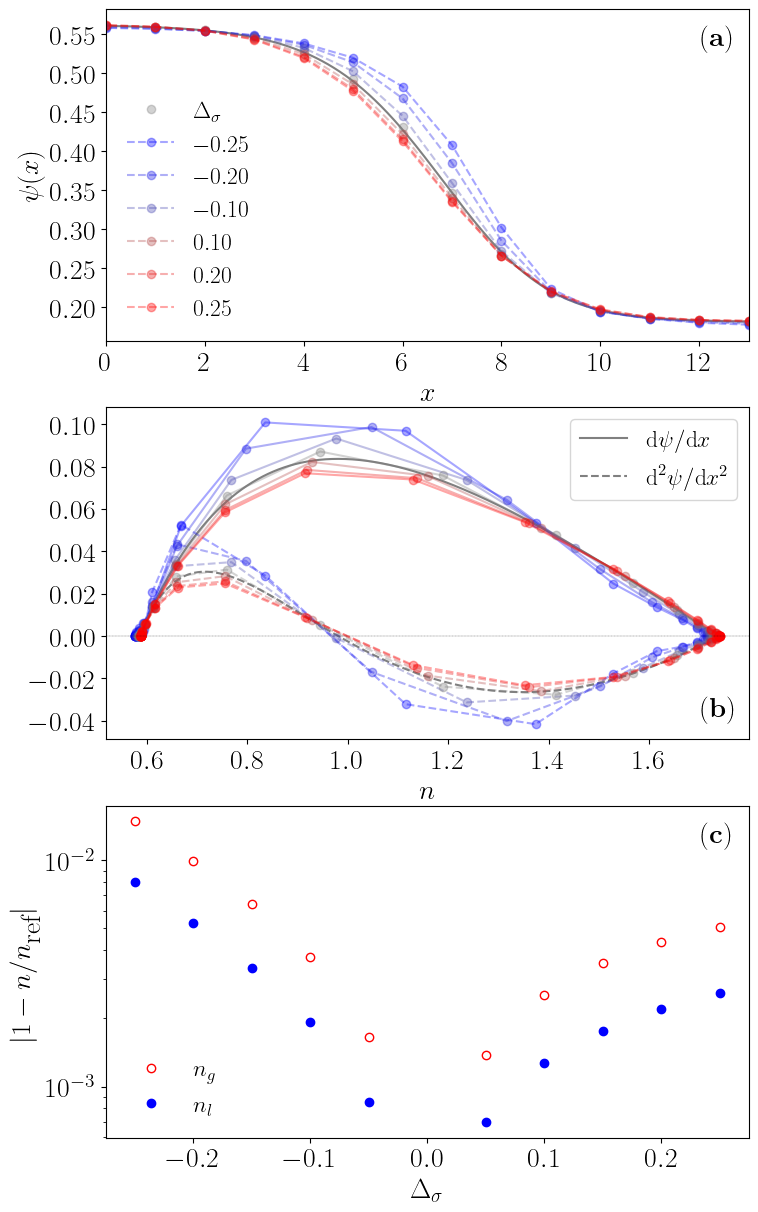

In [19]:
import matplotlib

from idpy.Utils.Plots import SetAxPanelLabelCoords, SetMatplotlibLatexParamas, SetDefaultFonts
from idpy.Utils.Plots import CreateFiguresPanels, SetAxPanelLabel, SetAxTicksFont
from matplotlib import rc, rcParams

from scipy.optimize import curve_fit

SetMatplotlibLatexParamas([rc], [rcParams])
fonts = SetDefaultFonts([rc])
fonts['fs'] = 25

fs, ms_small, ms_large, ms_large_c = 20, 7, 8, 20
fs, ms_small, ms_large, ms_large_c = 20, 7, 6, 20

psi_f = sp.lambdify([n], psi_sym)

colors = ['red', 'blue', 'darkgreen', 'darkorange', 'purple']

cmap_sigma_up = matplotlib.colors.LinearSegmentedColormap.from_list("MyCmapName",["gray","red"])
col_sigma_norm_up = matplotlib.colors.Normalize(vmin = 0, vmax = 0.25)

cmap_sigma_dn = matplotlib.colors.LinearSegmentedColormap.from_list("MyCmapName",["blue","gray"])
col_sigma_norm_dn = matplotlib.colors.Normalize(vmin = -0.25, vmax = 0)

markers = {1: 't', 2: 's', 3: 'p'}
m_opts_drp = {1: {'marker': 't', 'fillstyle': None, 'linestyle': 'none'},
              2: {'marker': 's', 'fillstyle': None, 'linestyle': 'none'}, 
              3: {'marker': 'p', 'fillstyle': None, 'linestyle': 'none'}}

m_opts_bub = {1: {'marker': 't', 'fillstyle': 'none', 'linestyle': 'none'}, 
              2: {'marker': 's', 'fillstyle': 'none', 'linestyle': 'none'}, 
              3: {'marker': 'p', 'fillstyle': 'none', 'linestyle': 'none'}}

m_opts_drp_dash = {1: {'marker': 't', 'fillstyle': None, 'linestyle': '--'},
                   2: {'marker': 's', 'fillstyle': None, 'linestyle': '--'}, 
                   3: {'marker': 'p', 'fillstyle': None, 'linestyle': '--'}}

m_opts_bub_dash = {1: {'marker': 't', 'fillstyle': 'none', 'linestyle': '--'}, 
                   2: {'marker': 's', 'fillstyle': 'none', 'linestyle': '--'}, 
                   3: {'marker': 'p', 'fillstyle': 'none', 'linestyle': '--'}}

get_label = lambda d1: '$' + "{:0.2f}".format(d1) + '$'

nx_fig, ny_fig = 1, 5

y_size, xy_ratio = 4.3, 1.2
fig = CreateFiguresPanels(_nx=nx_fig,_ny=ny_fig, _x_size=8.3, _y_size=5)

############# PROFILE
if True:
    ax_profile = plt.subplot2grid((ny_fig, nx_fig), (0, 0), colspan = 1, rowspan = 1)

    ax_profile.plot(x_range + 87.15, psi_range, color='grey')

    for i, DSigma in enumerate([0][:1]):
        color = cmap_sigma_dn(col_sigma_norm_dn(DSigma))
        n_strip = flat_profiles_G0p1[DSigma]
        ax_profile.plot(np.arange(len(n_strip)), psi_f(n_strip), 
                        marker = 'o', linestyle='none', color=color, 
                        alpha=0.35, markersize=ms_large,
                label='$\Delta_\sigma$')


    # shifts = {-0.5: -1, -0.4: -1, -0.3: -1, -0.2: 0, -0.1: 0}
    shifts = {-0.25: -0, -0.2: -0, -0.1: 0}
    for i, DSigma in enumerate([-0.25, -0.2, -0.1][:3]):
        color = cmap_sigma_dn(col_sigma_norm_dn(DSigma))
        n_strip = flat_profiles_G0p1[DSigma]
        ax_profile.plot(np.arange(len(n_strip)) + shifts[DSigma], psi_f(n_strip), 
                        marker = 'o', linestyle='--', color=color, 
                        alpha=0.35, markersize=ms_large, 
                label=get_label(DSigma))

    shifts = {0.25: 0, 0.2: 0, 0.1: 0}
    for i, DSigma in enumerate([0.1, 0.2, 0.25][:3]):
        color = cmap_sigma_up(col_sigma_norm_up(DSigma))
        n_strip = flat_profiles_G0p1[DSigma]
        ax_profile.plot(np.arange(len(n_strip)), psi_f(n_strip), marker = 'o',
                        linestyle='--', color=color, alpha=0.35, markersize=ms_large,
                label=get_label(DSigma))

    ax_profile.set_xlim([90, 103])
    ax_profile.legend(frameon = False, loc = 'lower left')

    for tick in ax_profile.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_profile.get_yticklabels():
        tick.set_fontsize(fs)

    ax_profile.set_xlabel('$x$', fontsize = fs)
    ax_profile.set_ylabel('$\psi(x)$', fontsize = fs)
    ax_profile.set_xticks(np.arange(90, 103, 2), labels=np.arange(0, 103 - 90, 2))

    SetAxPanelLabel(ax=ax_profile, label='$\mathbf{(a)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.89) 

################## DERIVATIVES
if True:
    ax_dd = plt.subplot2grid((ny_fig, nx_fig), (1, 0), colspan = 1, rowspan = 1)

    ax_dd.plot(n_range, dpsi_analytical, label = '$\mbox{d}\psi/\mbox{d}x$', color='gray')
    ax_dd.plot(n_range, d2psi_analytical, label = '$\mbox{d}^2\psi/\mbox{d}x^2$', color='gray', linestyle='--')

    for i, DSigma in enumerate([-0.25, -0.2, -0.1][:]):
        color = cmap_sigma_dn(col_sigma_norm_dn(DSigma))

        n_strip = flat_profiles_G0p1[DSigma]

        n_data_spl = UnivariateSpline(np.arange(len(n_strip)), n_strip, s=0)
        psi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_f(n_strip), s=0)
        dpsi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_data_spl.derivative()(np.arange(len(n_strip))), s=0)

        x_strip = np.linspace(97 - 12, 97 + 12, 2 ** 10)
        x_strip_int = np.arange(97 - 12, 97 + 12, 1)

        ax_dd.plot(n_data_spl(x_strip_int), -psi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='-', color=color, markersize=ms_large, alpha=0.35)
        ax_dd.plot(n_data_spl(x_strip_int), dpsi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='--', color=color, markersize=ms_large, alpha=0.35)

    for i, DSigma in enumerate([0, 0.1, 0.2, 0.25][:]):
        color = cmap_sigma_up(col_sigma_norm_up(DSigma))

        n_strip = flat_profiles_G0p1[DSigma]

        n_data_spl = UnivariateSpline(np.arange(len(n_strip)), n_strip, s=0)
        psi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_f(n_strip), s=0)
        dpsi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_data_spl.derivative()(np.arange(len(n_strip))), s=0)

        x_strip = np.linspace(97 - 12, 97 + 12, 2 ** 10)
        x_strip_int = np.arange(97 - 12, 97 + 12, 1)

        ax_dd.plot(n_data_spl(x_strip_int), -psi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='-', color=color, markersize=ms_large, alpha=0.35)
        ax_dd.plot(n_data_spl(x_strip_int), dpsi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='--', color=color, markersize=ms_large, alpha=0.35)

    ax_dd.axhline(y=0, color='black', linestyle='--', linewidth=0.2)

    ax_dd.legend()

    for tick in ax_dd.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_dd.get_yticklabels():
        tick.set_fontsize(fs)

    ax_dd.set_xlabel('$n$', fontsize = fs)
    SetAxPanelLabel(ax=ax_dd, label='$\mathbf{(b)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.07) 

################## DENSITIES
if True:
    ax_rhos = plt.subplot2grid((ny_fig, nx_fig), (2, 0), colspan = 1, rowspan = 1)

    ref_ng, ref_nl = np.amin(flat_profiles_G0p1[0]), np.amax(flat_profiles_G0p1[0])

    for i, DSigma in enumerate([-0.25, -0.2, -0.15, -0.1, -0.05, 
                                0, 
                                0.05, 0.1, 0.15, 0.2, 0.25]):
        ng, nl = np.amin(flat_profiles_G0p1[DSigma]), np.amax(flat_profiles_G0p1[DSigma])
        plt.plot([DSigma], [np.abs(1 - ng / ref_ng)], marker='o', fillstyle='none', color='red', 
                 label = '$n_g$' if DSigma == 0 else None, linestyle='none', markersize=ms_large)
        plt.plot([DSigma], [np.abs(1 - nl / ref_nl)], marker='o', color='blue', 
                 label = '$n_l$' if DSigma == 0 else None, linestyle='none', markersize=ms_large)

    for tick in ax_rhos.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_rhos.get_yticklabels():
        tick.set_fontsize(fs)

    ax_rhos.set_xlabel('$\Delta_\sigma$', fontsize = fs)
    ax_rhos.set_ylabel('$|1 - n / n_{\mbox{ref}}|$', fontsize = fs)
    ax_rhos.set_yscale('log')

    ax_rhos.legend(frameon = False, loc = 'lower left')
    SetAxPanelLabel(ax=ax_rhos, label='$\mathbf{(c)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.89) 

if False:
    #################################################################################
    #################################################################################

    def FitSigma(bubb_re, bubb_delta_p, drop_re, drop_delta_p, dim, fit_cuts=None):
        """
        Now, collect the data point and fit
        """
        sort_index_bubb_re_m1 = np.argsort(-1 / bubb_re)
        sorted_bubb_re = bubb_re[sort_index_bubb_re_m1]
        sorted_bubb_delta_p = -bubb_delta_p[sort_index_bubb_re_m1]

        sort_index_drop_re_m1 = np.argsort(1 / drop_re)
        sorted_drop_re = drop_re[sort_index_drop_re_m1]
        sorted_drop_delta_p = drop_delta_p[sort_index_drop_re_m1]

        joint_re_m1 = np.append(-1  / sorted_bubb_re, 1 / sorted_drop_re)
        joint_delta_p = np.append(sorted_bubb_delta_p, sorted_drop_delta_p)

        """
        Fitting Tolman Length
        """
        fit_cut_index = np.array([True] * len(joint_re_m1))
        if fit_cuts is not None:
            fit_cut_index = np.where((joint_re_m1 > fit_cuts[0]) & (joint_re_m1 < fit_cuts[1]))

        def linear_func(x, b):
            return b * x

        lin_fit, lin_cov = curve_fit(linear_func, joint_re_m1[fit_cut_index], joint_delta_p[fit_cut_index] / (dim - 1))


        return lin_fit[0], np.linspace(joint_re_m1[0], joint_re_m1[-1], 2 ** 10)    
        
    ############# LAPLACE
    sigmas_fit_3d, dsigmas_values_3d = [], []
    sigmas_fit_2d, dsigmas_values_2d = [], []

    if True:
        ax_laplace = plt.subplot2grid((ny_fig, nx_fig), (3, 0), colspan = 1, rowspan = 1)

        for i, DSigma in enumerate([0][:]):
            color = cmap_sigma_dn(col_sigma_norm_dn(DSigma))

            bubb_3d_re_m1 = -1 / bubb3d_laplace_data_Re[DSigma]
            bubb_3d_delta_p = -bubb3d_laplace_data_delta_p[DSigma] / 2
            ax_laplace.plot(bubb_3d_re_m1, bubb_3d_delta_p, 
                            **m_opts_bub[3], alpha=0.35, markersize=ms_large, color=color)
            
            drop_3d_re_m1 = 1 / drop3d_laplace_data_Re[DSigma]
            drop_3d_delta_p = drop3d_laplace_data_delta_p[DSigma] / 2

            cut_data = drop_3d_re_m1 < 0.06
            drop_3d_re_m1 = drop_3d_re_m1[cut_data]
            drop_3d_delta_p = drop_3d_delta_p[cut_data]

            sigma_fit, fit_linspace = \
                FitSigma(bubb3d_laplace_data_Re[DSigma], bubb3d_laplace_data_delta_p[DSigma], 
                        drop3d_laplace_data_Re[DSigma], drop3d_laplace_data_delta_p[DSigma], 
                        3, fit_cuts=[-0.02, 0.02])
            
            print("3d DSigma:", DSigma, "sigma_fit:", sigma_fit)
            sigmas_fit_3d += [sigma_fit]
            dsigmas_values_3d += [DSigma]
            ax_laplace.plot(fit_linspace, fit_linspace * sigma_fit, color=color, linestyle='-', alpha=0.35)

            ax_laplace.plot(drop_3d_re_m1, drop_3d_delta_p, 
                            **m_opts_drp[3], alpha=0.35, markersize=ms_large, color=color)

        for i, DSigma in enumerate([0][:]):
            color = cmap_sigma_dn(col_sigma_norm_dn(DSigma))
            ax_laplace.plot(-1 / bubb2d_laplace_data_Re[DSigma], 
                            -bubb2d_laplace_data_delta_p[DSigma], 
                            **m_opts_bub[2], alpha=0.35, markersize=ms_large, color=color)
            ax_laplace.plot(1 / drop2d_laplace_data_Re[DSigma], 
                            drop2d_laplace_data_delta_p[DSigma], 
                            **m_opts_drp[2], alpha=0.35, markersize=ms_large, color=color,
                            label='$\Delta_\sigma$')
            
            sigma_fit, fit_linspace = \
                FitSigma(bubb2d_laplace_data_Re[DSigma], bubb2d_laplace_data_delta_p[DSigma], 
                        drop2d_laplace_data_Re[DSigma], drop2d_laplace_data_delta_p[DSigma], 
                        2, fit_cuts=[-0.02, 0.02])
            
            print("2d DSigma:", DSigma, "sigma_fit:", sigma_fit)
            sigmas_fit_2d += [sigma_fit]
            dsigmas_values_2d += [DSigma]
            ax_laplace.plot(fit_linspace, fit_linspace * sigma_fit, color=color, linestyle='-', alpha=0.35)

            
        ax_laplace.axhline(y=0, linestyle='--', color='black', linewidth=0.5)        
        ax_laplace.axvline(x=0, linestyle='--', color='black', linewidth=0.5)        

        for i, DSigma in enumerate([-0.2, -0.15, -0.1, -0.05][:]):
            color = cmap_sigma_dn(col_sigma_norm_dn(DSigma))
            if DSigma == -0.2:
                ax_laplace.plot(-1 / bubb2d_laplace_data_Re[DSigma], 
                                -bubb2d_laplace_data_delta_p[DSigma], 
                                **m_opts_bub[2], alpha=0.35, markersize=ms_large, color=color)
                ax_laplace.plot(1 / drop2d_laplace_data_Re[DSigma], 
                                drop2d_laplace_data_delta_p[DSigma], 
                                **m_opts_drp[2], alpha=0.35, markersize=ms_large, color=color, 
                                label=get_label(DSigma))

            sigma_fit, fit_linspace = \
                FitSigma(bubb2d_laplace_data_Re[DSigma], bubb2d_laplace_data_delta_p[DSigma], 
                        drop2d_laplace_data_Re[DSigma], drop2d_laplace_data_delta_p[DSigma], 
                        2, fit_cuts=[-0.02, 0.02])
            
            print("2d DSigma:", DSigma, "sigma_fit:", sigma_fit)
            sigmas_fit_2d += [sigma_fit]
            dsigmas_values_2d += [DSigma]
            if DSigma == -0.2:
                ax_laplace.plot(fit_linspace, fit_linspace * sigma_fit, color=color, linestyle='-', alpha=0.35)

        for i, DSigma in enumerate([0.2, 0.15, 0.1, 0.05][:]):
            color = cmap_sigma_up(col_sigma_norm_up(DSigma))
            if DSigma == 0.2:
                ax_laplace.plot(-1 / bubb2d_laplace_data_Re[DSigma], 
                                -bubb2d_laplace_data_delta_p[DSigma], 
                                **m_opts_bub[2], alpha=0.35, markersize=ms_large, color=color)
                ax_laplace.plot(1 / drop2d_laplace_data_Re[DSigma], 
                                drop2d_laplace_data_delta_p[DSigma], 
                                **m_opts_drp[2], alpha=0.35, markersize=ms_large, color=color, 
                                label=get_label(DSigma))

            sigma_fit, fit_linspace = \
                FitSigma(bubb2d_laplace_data_Re[DSigma], bubb2d_laplace_data_delta_p[DSigma], 
                        drop2d_laplace_data_Re[DSigma], drop2d_laplace_data_delta_p[DSigma], 
                        2, fit_cuts=[-0.02, 0.02])
            
            print("2d DSigma:", DSigma, "sigma_fit:", sigma_fit)
            sigmas_fit_2d += [sigma_fit]
            dsigmas_values_2d += [DSigma]
            if DSigma == 0.2:
                ax_laplace.plot(fit_linspace, fit_linspace * sigma_fit, color=color, linestyle='-', alpha=0.35)

        ## 0.4, -0.25
        fit_cuts = {-0.15: (-0.02, 0.02), -0.1: (-0.02, 0.02), -0.05: (-0.02, 0.02)}
        for i, DSigma in enumerate([-0.15, -0.1, -0.05][:]):
            color = cmap_sigma_dn(col_sigma_norm_dn(DSigma))

            bubb_3d_re_m1 = -1 / bubb3d_laplace_data_Re[DSigma]
            bubb_3d_delta_p = -bubb3d_laplace_data_delta_p[DSigma] / 2

            if DSigma == -0.15 or True:
                ax_laplace.plot(bubb_3d_re_m1, bubb_3d_delta_p, 
                                **m_opts_bub[3], alpha=0.35, markersize=ms_large, color=color)
            
            drop_3d_re_m1 = 1 / drop3d_laplace_data_Re[DSigma]
            drop_3d_delta_p = drop3d_laplace_data_delta_p[DSigma] / 2

            cut_data = drop_3d_re_m1 < 0.06
            drop_3d_re_m1 = drop_3d_re_m1[cut_data]
            drop_3d_delta_p = drop_3d_delta_p[cut_data]

            if DSigma == -0.15 or True:
                ax_laplace.plot(drop_3d_re_m1, drop_3d_delta_p, 
                                **m_opts_drp[3], alpha=0.35, markersize=ms_large, color=color)

            sigma_fit, fit_linspace = \
                FitSigma(bubb3d_laplace_data_Re[DSigma], bubb3d_laplace_data_delta_p[DSigma], 
                        drop3d_laplace_data_Re[DSigma], drop3d_laplace_data_delta_p[DSigma], 
                        3, fit_cuts=fit_cuts[DSigma])
            
            print("3d DSigma:", DSigma, "sigma_fit:", sigma_fit)
            sigmas_fit_3d += [sigma_fit]
            dsigmas_values_3d += [DSigma]
            if DSigma == -0.15 or True:
                ax_laplace.plot(fit_linspace, fit_linspace * sigma_fit, color=color, linestyle='-', alpha=0.35)

        fit_cuts = {0.15: (-0.02, 0.02), 0.1: (-0.02, 0.02), 0.05: (-0.02, 0.02)}
        for i, DSigma in enumerate([0.15, 0.1, 0.05][:]):
            color = cmap_sigma_up(col_sigma_norm_up(DSigma))

            bubb_3d_re_m1 = -1 / bubb3d_laplace_data_Re[DSigma]
            bubb_3d_delta_p = -bubb3d_laplace_data_delta_p[DSigma] / 2

            if DSigma == 0.15:
                ax_laplace.plot(bubb_3d_re_m1, bubb_3d_delta_p, 
                                **m_opts_bub[3], alpha=0.35, markersize=ms_large, color=color)
            
            drop_3d_re_m1 = 1 / drop3d_laplace_data_Re[DSigma]
            drop_3d_delta_p = drop3d_laplace_data_delta_p[DSigma] / 2

            cut_data = drop_3d_re_m1 < 0.06
            drop_3d_re_m1 = drop_3d_re_m1[cut_data]
            drop_3d_delta_p = drop_3d_delta_p[cut_data]

            if DSigma == 0.15:
                ax_laplace.plot(drop_3d_re_m1, drop_3d_delta_p, 
                                **m_opts_drp[3], alpha=0.35, markersize=ms_large, color=color)

            sigma_fit, fit_linspace = \
                FitSigma(bubb3d_laplace_data_Re[DSigma], bubb3d_laplace_data_delta_p[DSigma], 
                        drop3d_laplace_data_Re[DSigma], drop3d_laplace_data_delta_p[DSigma], 
                        3, fit_cuts=fit_cuts[DSigma])
            
            print("3d DSigma:", DSigma, "sigma_fit:", sigma_fit)
            sigmas_fit_3d += [sigma_fit]
            dsigmas_values_3d += [DSigma]
            if DSigma == 0.15:
                ax_laplace.plot(fit_linspace, fit_linspace * sigma_fit, color=color, linestyle='-', alpha=0.35)

        ax_laplace.legend(frameon = False, loc = 'upper left', ncol=4)

        for tick in ax_laplace.get_xticklabels():
            tick.set_fontsize(fs)

        for tick in ax_laplace.get_yticklabels():
            tick.set_fontsize(fs)

        # ax_laplace.set_ylim([-0.0012, 0.002])
        ax_laplace.set_xlim([-0.06, 0.06])
        ax_laplace.set_ylim([-0.0006, 0.0006])

        # ax_laplace.set_xlim([0, 0.05])
        # ax_laplace.set_ylim([0, 0.0014])

        ax_laplace.set_xlabel('$1 / R_e$', fontsize = fs)
        ax_laplace.set_ylabel('$(-1)^b\Delta P / (d - 1)$', fontsize = fs)

        SetAxPanelLabel(ax=ax_laplace, label='$\mathbf{(d)}$', 
                        fs=fs, x_pos = 0.925, y_pos = 0.07) 



    sigmas_fit_3d, dsigmas_values_3d = \
        np.array(sigmas_fit_3d), np.array(dsigmas_values_3d)
    sigmas_fit_2d, dsigmas_values_2d = \
        np.array(sigmas_fit_2d), np.array(dsigmas_values_2d)

    dsigmas_values_3d_sindex = np.argsort(dsigmas_values_3d)
    sigmas_fit_3d = sigmas_fit_3d[dsigmas_values_3d_sindex]
    dsigmas_values_3d = dsigmas_values_3d[dsigmas_values_3d_sindex]

    dsigmas_values_2d_sindex = np.argsort(dsigmas_values_2d)
    sigmas_fit_2d = sigmas_fit_2d[dsigmas_values_2d_sindex]
    dsigmas_values_2d = dsigmas_values_2d[dsigmas_values_2d_sindex]

    ################## SIGMA

    sort_deltas_index = np.argsort(flat_DSigmas_G0p1)

    flat_sigma_G0p1 = flat_sigma_G0p1[sort_deltas_index]
    flat_DSigmas_G0p1 = flat_DSigmas_G0p1[sort_deltas_index]

    if True:
        ax_sigma = plt.subplot2grid((ny_fig, nx_fig), (4, 0), colspan = 1, rowspan = 1)

        ref_sigma = flat_sigma_G0p1[np.where(flat_DSigmas_G0p1 == 0)]
        ax_sigma.plot(flat_DSigmas_G0p1, flat_sigma_G0p1, marker='^', color='darkgreen')
        ax_sigma.plot(dsigmas_values_2d, sigmas_fit_2d, marker='s', color='red')
        ax_sigma.plot(dsigmas_values_3d, sigmas_fit_3d, marker='p', color='blue')
        ax_sigma.plot(flat_DSigmas_G0p1, ref_sigma * (1 + flat_DSigmas_G0p1), color='black', linestyle='--')

        ax_sigma.axvline(x=0, linestyle='--', linewidth=0.5, color='black')
        ax_sigma.axhline(y=ref_sigma, linewidth=1, color='gray')

        for tick in ax_sigma.get_xticklabels():
            tick.set_fontsize(fs)

        for tick in ax_sigma.get_yticklabels():
            tick.set_fontsize(fs)

        ax_sigma.set_xlabel('$\Delta_\sigma$', fontsize = fs)
        ax_sigma.set_ylabel('$\sigma_0$', fontsize = fs)

        SetAxPanelLabel(ax=ax_sigma, label='$\mathbf{(e)}$', 
                        fs=fs, x_pos = 0.925, y_pos = 0.07) 


    plt.savefig('figures/sigma_0p1.pdf', bbox_inches = 'tight', dpi = 150)

#### $\Delta \hat{T} = 0.2$

In [20]:
G_eps = 0.2

psi_sym = psis[0]
G_sym = sp.Symbol('G')
pb_sym = n / 3 + G_sym * (psi_sym ** 2) / 2

n_c, G_c = sp.solve([sp.Eq(sp.diff(pb_sym, (n, 1)), 0), sp.Eq(sp.diff(pb_sym, (n, 2)), 0)], [n, G_sym])[0]
print("Pseudopotential:")
display(psi_sym)
print()
print("Critical coupling:", G_c, "Critical density:", n_c)

G_val = G_c * (G_eps + 1)

ns_g, ns_l = SpinodalPsi(G_val, psi_sym, n, n_min=1e-1)
pb_lam = sp.lambdify([n], pb_sym.subs(G_sym, G_val))

MEAInteg_lam = lambda p: MaxwellEqualAreaIntegral(p, G_val, psi_sym, n, ns_g, ns_l, pb_lam)

p0_eq, steps_count = MyNewton(pb_lam(ns_l) * (1 + 1e-2) if pb_lam(ns_l) > 0 else 0,  pb_lam(ns_g) * (1 - 1e-2), MEAInteg_lam)
ng_eq, nl_eq = \
    FindDensityFromPressure(G_val, psi_sym, n, p0_eq, (ns_g, ns_l), branch='n_g', exp_2 = 11, n_max=2.5), \
    FindDensityFromPressure(G_val, psi_sym, n, p0_eq, (ns_g, ns_l), branch='n_l', exp_2 = 11, n_max=3)

print("Check Pressure:", p0_eq, pb_lam(ng_eq), pb_lam(nl_eq))
print("Density ratio:", nl_eq/ng_eq, nl_eq, ng_eq)

eq_params = {'n_l': nl_eq, 'n_g': ng_eq, 'n_l': nl_eq, 'sigma_f': None, 'G_c': G_c, 'n_c': n_c, 'p_0': p0_eq}


"""
Using a common value for the flat surface tension for initializing the densities
"""
dpsi2_lam = lambda n_val: MaxwellProfilePsiD2(n_val, eq_params['n_g'], eq_params['p_0'], 0, G_val, pb_lam)

dpsi_sym = sp.diff(psi_sym, (n, 1))
dpsi_lam = sp.lambdify([n], dpsi_sym)
psi_lam = sp.lambdify([n], psi_sym)

d2psi_lam = \
    lambda n_val: (1 / (2 * psi_lam(n_val))) * (float(0) * dpsi2_lam(n_val) + 
                   (8 * ((1 - float(0)) / G_val.evalf()) * (eq_params['p_0'] - pb_lam(n_val))))

n_range = np.linspace(eq_params['n_l'] * (1 - 9e-4), eq_params['n_g'] * (1 + 5e-9), 2 ** 13)
print("Debug - the derivative values should both be positive - avoid negative square root:", dpsi2_lam(n_range[0]), dpsi2_lam(n_range[-1]))
dn_int = np.abs(n_range[1] - n_range[0])

Sigma_11 = np.sum(np.array([dpsi_lam(n_val) * np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])) * dn_int
Sigma_22 = np.sum(np.array([dpsi_lam(n_val) * (np.float64(d2psi_lam(n_val)) ** 2) / np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])) * dn_int

sigma_flat_value = np.float64(G_val * ((-e4_val / 2) * Sigma_11))
eq_params['sigma_f'] = sigma_flat_value

print()
print("sigma_f:", eq_params['sigma_f'])
print()

x_range, psi_range, n_range = GetPsiProfile(eq_params['n_c'] * 5e-5, psi_sym, n, eq_params, kickstart=8e-4) ## 0.1
dpsi_analytical = np.array([np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])
d2psi_analytical = np.array([d2psi_lam(n_val) for n_val in n_range])

Pseudopotential:



Critical coupling: -exp(2)/3 Critical density: 1
0.11101145550521876 0.14716491429452674 -0.04953608461842109 0.01671866766980123
Check Pressure: 0.13583906683135039 0.13583906683135066 0.13583906683135027
Density ratio: 4.619168982236935 2.175543702165623 0.4709816225671112
Debug - the derivative values should both be positive - avoid negative square root: 1.45247340637694e-8 4.82930400176934e-18

sigma_f: 0.026914950356015172

34048


In [21]:
from pathlib import Path

root_dir_res = Path('./reproduced-results/')
if not root_dir_res.is_dir():
    root_dir_res.mkdir()

def GetFileNameSigma1(G_eps, DSigma, dim_sizes, kind):
    name_str = "Sigma1Tuning_" + "{:.4f}".format(G_eps) + '_' + "{:.4f}".format(DSigma) + '_' + str(dim_sizes) + '_' + str(kind)
    return name_str + '.hdf5'

from idpy.Utils.ManageData import ManageData

def ReadDensity(file_name, dim_sizes):
    file_name = str(file_name)
    md = ManageData(dump_file=file_name)
    n_strip = md.ReadHDF5(full_key='/ShanChenMultiPhase/idpy_memory/n', class_check_override=True)
    return n_strip.reshape(np.flip(dim_sizes))

from InterfaceTuning import GetSigma0, GetSigma1
from LatticePressureTensor import LPT_16_2D

def Analyze2DFlatSigma1(n_field, dim_sizes, stencil, psi_sym, n_sym):
    """
    Getting the realized densities
    """
    n_strip = n_field[0,:]

    """
    Getting Sigmas and Deltas to show the change in the higher order properties of the interface
    """
    xr_fine_sigma, dx_psi_2, Sigma0 = GetSigma0(n_strip, psi_sym, n_sym)
    xr_fine_sigma, d2x_psi_2, Sigma1 = GetSigma1(n_strip, psi_sym, n_sym)

    """
    Getting components of the lattice pressure tensor
    """
    
    p_n = LPT_16_2D(G, n_field, stencil.PushStencil(), psi_sym, n_sym)['LPT'][dim_sizes[1]//2,:,0]
    p_t = LPT_16_2D(G, n_field, stencil.PushStencil(), psi_sym, n_sym)['LPT'][dim_sizes[1]//2,:,2]
    p_nmt_spl = UnivariateSpline(np.arange(len(p_n)), p_n - p_t, s=0)

    """
    Estimating surface tension and position of the surface of tension
    """
    sigma_p_nmt = p_nmt_spl.integral(0, dim_sizes[0]//2)

    return {'x_range': np.arange(len(p_n)), 'p_n': p_nmt_spl, 'sigma_p_nmt': sigma_p_nmt, 
            'Sigma0': Sigma0, 'Sigma1': Sigma1}


prefactor = (hat_sigma_0_ref * Sigma_11 + hat_sigma_1_ref * Sigma_22) / (Sigma_22)

for DSigma in [0,
               0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5,
               -0.05, -0.1, -0.15, -0.2, -0.25, -0.3, -0.35, -0.4, -0.45, -0.5]:
    e6_tuned = e6_val + 4 * prefactor * DSigma

    tuned_stencil_2d = \
        it2d_custom_reference.GetWeightsStencilSol({it2d_custom_reference.e_sym[4]: e4_val, 
                                                    it2d_custom_reference.e_sym[6]: e6_tuned})

    G = float(G_val)

    dim_sizes = (128, 32)   
    dump_file_name = root_dir_res / Path(GetFileNameSigma1(np.float64(G_eps), DSigma, dim_sizes, 'flat'))
    print(dump_file_name, dump_file_name.is_file())

    if not dump_file_name.is_file():
        IT_sim = InterfaceTuningSims(lang=set_lang, device=set_device, cl_kind=set_kind, dim_sizes=dim_sizes)

        IT_sim.RunFlat(
            f_stencil=tuned_stencil_2d.PushStencil(),
            n_g=eq_params['n_g'], n_l=eq_params['n_l'], 
            # G=G, psi_sym=psi_sym, psi_code=psi_codes[psis[2]](float(eps_val)),
            G=G, psi_sym=psi_sym, psi_code=psi_codes[psis[0]],
            dump_name=dump_file_name)

    n_strip = ReadDensity(dump_file_name, dim_sizes)[0,:]
    n_field = ReadDensity(dump_file_name, dim_sizes)
    print("\delta n_g:", np.amin(n_strip) / eq_params['n_g'], "\delta n_l:", np.amax(n_strip) / eq_params['n_l'])

    flat_properties_tune = Analyze2DFlatSigma1(n_field, dim_sizes, tuned_stencil_2d, psi_sym, n)
    for _ in flat_properties_tune:
        print(_, flat_properties_tune[_])

reproduced-results/Sigma1Tuning_0.2000_0.0000_(128, 32)_flat.hdf5 True
\delta n_g: 0.9964515167521626 \delta n_l: 0.9986908248357623
(0, 0)
(1, 1)
(0, 0)
(1, 1)
x_range [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]
p_n <scipy.interpolate._fitpack2.InterpolatedUnivariateSpline object at 0x79604be3e440>
sigma_p_nmt 0.026629074018679307
Sigma0 0.05833810646743678
Sigma1 0.021368692467959974
reproduced-results/Sigma1Tuning_0.2000_0.0500_(128, 32)_flat.hdf5 True
\delta n_g: 0.9992622492445196 \delta n_l: 0.9997294088868974
(

### Reading Data

In [22]:
flat_profiles_G0p2 = {}
flat_sigma_G0p2, flat_DSigmas_G0p2 = [], []

"""
- Make three simulation values per dimension per temperature: \Delta=0,min,max
- Make more simulations for the flat interface showing profile, bulk densities, and derivatives
"""

for DSigma in [0,
               0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5,
               -0.05, -0.1, -0.15, -0.2, -0.25, -0.3, -0.35, -0.4, -0.45, -0.5]:
    e6_tuned = e6_val + 4 * prefactor * DSigma

    tuned_stencil_2d = \
        it2d_custom_reference.GetWeightsStencilSol({it2d_custom_reference.e_sym[4]: e4_val, 
                                                    it2d_custom_reference.e_sym[6]: e6_tuned})

    dim_sizes = (128, 32)   
    dump_file_name = root_dir_res / Path(GetFileNameSigma1(np.float64(G_eps), DSigma, dim_sizes, 'flat'))
    print(dump_file_name, dump_file_name.is_file())

    n_strip = ReadDensity(dump_file_name, dim_sizes)[0,:]
    n_field = ReadDensity(dump_file_name, dim_sizes)
    print("\delta n_g:", np.amin(n_strip) / eq_params['n_g'], "\delta n_l:", np.amax(n_strip) / eq_params['n_l'])

    flat_properties_tune = Analyze2DFlatSigma1(n_field, dim_sizes, tuned_stencil_2d, psi_sym, n)
    for _ in flat_properties_tune:
        print(_, flat_properties_tune[_])

    flat_profiles_G0p2[DSigma] = n_strip
    flat_sigma_G0p2 += [flat_properties_tune['sigma_p_nmt']]
    flat_DSigmas_G0p2 += [DSigma]

flat_sigma_G0p2, flat_DSigmas_G0p2 = \
    np.array(flat_sigma_G0p2), np.array(flat_DSigmas_G0p2)

reproduced-results/Sigma1Tuning_0.2000_0.0000_(128, 32)_flat.hdf5 True
\delta n_g: 0.9964515167521626 \delta n_l: 0.9986908248357623
(0, 0)
(1, 1)
(0, 0)
(1, 1)
x_range [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]
p_n <scipy.interpolate._fitpack2.InterpolatedUnivariateSpline object at 0x796051d16d40>
sigma_p_nmt 0.026629074018679307
Sigma0 0.05833810646743678
Sigma1 0.021368692467959974
reproduced-results/Sigma1Tuning_0.2000_0.0500_(128, 32)_flat.hdf5 True
\delta n_g: 0.9992622492445196 \delta n_l: 0.9997294088868974
(

#### Figure 4

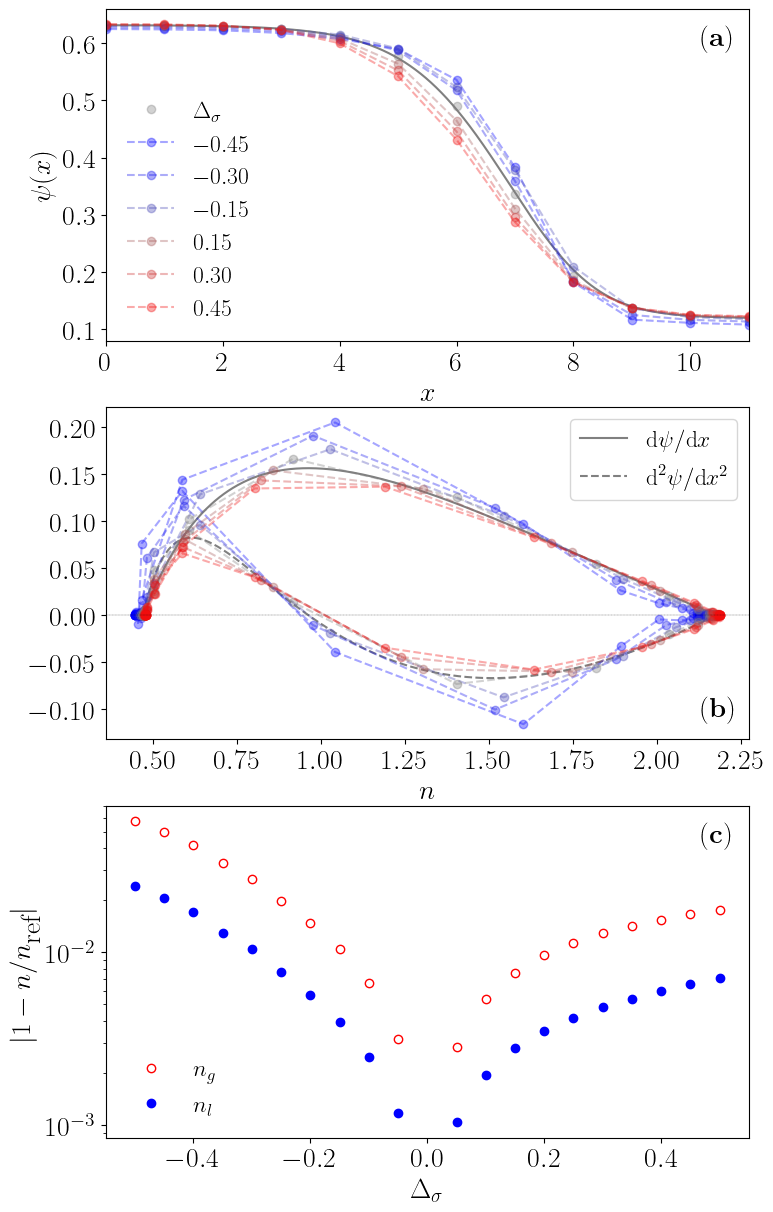

In [23]:
import matplotlib

from idpy.Utils.Plots import SetAxPanelLabelCoords, SetMatplotlibLatexParamas, SetDefaultFonts
from idpy.Utils.Plots import CreateFiguresPanels, SetAxPanelLabel, SetAxTicksFont
from matplotlib import rc, rcParams

from scipy.optimize import curve_fit

SetMatplotlibLatexParamas([rc], [rcParams])
fonts = SetDefaultFonts([rc])
fonts['fs'] = 25

fs, ms_small, ms_large, ms_large_c = 20, 7, 8, 20
fs, ms_small, ms_large, ms_large_c = 20, 7, 6, 20

psi_f = sp.lambdify([n], psi_sym)

colors = ['red', 'blue', 'darkgreen', 'darkorange', 'purple']

cmap_sigma_up = matplotlib.colors.LinearSegmentedColormap.from_list("MyCmapName",["gray","red"])
col_sigma_norm_up = matplotlib.colors.Normalize(vmin = 0, vmax = 0.5)

cmap_sigma_dn = matplotlib.colors.LinearSegmentedColormap.from_list("MyCmapName",["blue","gray"])
col_sigma_norm_dn = matplotlib.colors.Normalize(vmin = -0.35, vmax = 0)

markers = {1: 't', 2: 's', 3: 'p'}
m_opts_drp = {1: {'marker': 't', 'fillstyle': None, 'linestyle': 'none'},
              2: {'marker': 's', 'fillstyle': None, 'linestyle': 'none'}, 
              3: {'marker': 'p', 'fillstyle': None, 'linestyle': 'none'}}

m_opts_bub = {1: {'marker': 't', 'fillstyle': 'none', 'linestyle': 'none'}, 
              2: {'marker': 's', 'fillstyle': 'none', 'linestyle': 'none'}, 
              3: {'marker': 'p', 'fillstyle': 'none', 'linestyle': 'none'}}

m_opts_drp_dash = {1: {'marker': 't', 'fillstyle': None, 'linestyle': '--'},
                   2: {'marker': 's', 'fillstyle': None, 'linestyle': '--'}, 
                   3: {'marker': 'p', 'fillstyle': None, 'linestyle': '--'}}

m_opts_bub_dash = {1: {'marker': 't', 'fillstyle': 'none', 'linestyle': '--'}, 
                   2: {'marker': 's', 'fillstyle': 'none', 'linestyle': '--'}, 
                   3: {'marker': 'p', 'fillstyle': 'none', 'linestyle': '--'}}

get_label = lambda d1: '$' + "{:0.2f}".format(d1) + '$'

nx_fig, ny_fig = 1, 5

y_size, xy_ratio = 4.3, 1.2
fig = CreateFiguresPanels(_nx=nx_fig,_ny=ny_fig, _x_size=8.3, _y_size=5)

############# PROFILE
if True:
    ax_profile = plt.subplot2grid((ny_fig, nx_fig), (0, 0), colspan = 1, rowspan = 1)

    ax_profile.plot(x_range + 89.25, psi_range, color='grey')

    for i, DSigma in enumerate([0]):
        color = cmap_sigma_dn(col_sigma_norm_dn(DSigma))
        n_strip = flat_profiles_G0p2[DSigma]
        ax_profile.plot(np.arange(len(n_strip)), psi_f(n_strip), 
                        marker = 'o', linestyle='none', color=color, 
                        alpha=0.35, markersize=ms_large,
                label='$\Delta_\sigma$')


    # shifts = {-0.5: -1, -0.4: -1, -0.3: -1, -0.2: 0, -0.1: 0}
    shifts = {-0.45: -1, -0.3: -1, -0.15: 0}
    for i, DSigma in enumerate([-0.45, -0.3, -0.15][:]):
        color = cmap_sigma_dn(col_sigma_norm_dn(DSigma))
        n_strip = flat_profiles_G0p2[DSigma]
        ax_profile.plot(np.arange(len(n_strip)) + shifts[DSigma], psi_f(n_strip), 
                        marker = 'o', linestyle='--', color=color, 
                        alpha=0.35, markersize=ms_large, 
                label=get_label(DSigma))

    shifts = {0.45: -1, 0.3: -1, 0.15: 0}
    for i, DSigma in enumerate([0.15, 0.3, 0.45][:]):
        color = cmap_sigma_up(col_sigma_norm_up(DSigma))
        n_strip = flat_profiles_G0p2[DSigma]
        ax_profile.plot(np.arange(len(n_strip)), psi_f(n_strip), marker = 'o',
                        linestyle='--', color=color, alpha=0.35, markersize=ms_large,
                label=get_label(DSigma))

    ax_profile.set_xlim([90, 101])
    ax_profile.legend(frameon = False, loc = 'lower left')

    for tick in ax_profile.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_profile.get_yticklabels():
        tick.set_fontsize(fs)

    ax_profile.set_xlabel('$x$', fontsize = fs)
    ax_profile.set_ylabel('$\psi(x)$', fontsize = fs)
    ax_profile.set_xticks(np.arange(90, 101, 2), labels=np.arange(0, 101 - 90, 2))

    SetAxPanelLabel(ax=ax_profile, label='$\mathbf{(a)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.89)     

################## DERIVATIVES
if True:
    ax_dd = plt.subplot2grid((ny_fig, nx_fig), (1, 0), colspan = 1, rowspan = 1)

    ax_dd.plot(n_range, dpsi_analytical, label = '$\mbox{d}\psi/\mbox{d}x$', color='gray')
    ax_dd.plot(n_range, d2psi_analytical, label = '$\mbox{d}^2\psi/\mbox{d}x^2$', color='gray', linestyle='--')

    for i, DSigma in enumerate([-0.45, -0.3, -0.15][:]):
        color = cmap_sigma_dn(col_sigma_norm_dn(DSigma))

        n_strip = flat_profiles_G0p2[DSigma]

        n_data_spl = UnivariateSpline(np.arange(len(n_strip)), n_strip, s=0)
        psi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_f(n_strip), s=0)
        dpsi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_data_spl.derivative()(np.arange(len(n_strip))), s=0)

        x_strip = np.linspace(97 - 12, 97 + 12, 2 ** 10)
        x_strip_int = np.arange(97 - 12, 97 + 12, 1)

        ax_dd.plot(n_data_spl(x_strip_int), -psi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='--', color=color, markersize=ms_large, alpha=0.35)
        ax_dd.plot(n_data_spl(x_strip_int), dpsi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='--', color=color, markersize=ms_large, alpha=0.35)

    for i, DSigma in enumerate([0, 0.15, 0.3, 0.45][:]):
        color = cmap_sigma_up(col_sigma_norm_up(DSigma))

        n_strip = flat_profiles_G0p2[DSigma]

        n_data_spl = UnivariateSpline(np.arange(len(n_strip)), n_strip, s=0)
        psi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_f(n_strip), s=0)
        dpsi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_data_spl.derivative()(np.arange(len(n_strip))), s=0)

        x_strip = np.linspace(97 - 12, 97 + 12, 2 ** 10)
        x_strip_int = np.arange(97 - 12, 97 + 12, 1)

        ax_dd.plot(n_data_spl(x_strip_int), -psi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='--', color=color, markersize=ms_large, alpha=0.35)
        ax_dd.plot(n_data_spl(x_strip_int), dpsi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='--', color=color, markersize=ms_large, alpha=0.35)

    ax_dd.axhline(y=0, color='black', linestyle='--', linewidth=0.2)

    ax_dd.legend()

    for tick in ax_dd.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_dd.get_yticklabels():
        tick.set_fontsize(fs)

    ax_dd.set_xlabel('$n$', fontsize = fs)
    SetAxPanelLabel(ax=ax_dd, label='$\mathbf{(b)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.07) 

################## DENSITIES
if True:
    ax_rhos = plt.subplot2grid((ny_fig, nx_fig), (2, 0), colspan = 1, rowspan = 1)

    ref_ng, ref_nl = np.amin(flat_profiles_G0p2[0]), np.amax(flat_profiles_G0p2[0])
    [0,
               0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5,
               -0.05, -0.1, -0.15, -0.2, -0.25, -0.3, -0.35, -0.4, -0.45, -0.5]
    for i, DSigma in enumerate([-0.5, -0.45, -0.4, -0.35, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05, 
                                0, 
                                0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]):
        ng, nl = np.amin(flat_profiles_G0p2[DSigma]), np.amax(flat_profiles_G0p2[DSigma])
        plt.plot([DSigma], [np.abs(1 - ng / ref_ng)], marker='o', fillstyle='none', color='red', 
                 label = '$n_g$' if DSigma == 0 else None, linestyle='none', markersize=ms_large)
        plt.plot([DSigma], [np.abs(1 - nl / ref_nl)], marker='o', color='blue', 
                 label = '$n_l$' if DSigma == 0 else None, linestyle='none', markersize=ms_large)

    for tick in ax_rhos.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_rhos.get_yticklabels():
        tick.set_fontsize(fs)

    ax_rhos.set_xlabel('$\Delta_\sigma$', fontsize = fs)
    ax_rhos.set_ylabel('$|1 - n / n_{\mbox{ref}}|$', fontsize = fs)
    ax_rhos.set_yscale('log')

    ax_rhos.legend(frameon = False, loc = 'lower left')
    SetAxPanelLabel(ax=ax_rhos, label='$\mathbf{(c)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.89) 

if False:
    #################################################################################
    #################################################################################

    def FitSigma(bubb_re, bubb_delta_p, drop_re, drop_delta_p, dim, fit_cuts=None):
        """
        Now, collect the data point and fit
        """
        sort_index_bubb_re_m1 = np.argsort(-1 / bubb_re)
        sorted_bubb_re = bubb_re[sort_index_bubb_re_m1]
        sorted_bubb_delta_p = -bubb_delta_p[sort_index_bubb_re_m1]

        sort_index_drop_re_m1 = np.argsort(1 / drop_re)
        sorted_drop_re = drop_re[sort_index_drop_re_m1]
        sorted_drop_delta_p = drop_delta_p[sort_index_drop_re_m1]

        joint_re_m1 = np.append(-1  / sorted_bubb_re, 1 / sorted_drop_re)
        joint_delta_p = np.append(sorted_bubb_delta_p, sorted_drop_delta_p)

        """
        Fitting Tolman Length
        """
        fit_cut_index = np.array([True] * len(joint_re_m1))
        if fit_cuts is not None:
            fit_cut_index = np.where((joint_re_m1 > fit_cuts[0]) & (joint_re_m1 < fit_cuts[1]))

        def linear_func(x, b):
            return b * x

        lin_fit, lin_cov = curve_fit(linear_func, joint_re_m1[fit_cut_index], joint_delta_p[fit_cut_index] / (dim - 1))


        return lin_fit[0], np.linspace(joint_re_m1[0], joint_re_m1[-1], 2 ** 10)    
        
    ############# LAPLACE
    sigmas_fit_3d, dsigmas_values_3d = [], []
    sigmas_fit_2d, dsigmas_values_2d = [], []

    # DParams_list = [0, 0.5, 0.4, 0.3, 0.2, 0.1, -0.1, -0.2, -0.3, -0.35]
    # DParams_list = [0, 0.4, 0.35, 0.3, 0.2, 0.1, -0.1, -0.2, -0.25]


    if True:
        ax_laplace = plt.subplot2grid((ny_fig, nx_fig), (3, 0), colspan = 1, rowspan = 1)

        for i, DSigma in enumerate([0][:]):
            color = cmap_sigma_dn(col_sigma_norm_dn(DSigma))

            bubb_3d_re_m1 = -1 / bubb3d_laplace_data_Re[DSigma]
            bubb_3d_delta_p = -bubb3d_laplace_data_delta_p[DSigma] / 2
            ax_laplace.plot(bubb_3d_re_m1, bubb_3d_delta_p, 
                            **m_opts_bub[3], alpha=0.35, markersize=ms_large, color=color)
            
            drop_3d_re_m1 = 1 / drop3d_laplace_data_Re[DSigma]
            drop_3d_delta_p = drop3d_laplace_data_delta_p[DSigma] / 2

            cut_data = drop_3d_re_m1 < 0.06
            drop_3d_re_m1 = drop_3d_re_m1[cut_data]
            drop_3d_delta_p = drop_3d_delta_p[cut_data]

            sigma_fit, fit_linspace = \
                FitSigma(bubb3d_laplace_data_Re[DSigma], bubb3d_laplace_data_delta_p[DSigma], 
                        drop3d_laplace_data_Re[DSigma], drop3d_laplace_data_delta_p[DSigma], 
                        3, fit_cuts=[-0.04, 0.04])
            
            print("3d DSigma:", DSigma, "sigma_fit:", sigma_fit)
            sigmas_fit_3d += [sigma_fit]
            dsigmas_values_3d += [DSigma]
            ax_laplace.plot(fit_linspace, fit_linspace * sigma_fit, color=color, linestyle='-', alpha=0.35)

            ax_laplace.plot(drop_3d_re_m1, drop_3d_delta_p, 
                            **m_opts_drp[3], alpha=0.35, markersize=ms_large, color=color)

        for i, DSigma in enumerate([0][:]):
            color = cmap_sigma_dn(col_sigma_norm_dn(DSigma))
            ax_laplace.plot(-1 / bubb2d_laplace_data_Re[DSigma], 
                            -bubb2d_laplace_data_delta_p[DSigma], 
                            **m_opts_bub[2], alpha=0.35, markersize=ms_large, color=color)
            ax_laplace.plot(1 / drop2d_laplace_data_Re[DSigma], 
                            drop2d_laplace_data_delta_p[DSigma], 
                            **m_opts_drp[2], alpha=0.35, markersize=ms_large, color=color,
                            label='$\Delta_\sigma$')
            
            sigma_fit, fit_linspace = \
                FitSigma(bubb2d_laplace_data_Re[DSigma], bubb2d_laplace_data_delta_p[DSigma], 
                        drop2d_laplace_data_Re[DSigma], drop2d_laplace_data_delta_p[DSigma], 
                        2, fit_cuts=[-0.02, 0.02])
            
            print("2d DSigma:", DSigma, "sigma_fit:", sigma_fit)
            sigmas_fit_2d += [sigma_fit]
            dsigmas_values_2d += [DSigma]
            ax_laplace.plot(fit_linspace, fit_linspace * sigma_fit, color=color, linestyle='-', alpha=0.35)

            
        ax_laplace.axhline(y=0, linestyle='--', color='black', linewidth=0.5)        
        ax_laplace.axvline(x=0, linestyle='--', color='black', linewidth=0.5)        

        for i, DSigma in enumerate([-0.35, -0.3, -0.2, -0.1][:]):
            color = cmap_sigma_dn(col_sigma_norm_dn(DSigma))
            ax_laplace.plot(-1 / bubb2d_laplace_data_Re[DSigma], 
                            -bubb2d_laplace_data_delta_p[DSigma], 
                            **m_opts_bub[2], alpha=0.35, markersize=ms_large, color=color)
            ax_laplace.plot(1 / drop2d_laplace_data_Re[DSigma], 
                            drop2d_laplace_data_delta_p[DSigma], 
                            **m_opts_drp[2], alpha=0.35, markersize=ms_large, color=color, 
                            label=get_label(DSigma) if DSigma == -0.35 else None)

            sigma_fit, fit_linspace = \
                FitSigma(bubb2d_laplace_data_Re[DSigma], bubb2d_laplace_data_delta_p[DSigma], 
                        drop2d_laplace_data_Re[DSigma], drop2d_laplace_data_delta_p[DSigma], 
                        2, fit_cuts=[-0.02, 0.02])
            
            print("2d DSigma:", DSigma, "sigma_fit:", sigma_fit)
            sigmas_fit_2d += [sigma_fit]
            dsigmas_values_2d += [DSigma]
            ax_laplace.plot(fit_linspace, fit_linspace * sigma_fit, color=color, linestyle='-', alpha=0.35)

        for i, DSigma in enumerate([0.1, 0.2, 0.3, 0.4, 0.5][:]):
            color = cmap_sigma_up(col_sigma_norm_up(DSigma))
            ax_laplace.plot(-1 / bubb2d_laplace_data_Re[DSigma], 
                            -bubb2d_laplace_data_delta_p[DSigma], 
                            **m_opts_bub[2], alpha=0.35, markersize=ms_large, color=color)
            ax_laplace.plot(1 / drop2d_laplace_data_Re[DSigma], 
                            drop2d_laplace_data_delta_p[DSigma], 
                            **m_opts_drp[2], alpha=0.35, markersize=ms_large, color=color, 
                            label=get_label(DSigma) if DSigma == 0.5 else None)

            sigma_fit, fit_linspace = \
                FitSigma(bubb2d_laplace_data_Re[DSigma], bubb2d_laplace_data_delta_p[DSigma], 
                        drop2d_laplace_data_Re[DSigma], drop2d_laplace_data_delta_p[DSigma], 
                        2, fit_cuts=[-0.02, 0.02])
            
            print("2d DSigma:", DSigma, "sigma_fit:", sigma_fit)
            sigmas_fit_2d += [sigma_fit]
            dsigmas_values_2d += [DSigma]
            ax_laplace.plot(fit_linspace, fit_linspace * sigma_fit, color=color, linestyle='-', alpha=0.35)

        ## 0.4, -0.25
        ## DParams_list = [0, 0.4, 0.35, 0.3, 0.2, 0.1, -0.1, -0.2, -0.25]
        fit_cuts = {-0.25: [-0.02, 0.02], -0.2: [-0.02, 0.02], -0.1: [-0.02, 0.02]}
        for i, DSigma in enumerate([-0.25, -0.2, -0.1][:]):
            color = cmap_sigma_dn(col_sigma_norm_dn(DSigma))

            bubb_3d_re_m1 = -1 / bubb3d_laplace_data_Re[DSigma]
            bubb_3d_delta_p = -bubb3d_laplace_data_delta_p[DSigma] / 2
            ax_laplace.plot(bubb_3d_re_m1, bubb_3d_delta_p, 
                            **m_opts_bub[3], alpha=0.35, markersize=ms_large, color=color)
            
            drop_3d_re_m1 = 1 / drop3d_laplace_data_Re[DSigma]
            drop_3d_delta_p = drop3d_laplace_data_delta_p[DSigma] / 2

            cut_data = drop_3d_re_m1 < 0.06
            drop_3d_re_m1 = drop_3d_re_m1[cut_data]
            drop_3d_delta_p = drop_3d_delta_p[cut_data]

            ax_laplace.plot(drop_3d_re_m1, drop_3d_delta_p, 
                            **m_opts_drp[3], alpha=0.35, markersize=ms_large, color=color)

            sigma_fit, fit_linspace = \
                FitSigma(bubb3d_laplace_data_Re[DSigma], bubb3d_laplace_data_delta_p[DSigma], 
                        drop3d_laplace_data_Re[DSigma], drop3d_laplace_data_delta_p[DSigma], 
                        3, fit_cuts=fit_cuts[DSigma])
            
            print("3d DSigma:", DSigma, "sigma_fit:", sigma_fit)
            sigmas_fit_3d += [sigma_fit]
            dsigmas_values_3d += [DSigma]
            ax_laplace.plot(fit_linspace, fit_linspace * sigma_fit, color=color, linestyle='-', alpha=0.35)

        fit_cuts = {0.1: [-0.02, 0.02], 0.2: [-0.02, 0.02], 0.3: [-0.02, 0.02], 0.35: [-0.02, 0.02]}
        for i, DSigma in enumerate([0.1, 0.2, 0.3, 0.35][:]):
            color = cmap_sigma_up(col_sigma_norm_up(DSigma))

            bubb_3d_re_m1 = -1 / bubb3d_laplace_data_Re[DSigma]
            bubb_3d_delta_p = -bubb3d_laplace_data_delta_p[DSigma] / 2
            ax_laplace.plot(bubb_3d_re_m1, bubb_3d_delta_p, 
                            **m_opts_bub[3], alpha=0.35, markersize=ms_large, color=color)
            
            drop_3d_re_m1 = 1 / drop3d_laplace_data_Re[DSigma]
            drop_3d_delta_p = drop3d_laplace_data_delta_p[DSigma] / 2

            cut_data = drop_3d_re_m1 < 0.06
            drop_3d_re_m1 = drop_3d_re_m1[cut_data]
            drop_3d_delta_p = drop_3d_delta_p[cut_data]

            ax_laplace.plot(drop_3d_re_m1, drop_3d_delta_p, 
                            **m_opts_drp[3], alpha=0.35, markersize=ms_large, color=color)

            sigma_fit, fit_linspace = \
                FitSigma(bubb3d_laplace_data_Re[DSigma], bubb3d_laplace_data_delta_p[DSigma], 
                        drop3d_laplace_data_Re[DSigma], drop3d_laplace_data_delta_p[DSigma], 
                        3, fit_cuts=fit_cuts[DSigma])
            
            print("3d DSigma:", DSigma, "sigma_fit:", sigma_fit)
            sigmas_fit_3d += [sigma_fit]
            dsigmas_values_3d += [DSigma]
            ax_laplace.plot(fit_linspace, fit_linspace * sigma_fit, color=color, linestyle='-', alpha=0.35)

        ax_laplace.legend(frameon = False, loc = 'upper left', ncol=4)

        for tick in ax_laplace.get_xticklabels():
            tick.set_fontsize(fs)

        for tick in ax_laplace.get_yticklabels():
            tick.set_fontsize(fs)

        # ax_laplace.set_ylim([-0.0012, 0.002])
        ax_laplace.set_xlim([-0.06, 0.06])
        ax_laplace.set_ylim([-0.0018, 0.0014])

        # ax_laplace.set_xlim([0, 0.05])
        # ax_laplace.set_ylim([0, 0.0014])

        ax_laplace.set_xlabel('$1 / R_e$', fontsize = fs)
        ax_laplace.set_ylabel('$(-1)^b\Delta P / (d - 1)$', fontsize = fs)

        SetAxPanelLabel(ax=ax_laplace, label='$\mathbf{(d)}$', 
                        fs=fs, x_pos = 0.925, y_pos = 0.07) 


    sigmas_fit_3d, dsigmas_values_3d = \
        np.array(sigmas_fit_3d), np.array(dsigmas_values_3d)
    sigmas_fit_2d, dsigmas_values_2d = \
        np.array(sigmas_fit_2d), np.array(dsigmas_values_2d)

    dsigmas_values_3d_sindex = np.argsort(dsigmas_values_3d)
    sigmas_fit_3d = sigmas_fit_3d[dsigmas_values_3d_sindex]
    dsigmas_values_3d = dsigmas_values_3d[dsigmas_values_3d_sindex]

    dsigmas_values_2d_sindex = np.argsort(dsigmas_values_2d)
    sigmas_fit_2d = sigmas_fit_2d[dsigmas_values_2d_sindex]
    dsigmas_values_2d = dsigmas_values_2d[dsigmas_values_2d_sindex]

    ################## SIGMA

    sort_deltas_index = np.argsort(flat_DSigmas_G0p2)

    flat_sigma_G0p2 = flat_sigma_G0p2[sort_deltas_index]
    flat_DSigmas_G0p2 = flat_DSigmas_G0p2[sort_deltas_index]

    if True:
        ax_sigma = plt.subplot2grid((ny_fig, nx_fig), (4, 0), colspan = 1, rowspan = 1)

        ref_sigma = flat_sigma_G0p2[np.where(flat_DSigmas_G0p2 == 0)]
        ax_sigma.plot(flat_DSigmas_G0p2, flat_sigma_G0p2, marker='^', color='darkgreen')
        ax_sigma.plot(dsigmas_values_2d, sigmas_fit_2d, marker='s', color='red')
        ax_sigma.plot(dsigmas_values_3d, sigmas_fit_3d, marker='p', color='blue')
        ax_sigma.plot(flat_DSigmas_G0p2, ref_sigma * (1 + flat_DSigmas_G0p2), color='black', linestyle='--')

        ax_sigma.axvline(x=0, linestyle='--', linewidth=0.5, color='black')
        ax_sigma.axhline(y=ref_sigma, linewidth=1, color='gray')

        for tick in ax_sigma.get_xticklabels():
            tick.set_fontsize(fs)

        for tick in ax_sigma.get_yticklabels():
            tick.set_fontsize(fs)

        ax_sigma.set_xlabel('$\Delta_\sigma$', fontsize = fs)
        ax_sigma.set_ylabel('$\sigma_0$', fontsize = fs)

        SetAxPanelLabel(ax=ax_sigma, label='$\mathbf{(e)}$', 
                        fs=fs, x_pos = 0.925, y_pos = 0.07) 

    plt.savefig('figures/sigma_0p2.pdf', bbox_inches = 'tight', dpi = 150)

## Results V.C: Higher-order Tolman length tuning - $\hat{\delta}_0$

### Table IV

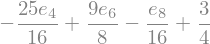

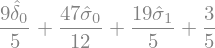

- \frac{25 e_{4}}{16} + \frac{9 e_{6}}{8} - \frac{e_{8}}{16} + \frac{3}{4}
\frac{9 \hat{\delta}_0}{5} + \frac{47 \hat{\sigma}_0}{12} + \frac{19 \hat{\sigma}_1}{5} + \frac{3}{5}



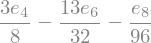

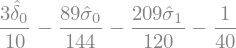

\frac{3 e_{4}}{8} - \frac{13 e_{6}}{32} - \frac{e_{8}}{96}
\frac{3 \hat{\delta}_0}{10} - \frac{89 \hat{\sigma}_0}{144} - \frac{209 \hat{\sigma}_1}{120} - \frac{1}{40}



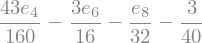

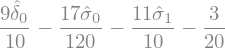

\frac{43 e_{4}}{160} - \frac{3 e_{6}}{16} - \frac{e_{8}}{32} - \frac{3}{40}
\frac{9 \hat{\delta}_0}{10} - \frac{17 \hat{\sigma}_0}{120} - \frac{11 \hat{\sigma}_1}{10} - \frac{3}{20}



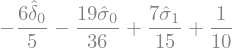

\frac{e_{8}}{24}
- \frac{6 \hat{\delta}_0}{5} - \frac{19 \hat{\sigma}_0}{36} + \frac{7 \hat{\sigma}_1}{15} + \frac{1}{10}



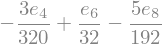

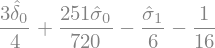

- \frac{3 e_{4}}{320} + \frac{e_{6}}{32} - \frac{5 e_{8}}{192}
\frac{3 \hat{\delta}_0}{4} + \frac{251 \hat{\sigma}_0}{720} - \frac{\hat{\sigma}_1}{6} - \frac{1}{16}



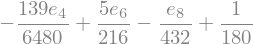

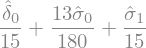

- \frac{139 e_{4}}{6480} + \frac{5 e_{6}}{216} - \frac{e_{8}}{432} + \frac{1}{180}
\frac{\hat{\delta}_0}{15} + \frac{13 \hat{\sigma}_0}{180} + \frac{\hat{\sigma}_1}{15}



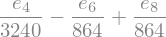

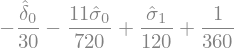

\frac{e_{4}}{3240} - \frac{e_{6}}{864} + \frac{e_{8}}{864}
- \frac{\hat{\delta}_0}{30} - \frac{11 \hat{\sigma}_0}{720} + \frac{\hat{\sigma}_1}{120} + \frac{1}{360}



In [24]:
"""
Defining the tunable stencils: 2d - typ
"""
it2d_typ = InterfaceTuning2D(l2_list=[1, 2, 4, 5, 8, 9, 18])
it2d_typ.DefineWeights(
    [it2d_typ.e_sym[n] - it2d_typ.e_expr[n] for n in range(2, 8 + 1, 2)] + 
    [it2d_typ.I_sym[(4,0)] - it2d_typ.typ_eq_s[4][0], 
     it2d_typ.I_sym[(6,0)] - it2d_typ.typ_eq_s[6][0], 
     it2d_typ.I_sym[(8,0)] - it2d_typ.typ_eq_s[8][0]])

it2d_typ.GetFullySolvedWeights()

eqs = [sp.Eq(it2d_typ.hat_sigma_0_sym, it2d_typ.hat_sigma_0_eIs[0]),
       sp.Eq(it2d_typ.hat_sigma_1_sym, it2d_typ.hat_sigma_0_eIs[1]), 
       sp.Eq(it2d_typ.hat_delta_0_sym, it2d_typ.hat_delta_0_eI)]

sol_hats_dict = sp.solve(eqs, [it2d_typ.e_sym[4], it2d_typ.e_sym[6], it2d_typ.e_sym[8]])
iso_dict = it2d_typ.GetStdIsoDict()

for w in it2d_typ.GetWeightsStencilSol({}).w_sol[0]:
#     display(w.subs({}))
#     print(sp.latex(w))
#     print()
    w_hats = w.subs(sol_hats_dict)
    w_hats = w_hats.subs(iso_dict)
    display(w, w_hats)
    print(sp.latex(w))
    print(sp.latex(w_hats))
    print()

### Table V

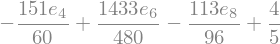

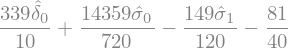

- \frac{151 e_{4}}{60} + \frac{1433 e_{6}}{480} - \frac{113 e_{8}}{96} + \frac{4}{5}
\frac{339 \hat{\delta}_0}{10} + \frac{14359 \hat{\sigma}_0}{720} - \frac{149 \hat{\sigma}_1}{120} - \frac{81}{40}



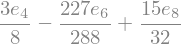

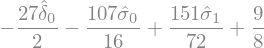

\frac{3 e_{4}}{8} - \frac{227 e_{6}}{288} + \frac{15 e_{8}}{32}
- \frac{27 \hat{\delta}_0}{2} - \frac{107 \hat{\sigma}_0}{16} + \frac{151 \hat{\sigma}_1}{72} + \frac{9}{8}



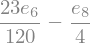

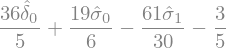

\frac{23 e_{6}}{120} - \frac{e_{8}}{4}
\frac{36 \hat{\delta}_0}{5} + \frac{19 \hat{\sigma}_0}{6} - \frac{61 \hat{\sigma}_1}{30} - \frac{3}{5}



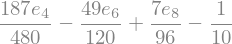

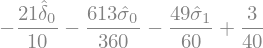

\frac{187 e_{4}}{480} - \frac{49 e_{6}}{120} + \frac{7 e_{8}}{96} - \frac{1}{10}
- \frac{21 \hat{\delta}_0}{10} - \frac{613 \hat{\sigma}_0}{360} - \frac{49 \hat{\sigma}_1}{60} + \frac{3}{40}



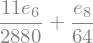

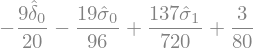

\frac{11 e_{6}}{2880} + \frac{e_{8}}{64}
- \frac{9 \hat{\delta}_0}{20} - \frac{19 \hat{\sigma}_0}{96} + \frac{137 \hat{\sigma}_1}{720} + \frac{3}{80}



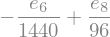

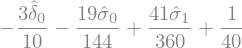

- \frac{e_{6}}{1440} + \frac{e_{8}}{96}
- \frac{3 \hat{\delta}_0}{10} - \frac{19 \hat{\sigma}_0}{144} + \frac{41 \hat{\sigma}_1}{360} + \frac{1}{40}



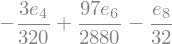

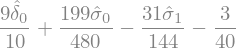

- \frac{3 e_{4}}{320} + \frac{97 e_{6}}{2880} - \frac{e_{8}}{32}
\frac{9 \hat{\delta}_0}{10} + \frac{199 \hat{\sigma}_0}{480} - \frac{31 \hat{\sigma}_1}{144} - \frac{3}{40}



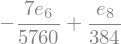

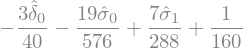

- \frac{7 e_{6}}{5760} + \frac{e_{8}}{384}
- \frac{3 \hat{\delta}_0}{40} - \frac{19 \hat{\sigma}_0}{576} + \frac{7 \hat{\sigma}_1}{288} + \frac{1}{160}



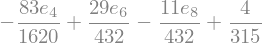

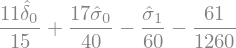

- \frac{83 e_{4}}{1620} + \frac{29 e_{6}}{432} - \frac{11 e_{8}}{432} + \frac{4}{315}
\frac{11 \hat{\delta}_0}{15} + \frac{17 \hat{\sigma}_0}{40} - \frac{\hat{\sigma}_1}{60} - \frac{61}{1260}



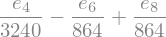

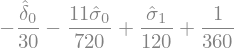

\frac{e_{4}}{3240} - \frac{e_{6}}{864} + \frac{e_{8}}{864}
- \frac{\hat{\delta}_0}{30} - \frac{11 \hat{\sigma}_0}{720} + \frac{\hat{\sigma}_1}{120} + \frac{1}{360}



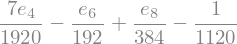

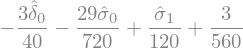

\frac{7 e_{4}}{1920} - \frac{e_{6}}{192} + \frac{e_{8}}{384} - \frac{1}{1120}
- \frac{3 \hat{\delta}_0}{40} - \frac{29 \hat{\sigma}_0}{720} + \frac{\hat{\sigma}_1}{120} + \frac{3}{560}



In [25]:
"""
Defining the tunable stencils: 3d
"""
def From2DTO3D_Final(itclass, expr=None):
    dict_transf = {itclass.w_sym[1]: itclass.w_syms_list[0] + 2 * itclass.w_syms_list[1] + 2 * itclass.w_syms_list[4], 
                   itclass.w_sym[2]: itclass.w_syms_list[1] + 2 * itclass.w_syms_list[2] + 2 * itclass.w_syms_list[5], 
                   itclass.w_sym[4]: itclass.w_syms_list[3] + 2 * itclass.w_syms_list[4] + 2 * itclass.w_syms_list[6], 
                   itclass.w_sym[5]: itclass.w_syms_list[4] + 2 * itclass.w_syms_list[5] + 2 * itclass.w_syms_list[7], 
                   itclass.w_sym[8]: itclass.w_syms_list[6] + 2 * itclass.w_syms_list[7],
                   itclass.w_sym[9]: itclass.w_syms_list[8] + 2 * itclass.w_syms_list[9],
                   itclass.w_sym[16]: itclass.w_syms_list[10],
                   itclass.w_sym[18]: itclass.w_syms_list[9]}

    if expr is None:
        return dict_transf
    else:
        for WS in dict_transf:
            expr = expr.subs(WS, dict_transf[WS])
        return expr

it3d_typ = InterfaceTuning3D(root_vectors_3d = [(1, 0, 0), (1, 1, 0), (1, 1, 1), (2, 0, 0), (2, 1, 0), (2, 1, 1), (2, 2, 0),
                                                (2, 2, 1), (3, 0, 0), (3, 3, 0), (4, 0, 0)], 
                                                l2_list_2d = [1, 2, 4, 5, 8, 9, 16, 18])
it3d_typ.DefineWeights3DTYP0(From2DTO3D_Final)

eqs = [sp.Eq(it3d_typ.hat_sigma_0_sym, it3d_typ.hat_sigma_0_eIs_3d[0]),
       sp.Eq(it3d_typ.hat_sigma_1_sym, it3d_typ.hat_sigma_0_eIs_3d[1]),
       sp.Eq(it3d_typ.hat_delta_0_sym, it3d_typ.hat_delta_0_eI_3d)]

sol_hats_dict = sp.solve(eqs, [it3d_typ.e_sym[4], it3d_typ.e_sym[6], it3d_typ.e_sym[8]])
iso_dict = it3d_typ.GetStdIsoDict()

_ = it3d_typ.GetWeightsStencilSol3D({})

for w in it3d_typ.w_sol_iso_list:
    w_hats = w.subs(sol_hats_dict)
    w_hats = w_hats.subs(iso_dict)
    display(w, w_hats)
    print(sp.latex(w))
    print(sp.latex(w_hats))
    print()

### Simulations

In [26]:
from idpy.IdpyCode import OCL_T, CUDA_T, CTYPES_T
set_lang, set_device, set_kind = CUDA_T, 0, 'gpu'

In [27]:
e4_val = sp.Rational(4, 5)
e6_val = sp.Pow(e4_val, sp.Rational(3, 2))
e8_val = sp.Pow(e4_val, sp.Rational(2, 1))

ref_eps_val = (6 * e4_val - 2) / (6 * e4_val + 1)

In [28]:
n, eps = sp.Symbol('n'), sp.Symbol('\\varepsilon')
psis = [sp.exp(-1/n), sp.Pow((n / (eps + n)), 1 / eps)]

n_s_lambdas = {psis[0]: lambda G_val: SpinodalPsi(G_val, psis[0], n),
               psis[1]: lambda psi_sym: lambda G_val: SpinodalPsi(G_val, psi_sym, n)}

psi_codes = {psis[0]: 'exp((NType)(-1./ln_0))', 
             psis[1]: lambda eps_val: 'pow((ln_0 / (' + str(float(eps_val)) + ' + ln_0)), ' + str(float(1 / eps_val)) + ')'}

In [29]:
"""
Defining the tunable stencils: 2d - typ
"""
it2d_custom_reference = InterfaceTuning2D(l2_list=[1, 2, 4, 5, 8, 9, 18])
it2d_custom_reference.DefineWeights(
    [it2d_custom_reference.e_sym[n] - it2d_custom_reference.e_expr[n] for n in range(2, 8 + 1, 2)] + 
    [it2d_custom_reference.I_sym[(4,0)] - it2d_custom_reference.typ_eq_s[4][0], 
     it2d_custom_reference.I_sym[(6,0)] - it2d_custom_reference.typ_eq_s[6][0], 
     it2d_custom_reference.I_sym[(8,0)] - it2d_custom_reference.typ_eq_s[8][0]])

it2d_custom_reference.GetFullySolvedWeights()

eqs = [sp.Eq(it2d_custom_reference.hat_sigma_0_sym, it2d_custom_reference.hat_sigma_0_eIs[0]),
       sp.Eq(it2d_custom_reference.hat_sigma_1_sym, it2d_custom_reference.hat_sigma_0_eIs[1]), 
       sp.Eq(it2d_custom_reference.hat_delta_0_sym, it2d_custom_reference.hat_delta_0_eI)]

sol_hats_dict = sp.solve(eqs, [it2d_custom_reference.e_sym[4], it2d_custom_reference.e_sym[6], it2d_custom_reference.e_sym[8]])
iso_dict = it2d_custom_reference.GetStdIsoDict()

hat_sigma_0_ref = it2d_custom_reference.hat_sigma_0_eIs[0].subs({**iso_dict, 
                                                                 it2d_custom_reference.e_sym[4]: e4_val, 
                                                                 it2d_custom_reference.e_sym[6]: e6_val, 
                                                                 it2d_custom_reference.e_sym[8]: e8_val})

hat_sigma_1_ref = it2d_custom_reference.hat_sigma_0_eIs[1].subs({**iso_dict, 
                                                                 it2d_custom_reference.e_sym[4]: e4_val, 
                                                                 it2d_custom_reference.e_sym[6]: e6_val, 
                                                                 it2d_custom_reference.e_sym[8]: e8_val})

hat_delta_0_ref = it2d_custom_reference.hat_delta_0_eI.subs({**iso_dict, 
                                                             it2d_custom_reference.e_sym[4]: e4_val, 
                                                             it2d_custom_reference.e_sym[6]: e6_val, 
                                                             it2d_custom_reference.e_sym[8]: e8_val})

#### $\Delta \hat{T} = 0.1$

Pseudopotential:


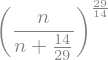


Critical coupling: -2519424*31888098**(1/7)/12313081 Critical density: 22/29
0.07315406332873782 0.08503721278144624 -0.01986113452226237 0.00662174289923977
Check Pressure: 0.0814482753350359 0.08144827533503587 0.08144827533503535
Density ratio: 4.044269326659753 1.490081408375683 0.3684426748122565
Debug - the derivative values should both be positive - avoid negative square root: 4.64655280915690e-9 5.86659159575753e-19

sigma_f: 0.01652883201460492

29531


In [30]:
G_eps = 0.1

psi_sym = psis[1].subs(eps, ref_eps_val)
G_sym = sp.Symbol('G')
pb_sym = n / 3 + G_sym * (psi_sym ** 2) / 2

n_c, G_c = sp.solve([sp.Eq(sp.diff(pb_sym, (n, 1)), 0), sp.Eq(sp.diff(pb_sym, (n, 2)), 0)], [n, G_sym])[0]
print("Pseudopotential:")
display(psi_sym)
print()
print("Critical coupling:", G_c, "Critical density:", n_c)

G_val = G_c * (G_eps + 1)

ns_g, ns_l = SpinodalPsi(G_val, psi_sym, n, n_min=1e-1)
pb_lam = sp.lambdify([n], pb_sym.subs(G_sym, G_val))

MEAInteg_lam = lambda p: MaxwellEqualAreaIntegral(p, G_val, psi_sym, n, ns_g, ns_l, pb_lam)

p0_eq, steps_count = MyNewton(pb_lam(ns_l) * (1 + 1e-2) if pb_lam(ns_l) > 0 else 0,  pb_lam(ns_g) * (1 - 1e-2), MEAInteg_lam)
ng_eq, nl_eq = \
    FindDensityFromPressure(G_val, psi_sym, n, p0_eq, (ns_g, ns_l), branch='n_g', exp_2 = 11, n_max=2.5), \
    FindDensityFromPressure(G_val, psi_sym, n, p0_eq, (ns_g, ns_l), branch='n_l', exp_2 = 11, n_max=3)

print("Check Pressure:", p0_eq, pb_lam(ng_eq), pb_lam(nl_eq))
print("Density ratio:", nl_eq/ng_eq, nl_eq, ng_eq)

eq_params = {'n_l': nl_eq, 'n_g': ng_eq, 'n_l': nl_eq, 'sigma_f': None, 'G_c': G_c, 'n_c': n_c, 'p_0': p0_eq}


"""
Using a common value for the flat surface tension for initializing the densities
"""
dpsi2_lam = lambda n_val: MaxwellProfilePsiD2(n_val, eq_params['n_g'], eq_params['p_0'], ref_eps_val, G_val, pb_lam)

dpsi_sym = sp.diff(psi_sym, (n, 1))
dpsi_lam = sp.lambdify([n], dpsi_sym)
psi_lam = sp.lambdify([n], psi_sym)

d2psi_lam = \
    lambda n_val: (1 / (2 * psi_lam(n_val))) * (float(ref_eps_val) * dpsi2_lam(n_val) + 
                   (8 * ((1 - float(ref_eps_val)) / G_val.evalf()) * (eq_params['p_0'] - pb_lam(n_val))))

n_range = np.linspace(eq_params['n_l'] * (1 - 9e-4), eq_params['n_g'] * (1 + 5e-9), 2 ** 13)
# n_range = np.linspace(eq_params['n_l'] * (1 - 9.25e-2), eq_params['n_g'] * (1 + 2e-2), 2 ** 13) ## 0.1
print("Debug - the derivative values should both be positive - avoid negative square root:", dpsi2_lam(n_range[0]), dpsi2_lam(n_range[-1]))
dn_int = np.abs(n_range[1] - n_range[0])

Sigma_11 = np.sum(np.array([dpsi_lam(n_val) * np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])) * dn_int
Sigma_22 = np.sum(np.array([dpsi_lam(n_val) * (np.float64(d2psi_lam(n_val)) ** 2) / np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])) * dn_int

sigma_flat_value = np.float64(G_val * ((-e4_val / 2) * Sigma_11))
eq_params['sigma_f'] = sigma_flat_value

print()
print("sigma_f:", eq_params['sigma_f'])
print()

x_range, psi_range, n_range = GetPsiProfile(eq_params['n_c'] * 5e-5, psi_sym, n, eq_params, kickstart=8e-4) ## 0.1
dpsi_analytical = np.array([np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])
d2psi_analytical = np.array([d2psi_lam(n_val) for n_val in n_range])

In [31]:
from pathlib import Path

root_dir_res = Path('./reproduced-results/')
if not root_dir_res.is_dir():
    root_dir_res.mkdir()

def GetFileNameDelta0(G_eps, DDelta, dim_sizes, kind):
    name_str = "Delta0Tuning_" + "{:.4f}".format(G_eps) + '_' + "{:.4f}".format(DDelta) + '_' + str(dim_sizes) + '_' + str(kind)
    return name_str + '.hdf5'

from idpy.Utils.ManageData import ManageData

def ReadDensity(file_name, dim_sizes):
    file_name = str(file_name)
    md = ManageData(dump_file=file_name)
    n_strip = md.ReadHDF5(full_key='/ShanChenMultiPhase/idpy_memory/n', class_check_override=True)
    return n_strip.reshape(np.flip(dim_sizes))

from InterfaceTuning import GetSigma0, GetSigma1, GetFlatAdsorbance, GetFlatEquimolarSurface
from LatticePressureTensor import LPT_16_2D

def Analyze2DFlatDelta(n_field, dim_sizes, stencil, G, psi_sym, n_sym):
    """
    Getting the realized densities
    """
    n_strip = n_field[0,:]
    n_l_sim, n_g_sim = np.amax(n_strip), np.amin(n_strip)

    """
    Getting the position of the equimolar interface
    """
    z_e = GetFlatEquimolarSurface(n_line=n_strip[dim_sizes[0]//2:], z_range=np.arange(dim_sizes[0]//2), grains=2**10)

    """
    Getting the adsorbance function ... not so precise it seems ...
    """
    Gamma_f = GetFlatAdsorbance(n_strip[dim_sizes[0]//2:], np.arange(dim_sizes[0]//2), grains=2**10)
    # The domain is split in two inside the function

    """
    Getting components of the lattice pressure tensor
    """
    
    p_n = LPT_16_2D(G, n_field, stencil.PushStencil(), psi_sym, n_sym)['LPT'][dim_sizes[1]//2,dim_sizes[0]//2:,0]
    p_t = LPT_16_2D(G, n_field, stencil.PushStencil(), psi_sym, n_sym)['LPT'][dim_sizes[1]//2,dim_sizes[0]//2:,2]
    p_nmt_spl = UnivariateSpline(np.arange(len(p_n)), p_n - p_t, s=0)

    """
    Estimating surface tension and position of the surface of tension
    """
    sigma_p_nmt = p_nmt_spl.integral(0, dim_sizes[0]//2)
    p_nmt_M1_spl = UnivariateSpline(np.arange(len(p_n)), np.arange(len(p_n)) * (p_n - p_t), s=0)
    z_s = p_nmt_M1_spl.integral(0, dim_sizes[0]//2) / sigma_p_nmt

    delta_ads_sim = Gamma_f(z_s) / (n_l_sim - n_g_sim)
    delta_lpt = z_e - z_s

    return {'sigma_p_nmt': sigma_p_nmt, 'delta_lpt': delta_lpt, 'delta_ads_sim': delta_ads_sim, 'p_nmt_spl': p_nmt_spl,
            'x_range': np.arange(len(p_n))}


flat_profiles_G0p1 = {}
flat_tolman_G0p1, flat_tolman_ads_G0p1, flat_sigma_G0p1, flat_DDeltas_G0p1 = [], [], [], []
flat_tolman_sc_G0p1 = []

for DDelta in [0, 
               0.25, -0.25, 0.5, -0.5, 0.75, -0.75, 1, -1, 
               1.25, -1.25, 1.5, -1.5, 1.75, -1.75, 2, -2]:

    tuned_stencil_2d = \
        it2d_custom_reference.GetFullySolvedStencilISO2D({it2d_custom_reference.e_sym[4]: e4_val,
                                                        it2d_custom_reference.hat_sigma_1_sym: hat_sigma_1_ref, 
                                                        it2d_typ.hat_delta_0_sym: hat_delta_0_ref * (1 + DDelta)})
    G = float(G_val)

    dim_sizes = (128, 32)   
    dump_file_name = root_dir_res / Path(GetFileNameDelta0(np.float64(G_eps), DDelta, dim_sizes, 'flat'))
    print(dump_file_name, dump_file_name.is_file())

    if not dump_file_name.is_file():
        IT_sim = InterfaceTuningSims(lang=set_lang, device=set_device, cl_kind=set_kind, dim_sizes=dim_sizes)

        IT_sim.RunFlat(
            f_stencil=tuned_stencil_2d.PushStencil(),
            n_g=eq_params['n_g'], n_l=eq_params['n_l'], 
            # G=G, psi_sym=psi_sym, psi_code=psi_codes[psis[2]](float(eps_val)),
            G=G, psi_sym=psi_sym, psi_code=psi_codes[psis[1]](ref_eps_val),
            dump_name=dump_file_name)

    n_strip = ReadDensity(dump_file_name, dim_sizes)

    flat_profiles_G0p1[DDelta] = n_strip[0,:]

    xr_fine_sigma_tuned, dx_psi_2_tuned, Sigma0_tuned = GetSigma0(n_strip[0,:], psi_sym, n)
    xr_fine_sigma_tuned, d2x_psi_2_tuned, Sigma1_tuned = GetSigma1(n_strip[0,:], psi_sym, n)

    print("\delta n_g:", np.amin(n_strip) / eq_params['n_g'], "\delta n_l:", np.amax(n_strip) / eq_params['n_l'])

    n_g, n_l = np.amin(n_strip), np.amax(n_strip)
    psi_g, psi_l = psi_lam(n_g), psi_lam(n_l)
    
    flat_properties_tuned = Analyze2DFlatDelta(n_strip, dim_sizes, tuned_stencil_2d, G, psi_sym, n)

    tolman_sc = \
            - G * hat_delta_0_ref * (1 + DDelta) * (psi_l ** 2 - psi_g ** 2) / \
            (2 * flat_properties_tuned['sigma_p_nmt'])
    tolman_sc = float(tolman_sc)
    print("tolman_sc:", tolman_sc)

    flat_tolman_G0p1 += [flat_properties_tuned['delta_lpt']]
    flat_tolman_ads_G0p1 += [flat_properties_tuned['delta_ads_sim']]
    flat_sigma_G0p1 += [flat_properties_tuned['sigma_p_nmt']]
    flat_tolman_sc_G0p1 += [tolman_sc]
    flat_DDeltas_G0p1 += [DDelta]

    for _ in flat_properties_tuned:
        print(_, flat_properties_tuned[_])
    print()

    print(np.array(tuned_stencil_2d.w_sol[0], dtype=np.float64))

flat_tolman_G0p1, flat_tolman_ads_G0p1, flat_sigma_G0p1, flat_DDeltas_G0p1 = \
    np.array(flat_tolman_G0p1), np.array(flat_tolman_ads_G0p1), \
    np.array(flat_sigma_G0p1), np.array(flat_DDeltas_G0p1)

flat_tolman_sc_G0p1 = np.array(flat_tolman_sc_G0p1)

reproduced-results/Delta0Tuning_0.1000_0.0000_(128, 32)_flat.hdf5 True
\delta n_g: 0.9997683190386216 \delta n_l: 0.9999215678360028
(0, 0)
(1, 1)
(0, 0)
(1, 1)
tolman_sc: 6.972501650046228
sigma_p_nmt 0.016440240374125618
delta_lpt 6.025239010103487
delta_ads_sim 5.9867081705301
p_nmt_spl <scipy.interpolate._fitpack2.InterpolatedUnivariateSpline object at 0x79604bb63160>
x_range [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]

[ 2.64984472e-01  2.64449626e-03 -1.41640786e-02  2.66666667e-02
 -1.80598689e-03  3.47704675e-03  1.59480996e-04]
reproduced-results/Delta0Tuning_0.1000_0.2500_(128, 32)_flat.hdf5 True
\delta n_g: 0.999768319038616 \delta n_l: 0.9999215678360065
(0, 0)
(1, 1)
(0, 0)
(1, 1)
tolman_sc: 8.702682365111054
sigma_p_nmt 0.016464694206710446
delta_lpt 7.754954338048567
delta_ads_sim 7.711048346190986
p_nmt_spl <scipy.interp

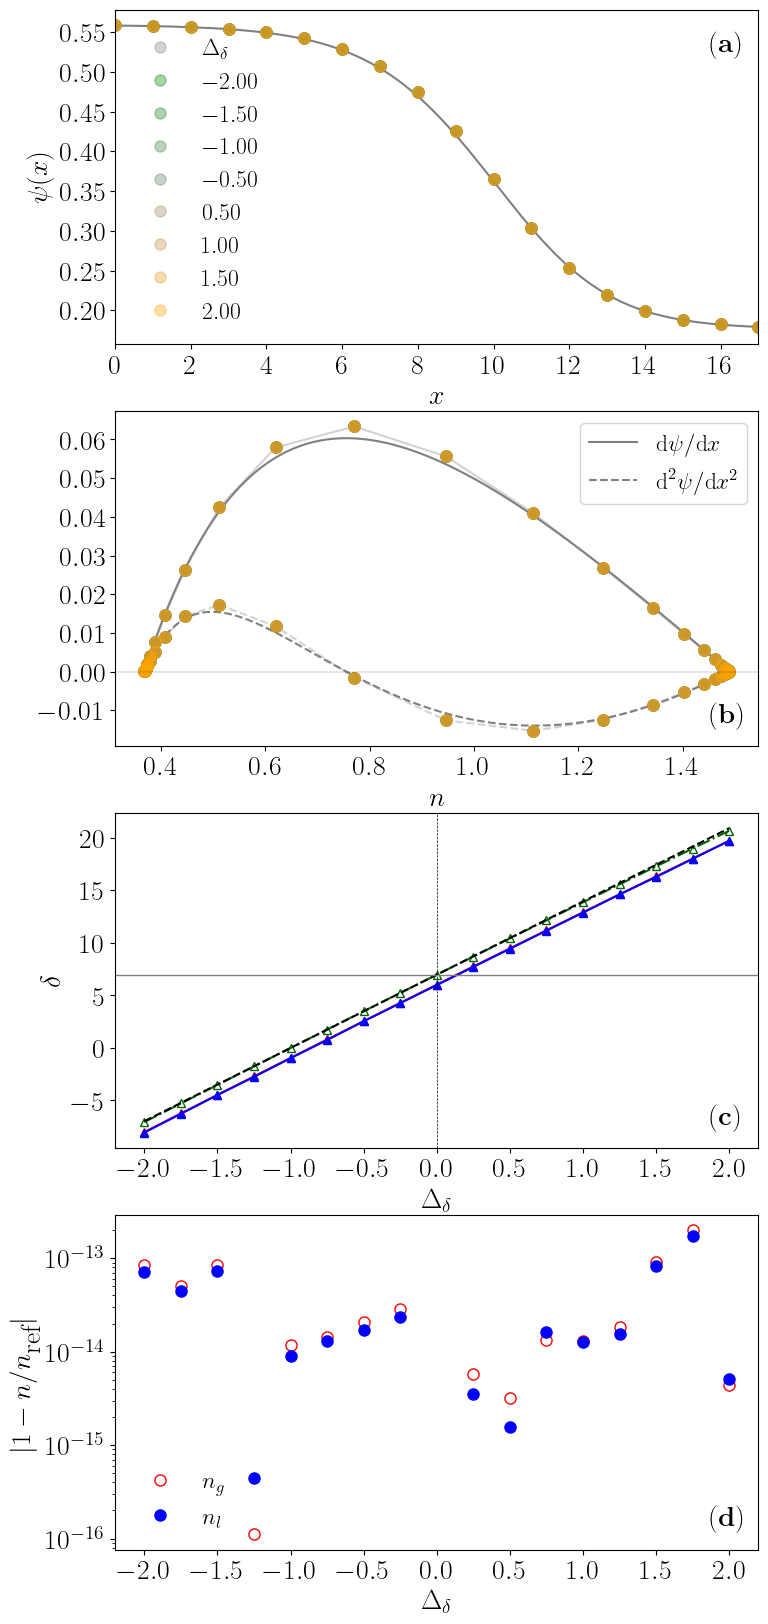

In [32]:
root_dir_fig = Path('./reproduced-figures/')
if not root_dir_fig.is_dir():
    root_dir_fig.mkdir()

import matplotlib

from idpy.Utils.Plots import SetAxPanelLabelCoords, SetMatplotlibLatexParamas, SetDefaultFonts
from idpy.Utils.Plots import CreateFiguresPanels, SetAxPanelLabel, SetAxTicksFont
from matplotlib import rc, rcParams

SetMatplotlibLatexParamas([rc], [rcParams])
fonts = SetDefaultFonts([rc])
fonts['fs'] = 25

fs, ms_small, ms_large, ms_large_c = 20, 7, 8, 20

psi_f = sp.lambdify([n], psi_sym)

colors = ['red', 'blue', 'darkgreen', 'darkorange', 'purple']

cmap_up = matplotlib.colors.LinearSegmentedColormap.from_list("MyCmapName",["gray","orange"])
col_norm_up = matplotlib.colors.Normalize(vmin = 0, vmax = 2)

cmap_dn = matplotlib.colors.LinearSegmentedColormap.from_list("MyCmapName",["green","gray"])
col_norm_dn = matplotlib.colors.Normalize(vmin = -2, vmax = 0)

cmap_sigma_up = matplotlib.colors.LinearSegmentedColormap.from_list("MyCmapName",["gray","red"])
col_sigma_norm_up = matplotlib.colors.Normalize(vmin = 0, vmax = 0.1)

cmap_sigma_dn = matplotlib.colors.LinearSegmentedColormap.from_list("MyCmapName",["blue","gray"])
col_sigma_norm_dn = matplotlib.colors.Normalize(vmin = -0.1, vmax = 0)

get_label = lambda d1: '$' + "{:0.2f}".format(d1) + '$'


nx_fig, ny_fig = 1, 4

y_size, xy_ratio = 4.3, 1.2
fig = CreateFiguresPanels(_nx=nx_fig,_ny=ny_fig, _x_size=8.3, _y_size=5)

############# PROFILE
if True:
    ax_profile = plt.subplot2grid((ny_fig, nx_fig), (0, 0), colspan = 1, rowspan = 1)

    ax_profile.plot(x_range + 83.25, psi_range, color='grey')

    for i, DDelta in enumerate([0]):
        color = cmap_dn(col_norm_dn(DDelta))
        n_strip = flat_profiles_G0p1[DDelta]
        ax_profile.plot(np.arange(len(n_strip)), psi_f(n_strip), 
                        marker = 'o', linestyle='none', color=color, 
                        alpha=0.35, markersize=ms_large,
                label='$\Delta_\delta$')


    for i, DDelta in enumerate([-2, -1.5, -1, -0.5]):
        color = cmap_dn(col_norm_dn(DDelta))
        n_strip = flat_profiles_G0p1[DDelta]
        ax_profile.plot(np.arange(len(n_strip)), psi_f(n_strip), 
                        marker = 'o', linestyle='none', color=color, 
                        alpha=0.35, markersize=ms_large, 
                label=get_label(DDelta))

    for i, DDelta in enumerate([0.5, 1, 1.5, 2]):
        color = cmap_up(col_norm_up(DDelta))
        n_strip = flat_profiles_G0p1[DDelta]
        ax_profile.plot(np.arange(len(n_strip)), psi_f(n_strip), marker = 'o',
                        linestyle='none', color=color, alpha=0.35, markersize=ms_large,
                label=get_label(DDelta))

    ax_profile.set_xlim([87, 104])
    ax_profile.legend(frameon = False, loc = 'lower left')

    for tick in ax_profile.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_profile.get_yticklabels():
        tick.set_fontsize(fs)

    SetAxPanelLabel(ax=ax_profile, label='$\mathbf{(a)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.875) 

    ax_profile.set_xlabel('$x$', fontsize = fs)
    ax_profile.set_ylabel('$\psi(x)$', fontsize = fs)
    ax_profile.set_xticks(np.arange(87, 104, 2), labels=np.arange(0, 17, 2))

################## DERIVATIVES
if True:
    ax_dd = plt.subplot2grid((ny_fig, nx_fig), (1, 0), colspan = 1, rowspan = 1)

    ax_dd.plot(n_range, dpsi_analytical, label = '$\mbox{d}\psi/\mbox{d}x$', color='gray')
    ax_dd.plot(n_range, d2psi_analytical, label = '$\mbox{d}^2\psi/\mbox{d}x^2$', color='gray', linestyle='--')

    for i, DDelta in enumerate([-2, -1.5, -1, -0.5]):
        color = cmap_dn(col_norm_dn(DDelta))

        n_strip = flat_profiles_G0p1[DDelta]

        n_data_spl = UnivariateSpline(np.arange(len(n_strip)), n_strip, s=0)
        psi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_f(n_strip), s=0)
        dpsi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_data_spl.derivative()(np.arange(len(n_strip))), s=0)

        x_strip = np.linspace(97 - 12, 97 + 12, 2 ** 10)
        x_strip_int = np.arange(97 - 12, 97 + 12, 1)

        ax_dd.plot(n_data_spl(x_strip_int), -psi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='none', color=color, markersize=ms_large, alpha=0.35)
        ax_dd.plot(n_data_spl(x_strip_int), dpsi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='none', color=color, markersize=ms_large, alpha=0.35)

    for i, DDelta in enumerate([0, 0.5, 1, 1.5, 2]):
        color = cmap_up(col_norm_up(DDelta))

        n_strip = flat_profiles_G0p1[DDelta]

        n_data_spl = UnivariateSpline(np.arange(len(n_strip)), n_strip, s=0)
        psi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_f(n_strip), s=0)
        dpsi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_data_spl.derivative()(np.arange(len(n_strip))), s=0)

        x_strip = np.linspace(97 - 12, 97 + 12, 2 ** 10)
        x_strip_int = np.arange(97 - 12, 97 + 12, 1)

        ax_dd.plot(n_data_spl(x_strip_int), -psi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='none' if DDelta !=0 else '-', color=color, markersize=ms_large, alpha=0.35)
        ax_dd.plot(n_data_spl(x_strip_int), dpsi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='none' if DDelta !=0 else '--', color=color, markersize=ms_large, alpha=0.35)

    ax_dd.axhline(y=0, color='black', linestyle='--', linewidth=0.2)

    ax_dd.legend()

    for tick in ax_dd.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_dd.get_yticklabels():
        tick.set_fontsize(fs)

    SetAxPanelLabel(ax=ax_dd, label='$\mathbf{(b)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.07) 

    ax_dd.set_xlabel('$n$', fontsize = fs)

################## TOLMAN
## flat_tolman_G0p1, flat_tolman_ads_G0p1, flat_sigma_G0p1, flat_DDeltas_G0p1

sort_deltas_index = np.argsort(flat_DDeltas_G0p1)

flat_tolman_G0p1 = flat_tolman_G0p1[sort_deltas_index]
flat_tolman_ads_G0p1 = flat_tolman_ads_G0p1[sort_deltas_index]
flat_tolman_sc_G0p1 = flat_tolman_sc_G0p1[sort_deltas_index]
flat_sigma_G0p1 = flat_sigma_G0p1[sort_deltas_index]
flat_DDeltas_G0p1 = flat_DDeltas_G0p1[sort_deltas_index]

if True:
    ax_tolman = plt.subplot2grid((ny_fig, nx_fig), (2, 0), colspan = 1, rowspan = 1)

    ax_tolman.plot(flat_DDeltas_G0p1, flat_tolman_G0p1, marker='^', color='red')
    ax_tolman.plot(flat_DDeltas_G0p1, flat_tolman_ads_G0p1, marker='^', color='blue')
    ax_tolman.plot(flat_DDeltas_G0p1, flat_tolman_sc_G0p1, marker='^', fillstyle='none', color='darkgreen', linestyle='-.')
    ref_tolman = flat_tolman_sc_G0p1[np.where(flat_DDeltas_G0p1 == 0)]
    ax_tolman.plot(flat_DDeltas_G0p1, ref_tolman * (1 + flat_DDeltas_G0p1), color='black', linestyle='--')

    ax_tolman.axvline(x=0, linestyle='--', linewidth=0.5, color='black')
    ax_tolman.axhline(y=ref_tolman, linewidth=1, color='gray')

    for tick in ax_tolman.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_tolman.get_yticklabels():
        tick.set_fontsize(fs)

    ax_tolman.set_xlabel('$\Delta_\delta$', fontsize = fs)
    ax_tolman.set_ylabel('$\delta$', fontsize = fs)

    SetAxPanelLabel(ax=ax_tolman, label='$\mathbf{(c)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.07)


################## DENSITIES
if True:
    ax_rhos = plt.subplot2grid((ny_fig, nx_fig), (3, 0), colspan = 1, rowspan = 1)

    ref_ng, ref_nl = np.amin(flat_profiles_G0p1[0]), np.amax(flat_profiles_G0p1[0])
    for i, DDelta in enumerate([-2, -1.75, -1.5, -1.25, -1, -0.75, -0.5, -0.25, 
                                          0, 
                                          0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]):
        ng, nl = np.amin(flat_profiles_G0p1[DDelta]), np.amax(flat_profiles_G0p1[DDelta])
        plt.plot([DDelta], [np.abs(1 - ng / ref_ng)], marker='o', fillstyle='none', color='red', 
                 label = '$n_g$' if DDelta == 0 else None, linestyle='none', markersize=ms_large)
        plt.plot([DDelta], [np.abs(1 - nl / ref_nl)], marker='o', color='blue', 
                 label = '$n_l$' if DDelta == 0 else None, linestyle='none', markersize=ms_large)

    for tick in ax_rhos.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_rhos.get_yticklabels():
        tick.set_fontsize(fs)

    ax_rhos.set_xlabel('$\Delta_\delta$', fontsize = fs)
    ax_rhos.set_ylabel('$|1 - n / n_{\mbox{ref}}|$', fontsize = fs)
    ax_rhos.set_yscale('log')

    ax_rhos.legend(frameon = False, loc = 'lower left')

    SetAxPanelLabel(ax=ax_rhos, label='$\mathbf{(d)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.07)

plt.savefig(root_dir_fig / 'flat_0p1.pdf', bbox_inches = 'tight', dpi = 150)

#### $\Delta \hat{T} = 0.2$

Pseudopotential:


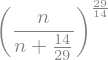


Critical coupling: -2519424*31888098**(1/7)/12313081 Critical density: 22/29
0.042082382908008725 0.07849385705448221 -0.12965853571011918 0.025172703467438717
Check Pressure: 0.06913938597768013 0.06913938597768007 0.06913938597767899
Density ratio: 7.195057501500707 1.9345223428349303 0.2688682255049995
Debug - the derivative values should both be positive - avoid negative square root: 3.69732307278384e-9 8.34815104780606e-19

sigma_f: 0.04518643452031894

21930


In [33]:
G_eps = 0.2

psi_sym = psis[1].subs(eps, ref_eps_val)
G_sym = sp.Symbol('G')
pb_sym = n / 3 + G_sym * (psi_sym ** 2) / 2

n_c, G_c = sp.solve([sp.Eq(sp.diff(pb_sym, (n, 1)), 0), sp.Eq(sp.diff(pb_sym, (n, 2)), 0)], [n, G_sym])[0]
print("Pseudopotential:")
display(psi_sym)
print()
print("Critical coupling:", G_c, "Critical density:", n_c)

G_val = G_c * (G_eps + 1)

ns_g, ns_l = SpinodalPsi(G_val, psi_sym, n, n_min=1e-1)
pb_lam = sp.lambdify([n], pb_sym.subs(G_sym, G_val))

MEAInteg_lam = lambda p: MaxwellEqualAreaIntegral(p, G_val, psi_sym, n, ns_g, ns_l, pb_lam)

p0_eq, steps_count = MyNewton(pb_lam(ns_l) * (1 + 1e-2) if pb_lam(ns_l) > 0 else 0,  pb_lam(ns_g) * (1 - 1e-2), MEAInteg_lam)
ng_eq, nl_eq = \
    FindDensityFromPressure(G_val, psi_sym, n, p0_eq, (ns_g, ns_l), branch='n_g', exp_2 = 11, n_max=2.5), \
    FindDensityFromPressure(G_val, psi_sym, n, p0_eq, (ns_g, ns_l), branch='n_l', exp_2 = 11, n_max=3)

print("Check Pressure:", p0_eq, pb_lam(ng_eq), pb_lam(nl_eq))
print("Density ratio:", nl_eq/ng_eq, nl_eq, ng_eq)

eq_params = {'n_l': nl_eq, 'n_g': ng_eq, 'n_l': nl_eq, 'sigma_f': None, 'G_c': G_c, 'n_c': n_c, 'p_0': p0_eq}


"""
Using a common value for the flat surface tension for initializing the densities
"""
dpsi2_lam = lambda n_val: MaxwellProfilePsiD2(n_val, eq_params['n_g'], eq_params['p_0'], ref_eps_val, G_val, pb_lam)

dpsi_sym = sp.diff(psi_sym, (n, 1))
dpsi_lam = sp.lambdify([n], dpsi_sym)
psi_lam = sp.lambdify([n], psi_sym)

d2psi_lam = \
    lambda n_val: (1 / (2 * psi_lam(n_val))) * (float(ref_eps_val) * dpsi2_lam(n_val) + 
                   (8 * ((1 - float(ref_eps_val)) / G_val.evalf()) * (eq_params['p_0'] - pb_lam(n_val))))

# n_range = np.linspace(eq_params['n_l'] * (1 - 1e-3), eq_params['n_g'] * (1 + 1e-5), 2 ** 13) ## 0.2
n_range = np.linspace(eq_params['n_l'] * (1 - 9e-4), eq_params['n_g'] * (1 + 5e-9), 2 ** 13)

print("Debug - the derivative values should both be positive - avoid negative square root:", dpsi2_lam(n_range[0]), dpsi2_lam(n_range[-1]))
dn_int = np.abs(n_range[1] - n_range[0])

Sigma_11 = np.sum(np.array([dpsi_lam(n_val) * np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])) * dn_int
Sigma_22 = np.sum(np.array([dpsi_lam(n_val) * (np.float64(d2psi_lam(n_val)) ** 2) / np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])) * dn_int

sigma_flat_value = np.float64(G_val * ((-e4_val / 2) * Sigma_11))
eq_params['sigma_f'] = sigma_flat_value

print()
print("sigma_f:", eq_params['sigma_f'])
print()

x_range, psi_range, n_range = GetPsiProfile(eq_params['n_c'] * 1e-4, psi_sym, n, eq_params, kickstart=9e-4) ## 0.2
dpsi_analytical = np.array([np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])
d2psi_analytical = np.array([d2psi_lam(n_val) for n_val in n_range])

In [34]:
from pathlib import Path

root_dir_res = Path('./reproduced-results/')
if not root_dir_res.is_dir():
    root_dir_res.mkdir()

def GetFileNameDelta0(G_eps, DDelta, dim_sizes, kind):
    name_str = "Delta0Tuning_" + "{:.4f}".format(G_eps) + '_' + "{:.4f}".format(DDelta) + '_' + str(dim_sizes) + '_' + str(kind)
    return name_str + '.hdf5'

from idpy.Utils.ManageData import ManageData

def ReadDensity(file_name, dim_sizes):
    file_name = str(file_name)
    md = ManageData(dump_file=file_name)
    n_strip = md.ReadHDF5(full_key='/ShanChenMultiPhase/idpy_memory/n', class_check_override=True)
    return n_strip.reshape(np.flip(dim_sizes))

from InterfaceTuning import GetSigma0, GetSigma1, GetFlatAdsorbance, GetFlatEquimolarSurface
from LatticePressureTensor import LPT_16_2D

def Analyze2DFlatDelta(n_field, dim_sizes, stencil, G, psi_sym, n_sym):
    """
    Getting the realized densities
    """
    n_strip = n_field[0,:]
    n_l_sim, n_g_sim = np.amax(n_strip), np.amin(n_strip)

    """
    Getting the position of the equimolar interface
    """
    z_e = GetFlatEquimolarSurface(n_line=n_strip[dim_sizes[0]//2:], z_range=np.arange(dim_sizes[0]//2), grains=2**10)

    """
    Getting the adsorbance function ... not so precise it seems ...
    """
    Gamma_f = GetFlatAdsorbance(n_strip[dim_sizes[0]//2:], np.arange(dim_sizes[0]//2), grains=2**10)
    # The domain is split in two inside the function

    """
    Getting components of the lattice pressure tensor
    """
    
    p_n = LPT_16_2D(G, n_field, stencil.PushStencil(), psi_sym, n_sym)['LPT'][dim_sizes[1]//2,dim_sizes[0]//2:,0]
    p_t = LPT_16_2D(G, n_field, stencil.PushStencil(), psi_sym, n_sym)['LPT'][dim_sizes[1]//2,dim_sizes[0]//2:,2]
    p_nmt_spl = UnivariateSpline(np.arange(len(p_n)), p_n - p_t, s=0)

    """
    Estimating surface tension and position of the surface of tension
    """
    sigma_p_nmt = p_nmt_spl.integral(0, dim_sizes[0]//2)
    p_nmt_M1_spl = UnivariateSpline(np.arange(len(p_n)), np.arange(len(p_n)) * (p_n - p_t), s=0)
    z_s = p_nmt_M1_spl.integral(0, dim_sizes[0]//2) / sigma_p_nmt

    delta_ads_sim = Gamma_f(z_s) / (n_l_sim - n_g_sim)
    delta_lpt = z_e - z_s

    return {'sigma_p_nmt': sigma_p_nmt, 'delta_lpt': delta_lpt, 'delta_ads_sim': delta_ads_sim, 'p_nmt_spl': p_nmt_spl,
            'x_range': np.arange(len(p_n))}


flat_profiles_G0p2 = {}
flat_tolman_G0p2, flat_tolman_ads_G0p2, flat_sigma_G0p2, flat_DDeltas_G0p2 = [], [], [], []
flat_tolman_sc_G0p2 = []

for DDelta in [0, 
               0.25, -0.25, 0.5, -0.5, 0.75, -0.75, 1, -1, 
               1.25, -1.25, 1.5, -1.5, 1.75, -1.75, 2, -2]:

    tuned_stencil_2d = \
        it2d_custom_reference.GetFullySolvedStencilISO2D({it2d_custom_reference.e_sym[4]: e4_val,
                                                        it2d_custom_reference.hat_sigma_1_sym: hat_sigma_1_ref, 
                                                        it2d_typ.hat_delta_0_sym: hat_delta_0_ref * (1 + DDelta)})
    G = float(G_val)

    dim_sizes = (128, 32)   
    dump_file_name = root_dir_res / Path(GetFileNameDelta0(np.float64(G_eps), DDelta, dim_sizes, 'flat'))
    print(dump_file_name, dump_file_name.is_file())

    if not dump_file_name.is_file():
        IT_sim = InterfaceTuningSims(lang=set_lang, device=set_device, cl_kind=set_kind, dim_sizes=dim_sizes)

        IT_sim.RunFlat(
            f_stencil=tuned_stencil_2d.PushStencil(),
            n_g=eq_params['n_g'], n_l=eq_params['n_l'], 
            # G=G, psi_sym=psi_sym, psi_code=psi_codes[psis[2]](float(eps_val)),
            G=G, psi_sym=psi_sym, psi_code=psi_codes[psis[1]](ref_eps_val),
            dump_name=dump_file_name)

    n_strip = ReadDensity(dump_file_name, dim_sizes)

    flat_profiles_G0p2[DDelta] = n_strip[0,:]

    xr_fine_sigma_tuned, dx_psi_2_tuned, Sigma0_tuned = GetSigma0(n_strip[0,:], psi_sym, n)
    xr_fine_sigma_tuned, d2x_psi_2_tuned, Sigma1_tuned = GetSigma1(n_strip[0,:], psi_sym, n)

    print("\delta n_g:", np.amin(n_strip) / eq_params['n_g'], "\delta n_l:", np.amax(n_strip) / eq_params['n_l'])

    n_g, n_l = np.amin(n_strip), np.amax(n_strip)
    psi_g, psi_l = psi_lam(n_g), psi_lam(n_l)
    
    flat_properties_tuned = Analyze2DFlatDelta(n_strip, dim_sizes, tuned_stencil_2d, G, psi_sym, n)

    tolman_sc = \
            - G * hat_delta_0_ref * (1 + DDelta) * (psi_l ** 2 - psi_g ** 2) / \
            (2 * flat_properties_tuned['sigma_p_nmt'])
    tolman_sc = float(tolman_sc)
    print("tolman_sc:", tolman_sc)

    flat_tolman_G0p2 += [flat_properties_tuned['delta_lpt']]
    flat_tolman_ads_G0p2 += [flat_properties_tuned['delta_ads_sim']]
    flat_sigma_G0p2 += [flat_properties_tuned['sigma_p_nmt']]
    flat_tolman_sc_G0p2 += [tolman_sc]
    flat_DDeltas_G0p2 += [DDelta]

    for _ in flat_properties_tuned:
        print(_, flat_properties_tuned[_])
    print()

    print(np.array(tuned_stencil_2d.w_sol[0], dtype=np.float64))

flat_tolman_G0p2, flat_tolman_ads_G0p2, flat_sigma_G0p2, flat_DDeltas_G0p2 = \
    np.array(flat_tolman_G0p2), np.array(flat_tolman_ads_G0p2), \
    np.array(flat_sigma_G0p2), np.array(flat_DDeltas_G0p2)

flat_tolman_sc_G0p2 = np.array(flat_tolman_sc_G0p2)

reproduced-results/Delta0Tuning_0.2000_0.0000_(128, 32)_flat.hdf5 True
\delta n_g: 0.9986309968600681 \delta n_l: 0.9997141983523071
(0, 0)
(1, 1)
(0, 0)
(1, 1)
tolman_sc: 3.8076211149087786
sigma_p_nmt 0.04470322933502036
delta_lpt 2.869764455932632
delta_ads_sim 2.8578713088114838
p_nmt_spl <scipy.interpolate._fitpack2.InterpolatedUnivariateSpline object at 0x79604a91c5b0>
x_range [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]

[ 2.64984472e-01  2.64449626e-03 -1.41640786e-02  2.66666667e-02
 -1.80598689e-03  3.47704675e-03  1.59480996e-04]
reproduced-results/Delta0Tuning_0.2000_0.2500_(128, 32)_flat.hdf5 True
\delta n_g: 0.9986309968600621 \delta n_l: 0.9997141983523115
(0, 0)
(1, 1)
(0, 0)
(1, 1)
tolman_sc: 4.730197618059798
sigma_p_nmt 0.04498040400858838
delta_lpt 3.790246105060529
delta_ads_sim 3.781624974626084
p_nmt_spl <scipy.int

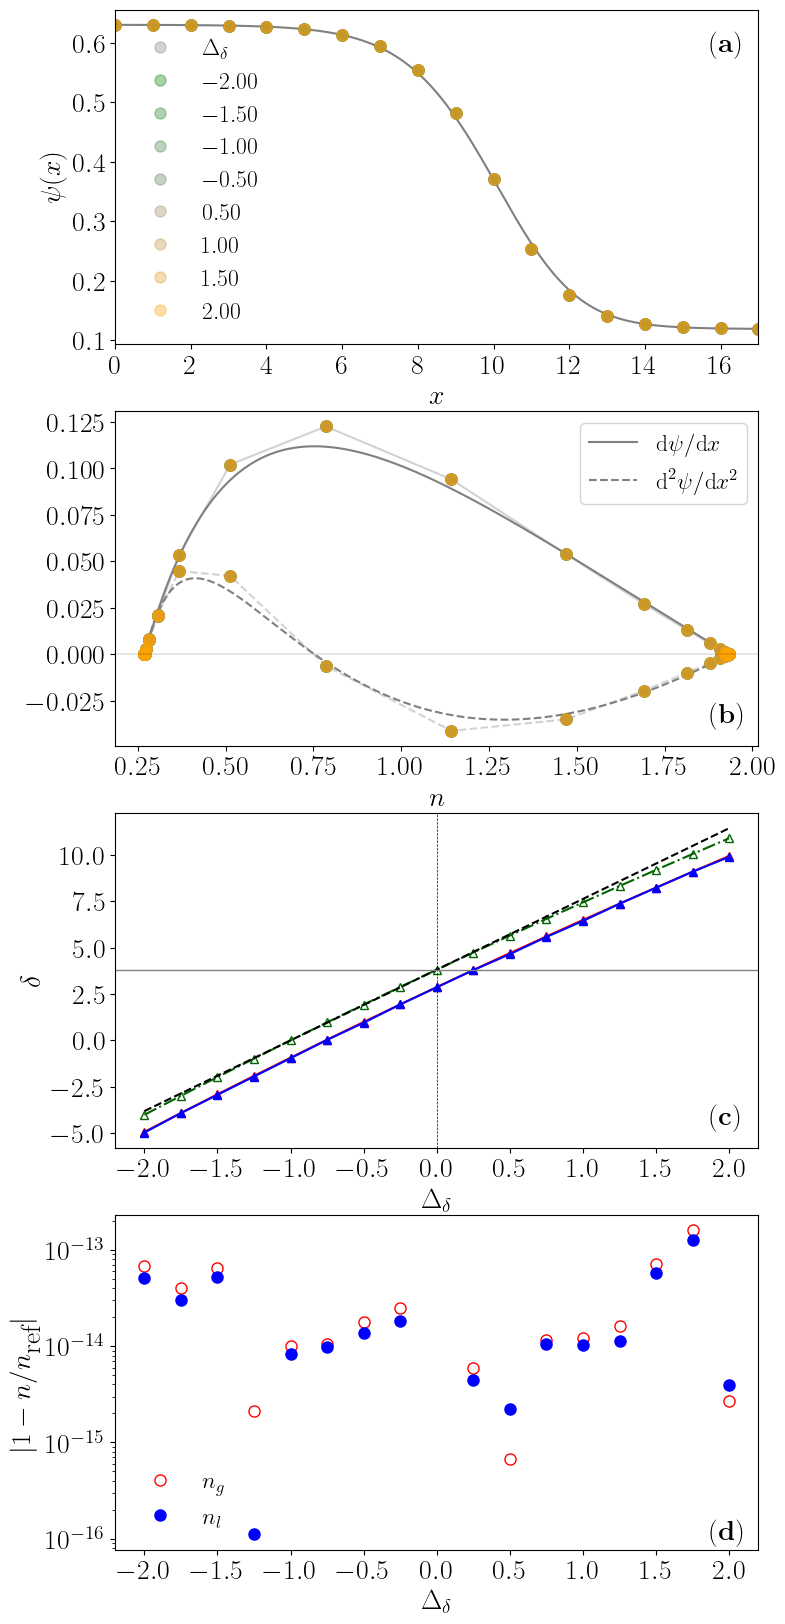

In [35]:
root_dir_fig = Path('./reproduced-figures/')
if not root_dir_fig.is_dir():
    root_dir_fig.mkdir()

import matplotlib

from idpy.Utils.Plots import SetAxPanelLabelCoords, SetMatplotlibLatexParamas, SetDefaultFonts
from idpy.Utils.Plots import CreateFiguresPanels, SetAxPanelLabel, SetAxTicksFont
from matplotlib import rc, rcParams

SetMatplotlibLatexParamas([rc], [rcParams])
fonts = SetDefaultFonts([rc])
fonts['fs'] = 25

fs, ms_small, ms_large, ms_large_c = 20, 7, 8, 20

psi_f = sp.lambdify([n], psi_sym)

colors = ['red', 'blue', 'darkgreen', 'darkorange', 'purple']

cmap_up = matplotlib.colors.LinearSegmentedColormap.from_list("MyCmapName",["gray","orange"])
col_norm_up = matplotlib.colors.Normalize(vmin = 0, vmax = 2)

cmap_dn = matplotlib.colors.LinearSegmentedColormap.from_list("MyCmapName",["green","gray"])
col_norm_dn = matplotlib.colors.Normalize(vmin = -2, vmax = 0)

cmap_sigma_up = matplotlib.colors.LinearSegmentedColormap.from_list("MyCmapName",["gray","red"])
col_sigma_norm_up = matplotlib.colors.Normalize(vmin = 0, vmax = 0.1)

cmap_sigma_dn = matplotlib.colors.LinearSegmentedColormap.from_list("MyCmapName",["blue","gray"])
col_sigma_norm_dn = matplotlib.colors.Normalize(vmin = -0.1, vmax = 0)

get_label = lambda d1: '$' + "{:0.2f}".format(d1) + '$'


nx_fig, ny_fig = 1, 4

y_size, xy_ratio = 4.3, 1.2
fig = CreateFiguresPanels(_nx=nx_fig,_ny=ny_fig, _x_size=8.3, _y_size=5)

############# PROFILE
if True:
    ax_profile = plt.subplot2grid((ny_fig, nx_fig), (0, 0), colspan = 1, rowspan = 1)

    ax_profile.plot(x_range + 86.85, psi_range, color='grey')

    for i, DDelta in enumerate([0]):
        color = cmap_dn(col_norm_dn(DDelta))
        n_strip = flat_profiles_G0p2[DDelta]
        ax_profile.plot(np.arange(len(n_strip)), psi_f(n_strip), 
                        marker = 'o', linestyle='none', color=color, 
                        alpha=0.35, markersize=ms_large,
                label='$\Delta_\delta$')


    for i, DDelta in enumerate([-2, -1.5, -1, -0.5]):
        color = cmap_dn(col_norm_dn(DDelta))
        n_strip = flat_profiles_G0p2[DDelta]
        ax_profile.plot(np.arange(len(n_strip)), psi_f(n_strip), 
                        marker = 'o', linestyle='none', color=color, 
                        alpha=0.35, markersize=ms_large, 
                label=get_label(DDelta))

    for i, DDelta in enumerate([0.5, 1, 1.5, 2]):
        color = cmap_up(col_norm_up(DDelta))
        n_strip = flat_profiles_G0p2[DDelta]
        ax_profile.plot(np.arange(len(n_strip)), psi_f(n_strip), marker = 'o',
                        linestyle='none', color=color, alpha=0.35, markersize=ms_large,
                label=get_label(DDelta))

    ax_profile.set_xlim([87, 104])
    ax_profile.legend(frameon = False, loc = 'lower left')

    for tick in ax_profile.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_profile.get_yticklabels():
        tick.set_fontsize(fs)

    ax_profile.set_xlabel('$x$', fontsize = fs)
    ax_profile.set_ylabel('$\psi(x)$', fontsize = fs)
    ax_profile.set_xticks(np.arange(87, 104, 2), labels=np.arange(0, 17, 2))

    SetAxPanelLabel(ax=ax_profile, label='$\mathbf{(a)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.875) 

################## DERIVATIVES
if True:
    ax_dd = plt.subplot2grid((ny_fig, nx_fig), (1, 0), colspan = 1, rowspan = 1)

    ax_dd.plot(n_range, dpsi_analytical, label = '$\mbox{d}\psi/\mbox{d}x$', color='gray')
    ax_dd.plot(n_range, d2psi_analytical, label = '$\mbox{d}^2\psi/\mbox{d}x^2$', color='gray', linestyle='--')

    for i, DDelta in enumerate([-2, -1.5, -1, -0.5]):
        color = cmap_dn(col_norm_dn(DDelta))

        n_strip = flat_profiles_G0p2[DDelta]

        n_data_spl = UnivariateSpline(np.arange(len(n_strip)), n_strip, s=0)
        psi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_f(n_strip), s=0)
        dpsi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_data_spl.derivative()(np.arange(len(n_strip))), s=0)

        x_strip = np.linspace(97 - 12, 97 + 12, 2 ** 10)
        x_strip_int = np.arange(97 - 12, 97 + 12, 1)

        ax_dd.plot(n_data_spl(x_strip_int), -psi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='none', color=color, markersize=ms_large, alpha=0.35)
        ax_dd.plot(n_data_spl(x_strip_int), dpsi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='none', color=color, markersize=ms_large, alpha=0.35)

    for i, DDelta in enumerate([0, 0.5, 1, 1.5, 2]):
        color = cmap_up(col_norm_up(DDelta))

        n_strip = flat_profiles_G0p2[DDelta]

        n_data_spl = UnivariateSpline(np.arange(len(n_strip)), n_strip, s=0)
        psi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_f(n_strip), s=0)
        dpsi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_data_spl.derivative()(np.arange(len(n_strip))), s=0)

        x_strip = np.linspace(97 - 12, 97 + 12, 2 ** 10)
        x_strip_int = np.arange(97 - 12, 97 + 12, 1)

        ax_dd.plot(n_data_spl(x_strip_int), -psi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='none' if DDelta !=0 else '-', color=color, markersize=ms_large, alpha=0.35)
        ax_dd.plot(n_data_spl(x_strip_int), dpsi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='none' if DDelta !=0 else '--', color=color, markersize=ms_large, alpha=0.35)

    ax_dd.axhline(y=0, color='black', linestyle='--', linewidth=0.2)

    ax_dd.legend()

    for tick in ax_dd.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_dd.get_yticklabels():
        tick.set_fontsize(fs)

    SetAxPanelLabel(ax=ax_dd, label='$\mathbf{(b)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.07)

    ax_dd.set_xlabel('$n$', fontsize = fs)

################## TOLMAN
## flat_tolman_G0p1, flat_tolman_ads_G0p1, flat_sigma_G0p1, flat_DDeltas_G0p1

sort_deltas_index = np.argsort(flat_DDeltas_G0p2)

flat_tolman_G0p2 = flat_tolman_G0p2[sort_deltas_index]
flat_tolman_ads_G0p2 = flat_tolman_ads_G0p2[sort_deltas_index]
flat_tolman_sc_G0p2 = flat_tolman_sc_G0p2[sort_deltas_index]
flat_sigma_G0p2 = flat_sigma_G0p2[sort_deltas_index]
flat_DDeltas_G0p2 = flat_DDeltas_G0p2[sort_deltas_index]

if True:
    ax_tolman = plt.subplot2grid((ny_fig, nx_fig), (2, 0), colspan = 1, rowspan = 1)

    ax_tolman.plot(flat_DDeltas_G0p2, flat_tolman_G0p2, marker='^', color='red')
    ax_tolman.plot(flat_DDeltas_G0p2, flat_tolman_ads_G0p2, marker='^', color='blue')
    ax_tolman.plot(flat_DDeltas_G0p2, flat_tolman_sc_G0p2, marker='^', fillstyle='none', color='darkgreen', linestyle='-.')
    ref_tolman = flat_tolman_sc_G0p2[np.where(flat_DDeltas_G0p2 == 0)]
    ax_tolman.plot(flat_DDeltas_G0p2, ref_tolman * (1 + flat_DDeltas_G0p2), color='black', linestyle='--')

    ax_tolman.axvline(x=0, linestyle='--', linewidth=0.5, color='black')
    ax_tolman.axhline(y=ref_tolman, linewidth=1, color='gray')

    for tick in ax_tolman.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_tolman.get_yticklabels():
        tick.set_fontsize(fs)

    ax_tolman.set_xlabel('$\Delta_\delta$', fontsize = fs)
    ax_tolman.set_ylabel('$\delta$', fontsize = fs)

    SetAxPanelLabel(ax=ax_tolman, label='$\mathbf{(c)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.07)

################## DENSITIES
if True:
    ax_rhos = plt.subplot2grid((ny_fig, nx_fig), (3, 0), colspan = 1, rowspan = 1)

    ref_ng, ref_nl = np.amin(flat_profiles_G0p2[0]), np.amax(flat_profiles_G0p2[0])
    for i, DDelta in enumerate([-2, -1.75, -1.5, -1.25, -1, -0.75, -0.5, -0.25, 
                                          0, 
                                          0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]):
        ng, nl = np.amin(flat_profiles_G0p2[DDelta]), np.amax(flat_profiles_G0p2[DDelta])
        plt.plot([DDelta], [np.abs(1 - ng / ref_ng)], marker='o', fillstyle='none', color='red', 
                 label = '$n_g$' if DDelta == 0 else None, linestyle='none', markersize=ms_large)
        plt.plot([DDelta], [np.abs(1 - nl / ref_nl)], marker='o', color='blue', 
                 label = '$n_l$' if DDelta == 0 else None, linestyle='none', markersize=ms_large)

    for tick in ax_rhos.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_rhos.get_yticklabels():
        tick.set_fontsize(fs)

    ax_rhos.set_xlabel('$\Delta_\delta$', fontsize = fs)
    ax_rhos.set_ylabel('$|1 - n / n_{\mbox{ref}}|$', fontsize = fs)
    ax_rhos.set_yscale('log')

    ax_rhos.legend(frameon = False, loc = 'lower left')

    SetAxPanelLabel(ax=ax_rhos, label='$\mathbf{(d)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.03)

plt.savefig(root_dir_fig / 'flat_0p2.pdf', bbox_inches = 'tight', dpi = 150)

## Results V.D: Nucleation Rates

### Simulations

In [36]:
from idpy.IdpyCode import OCL_T, CUDA_T, CTYPES_T
set_lang, set_device, set_kind = CUDA_T, 0, 'gpu'

In [37]:
e4_val = sp.Rational(4, 5)
e6_val = sp.Pow(e4_val, sp.Rational(3, 2))
e8_val = sp.Pow(e4_val, sp.Rational(2, 1))

ref_eps_val = (6 * e4_val - 2) / (6 * e4_val + 1)

In [38]:
n, eps = sp.Symbol('n'), sp.Symbol('\\varepsilon')
psis = [sp.exp(-1/n), sp.Pow((n / (eps + n)), 1 / eps)]

n_s_lambdas = {psis[0]: lambda G_val: SpinodalPsi(G_val, psis[0], n),
               psis[1]: lambda psi_sym: lambda G_val: SpinodalPsi(G_val, psi_sym, n)}

psi_codes = {psis[0]: 'exp((NType)(-1./ln_0))', 
             psis[1]: lambda eps_val: 'pow((ln_0 / (' + str(float(eps_val)) + ' + ln_0)), ' + str(float(1 / eps_val)) + ')'}

In [39]:
"""
Defining the tunable stencils: 2d - typ
"""
it2d_custom_reference = InterfaceTuning2D(l2_list=[1, 2, 4, 5, 8, 9, 18])
it2d_custom_reference.DefineWeights(
    [it2d_custom_reference.e_sym[n] - it2d_custom_reference.e_expr[n] for n in range(2, 8 + 1, 2)] + 
    [it2d_custom_reference.I_sym[(4,0)] - it2d_custom_reference.typ_eq_s[4][0], 
     it2d_custom_reference.I_sym[(6,0)] - it2d_custom_reference.typ_eq_s[6][0], 
     it2d_custom_reference.I_sym[(8,0)] - it2d_custom_reference.typ_eq_s[8][0]])

it2d_custom_reference.GetFullySolvedWeights()

eqs = [sp.Eq(it2d_custom_reference.hat_sigma_0_sym, it2d_custom_reference.hat_sigma_0_eIs[0]),
       sp.Eq(it2d_custom_reference.hat_sigma_1_sym, it2d_custom_reference.hat_sigma_0_eIs[1]), 
       sp.Eq(it2d_custom_reference.hat_delta_0_sym, it2d_custom_reference.hat_delta_0_eI)]

sol_hats_dict = sp.solve(eqs, [it2d_custom_reference.e_sym[4], it2d_custom_reference.e_sym[6], it2d_custom_reference.e_sym[8]])
iso_dict = it2d_custom_reference.GetStdIsoDict()

hat_sigma_0_ref = it2d_custom_reference.hat_sigma_0_eIs[0].subs({**iso_dict, 
                                                                 it2d_custom_reference.e_sym[4]: e4_val, 
                                                                 it2d_custom_reference.e_sym[6]: e6_val, 
                                                                 it2d_custom_reference.e_sym[8]: e8_val})

hat_sigma_1_ref = it2d_custom_reference.hat_sigma_0_eIs[1].subs({**iso_dict, 
                                                                 it2d_custom_reference.e_sym[4]: e4_val, 
                                                                 it2d_custom_reference.e_sym[6]: e6_val, 
                                                                 it2d_custom_reference.e_sym[8]: e8_val})

hat_delta_0_ref = it2d_custom_reference.hat_delta_0_eI.subs({**iso_dict, 
                                                             it2d_custom_reference.e_sym[4]: e4_val, 
                                                             it2d_custom_reference.e_sym[6]: e6_val, 
                                                             it2d_custom_reference.e_sym[8]: e8_val})

#### $\Delta \hat{T} = 0.056$

Pseudopotential:


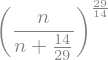


Critical coupling: -2519424*31888098**(1/7)/12313081 Critical density: 22/29
0.08479111013775745 0.08873008487373203 -0.004327897022132423 0.00167545709746672
Check Pressure: 0.08752371561162664 0.0875237156116266 0.0875237156116262
Density ratio: 2.848401687607837 1.264095818949395 0.44379127580528016
Debug - the derivative values should both be positive - avoid negative square root: 4.32059848573387e-9 3.84346390382822e-19

sigma_f: 0.007036898028815417

21590


In [40]:
G_eps = 0.056

psi_sym = psis[1].subs(eps, ref_eps_val)
G_sym = sp.Symbol('G')
pb_sym = n / 3 + G_sym * (psi_sym ** 2) / 2

n_c, G_c = sp.solve([sp.Eq(sp.diff(pb_sym, (n, 1)), 0), sp.Eq(sp.diff(pb_sym, (n, 2)), 0)], [n, G_sym])[0]
print("Pseudopotential:")
display(psi_sym)
print()
print("Critical coupling:", G_c, "Critical density:", n_c)

G_val = G_c * (G_eps + 1)

ns_g, ns_l = SpinodalPsi(G_val, psi_sym, n, n_min=1e-1)
pb_lam = sp.lambdify([n], pb_sym.subs(G_sym, G_val))

MEAInteg_lam = lambda p: MaxwellEqualAreaIntegral(p, G_val, psi_sym, n, ns_g, ns_l, pb_lam)

p0_eq, steps_count = MyNewton(pb_lam(ns_l) * (1 + 1e-2) if pb_lam(ns_l) > 0 else 0,  pb_lam(ns_g) * (1 - 1e-2), MEAInteg_lam)
ng_eq, nl_eq = \
    FindDensityFromPressure(G_val, psi_sym, n, p0_eq, (ns_g, ns_l), branch='n_g', exp_2 = 11, n_max=2.5), \
    FindDensityFromPressure(G_val, psi_sym, n, p0_eq, (ns_g, ns_l), branch='n_l', exp_2 = 11, n_max=3)

print("Check Pressure:", p0_eq, pb_lam(ng_eq), pb_lam(nl_eq))
print("Density ratio:", nl_eq/ng_eq, nl_eq, ng_eq)

eq_params = {'n_l': nl_eq, 'n_g': ng_eq, 'n_l': nl_eq, 'sigma_f': None, 'G_c': G_c, 'n_c': n_c, 'p_0': p0_eq}


"""
Using a common value for the flat surface tension for initializing the densities
"""
dpsi2_lam = lambda n_val: MaxwellProfilePsiD2(n_val, eq_params['n_g'], eq_params['p_0'], ref_eps_val, G_val, pb_lam)

dpsi_sym = sp.diff(psi_sym, (n, 1))
dpsi_lam = sp.lambdify([n], dpsi_sym)
psi_lam = sp.lambdify([n], psi_sym)

d2psi_lam = \
    lambda n_val: (1 / (2 * psi_lam(n_val))) * (float(ref_eps_val) * dpsi2_lam(n_val) + 
                   (8 * ((1 - float(ref_eps_val)) / G_val.evalf()) * (eq_params['p_0'] - pb_lam(n_val))))

n_range = np.linspace(eq_params['n_l'] * (1 - 9e-4), eq_params['n_g'] * (1 + 5e-9), 2 ** 13)
# n_range = np.linspace(eq_params['n_l'] * (1 - 9.25e-2), eq_params['n_g'] * (1 + 2e-2), 2 ** 13) ## 0.1
print("Debug - the derivative values should both be positive - avoid negative square root:", dpsi2_lam(n_range[0]), dpsi2_lam(n_range[-1]))
dn_int = np.abs(n_range[1] - n_range[0])

Sigma_11 = np.sum(np.array([dpsi_lam(n_val) * np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])) * dn_int
Sigma_22 = np.sum(np.array([dpsi_lam(n_val) * (np.float64(d2psi_lam(n_val)) ** 2) / np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])) * dn_int

sigma_flat_value = np.float64(G_val * ((-e4_val / 2) * Sigma_11))
eq_params['sigma_f'] = sigma_flat_value

print()
print("sigma_f:", eq_params['sigma_f'])
print()

x_range, psi_range, n_range = GetPsiProfile(eq_params['n_c'] * 5e-5, psi_sym, n, eq_params, kickstart=8e-4) ## 0.1
dpsi_analytical = np.array([np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])
d2psi_analytical = np.array([d2psi_lam(n_val) for n_val in n_range])

In [ ]:
# Not yet completed

from idpy.Utils.ManageData import ManageData

def SaveSnapshot(lbm, dump_file='nucleation-snapshots.hdf5', frames_list = None, key=None):
    if 'snap_seq' not in lbm.sims_vars:
        lbm.sims_vars['snap_seq'] = 0

    if frames_list is not None:
        if lbm.sims_vars['snap_seq'] in frames_list:
            n_field_32 = np.array(lbm.GetDensityField(), dtype=np.float32)
            n_field_32 = n_field_32.reshape((1,) +  n_field_32.shape)

            md = ManageData(dump_file=dump_file)
            md.PushData(data=n_field_32, key=key)
            md.DumpHDF5()
    else:
        n_field_32 = np.array(lbm.GetDensityField(), dtype=np.float32)
        n_field_32 = n_field_32.reshape((1,) +  n_field_32.shape)

        md = ManageData(dump_file=dump_file)
        md.PushData(data=n_field_32, key=key)
        md.DumpHDF5()

    lbm.sims_vars['snap_seq'] += 1
    return False

from idpy.LBM.MultiPhase import ShanChenMultiPhase

G_val = G_c * (G_eps + 1)
G = float(G_val)
a_val, kBT = 0.01, 5e-5
a_val = 0.0204177

# Only one sequence
reps, L = 1, 4096

total_time_steps = 320 * 32
delta_frames = 320

# total_time_steps = 3200 * 1
# delta_frames = 3200

dump_file='bubble-snapshots-new.hdf5'

from idpy.PRNGS.CRNGS import CRNGS
from idpy.IdpyCode import CTYPES_T

ddelta_str = lambda ddelta: ("%.2f" % ddelta).replace(".", "p")

ddelta_sequence_idx = {0: 1, 0.5: 31}
snapshots_frames = [8, 12, 16, 31]

## I actually need only one sequence...
for DDelta in [0]:
    ## Reading seeds
    md = ManageData(dump_file="bubble-counts-discovery-large.hdf5")
    if md.IsThereKeyHDF5(full_key='/ManageData/' + ddelta_str(DDelta)):
        seeds_swap = md.ReadHDF5(full_key='/ManageData/' + ddelta_str(DDelta) + '_seed')
        print("Recovering dumps with seeds ", seeds_swap)

    for rep in range(reps):
        tuned_stencil_2d = \
            it2d_typ.GetFullySolvedStencilISO2D(
                {it2d_typ.e_sym[4]: e4_val, 
                it2d_typ.hat_sigma_1_sym: hat_sigma_1, 
                it2d_typ.hat_delta_0_sym: hat_delta_0 * (1 + DDelta)})

        dim_sizes = (L, L)

        from datetime import datetime

        # seed = ddelta_crngs[DDelta]()
        # seed = seeds_swap[rep]
        seed = seeds_swap[ddelta_sequence_idx[DDelta]]
        print("Selected seed:", seed)        

        sims_params_dict = {
            'dim_sizes': dim_sizes, 
            'xi_stencil': IDStencils['LBM']['XI_D2Q9'], 
            'f_stencil': tuned_stencil_2d.PushStencil(),
            'psi_code': psi_codes[psis[2]](float(ref_eps_val)), 
            'psi_sym': psi_sym, 
            'e2_val': 1, 
            'SC_G': G, 
            'tau': 1,
            'lang': set_lang, 
            'device': set_device, 
            'cl_kind': set_kind, 
            'optimizer_flag': True,
            'fluctuations': 'Gross2011', 
            'prng_distribution': 'gaussian', 
            'indep_gaussian': False, 
            'prng_kind': 'MMIX',
            'prng_init_from': 'numpy', 
            'init_seed': seed
        }

        simulation = ShanChenMultiPhase(**sims_params_dict)

        n_g = eq_params['n_g']
        n_l = eq_params['n_l']

        bub_threshold = 0.5 * (n_l + n_g)
        n_init = nl_s_a(G_eps, a_val)

        simulation.InitFlatInterface(n_g=n_init, n_l=n_init, width=dim_sizes[0]/2, direction=0)

        simulation.sims_vars['n_g'], simulation.sims_vars['n_l'] = n_g, n_l

        simulation.MainLoopGross2011SRT(
            time_steps = range(0, total_time_steps + 1, delta_frames),
            convergence_functions = [SaveSnapshot], 
            convergence_functions_args=[{'dump_file': dump_file, 'frames_list': snapshots_frames}],
            profiling = False, kBT = kBT, n0 = sp.Symbol('ln_0'), print_flag=True
        )

        simulation.End()

### Figure 9

### Video

```bash
ffmpeg -r 25 -f image2 -i pics-merged-new/%010d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p test-nuc.mp4
```